# Discrete SAC and Grokfast Implementations

In [87]:
from collections import deque
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
import tqdm

## Four Rooms environment

In the question, we will implement several policy-gradient methods and apply them once again on our favorite domain, Four Rooms. The environment is implemented below in a Gymnasium-like interface. Code for plotting learning curves with confidence bands is also provided.

In [88]:
class FourRooms(object):
    def __init__(self):
        # The grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # Observation (state) space consists of all empty cells
        # To improve interpretability, we flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # Action space
        self.action_movement = {0: np.array([0, 1]),  # up
                                1: np.array([0, -1]),  # down
                                2: np.array([-1, 0]),  # left
                                3: np.array([1, 0])}  # right
        self.action_space = spaces.Discrete(4)

        # Start location
        self.start_location = [0, 0]

        # Goal location
        self.goal_location = [10, 10]

        # Wall locations
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, with a timeout of 459 steps
        self.max_time_steps = 459

        # Tracking variables during a single episode
        self.agent_location = None  # Track the agent's location in one episode.
        self.action = None  # Track the agent's action
        self.t = 0  # Track the current time step in one episode

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates ((row, col), origin is top left)
        to the Four Rooms coordinates ((x, y), origin is bottom left)
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): List variable consisting of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): List variable consisting of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # Reset the agent's location to the start location
        self.agent_location = self.start_location

        # Reset the timeout tracker to be 0
        self.t = 0

        # Reset the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (int): Int variable (i.e., 0 for "up"). See self.action_movement above for more details.
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == 2 or action == 3:
                action = np.random.choice([0, 1], 1)[0]
            else:
                action = np.random.choice([2, 3], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_movement[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls; if so, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        # Compute the reward (1 iff next state is goal location)
        reward = 0.0 if next_agent_location == self.goal_location else -1.0

        # Check termination/truncation
        # If agent reaches the goal, reward = 1, terminated = True
        # If timeout is reached, reward = 0, truncated = True
        terminated = False
        truncated = False
        if reward == 0.0:
            terminated = True
        elif self.t == self.max_time_steps:
            truncated = True

        # Update the agent's location, action, and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, truncated, {}

    def render(self):
        # Plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action_movement[self.action]}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        env = FourRooms()
        state, info = env.reset()

        for _ in range(1000):
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)
            env.render()
            if terminated or truncated:
                state, info = env.reset()
            else:
                state = next_state

# Un-comment to run test function
# FourRooms.test()

In [89]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [172]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title, smoothing = True, window=50):
    """
    Args:
        arr_list (list): List of results arrays to plot
        legend_list (list): List of legends corresponding to each result array
        color_list (list): List of color corresponding to each result array
        ylabel (string): Label of the vertical axis

        Make sure the elements in the arr_list, legend_list, and color_list
        are associated with each other correctly (in the same order).
        Do not forget to change the ylabel for different plots.
    """
    # Set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the vertical labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the standard error (of raw data, not smoothed)
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # Plot the mean
        averages = moving_average(arr.mean(axis=0), window_size=window) if smoothing else arr.mean(axis=0)
        h, = ax.plot(range(arr.shape[1]), averages, color=color, label=legend)
        # Plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), averages - arr_err, averages + arr_err, alpha=0.3,
                        color=color)
        # Save the plot handle
        h_list.append(h)

    # Plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [ ]:
def compute_grad_magnitudes(model):
    """Compute the total gradient magnitude for a model's gradients."""
    total_grad = 0.0
    for param in model.parameters():
        if param.grad is not None:
            total_grad += torch.norm(param.grad).item()
    return total_grad

def track_grad_stats(agent):
    """Track gradient statistics for actor and critics."""
    actor_grad_mag = compute_grad_magnitudes(agent.actor)
    critic1_grad_mag = compute_grad_magnitudes(agent.critic1)
    critic2_grad_mag = compute_grad_magnitudes(agent.critic2)
    
    return {
        'actor_grad_mag': actor_grad_mag,
        'critic1_grad_mag': critic1_grad_mag,
        'critic2_grad_mag': critic2_grad_mag,
        'total_grad_mag': actor_grad_mag + critic1_grad_mag + critic2_grad_mag
    }

def track_ema_grad_stats(actor_grads, critic_1_grads, critic_2_grads):
    """Track EMA gradient statistics."""
    actor_mag = sum(torch.norm(g).item() for g in actor_grads.values()) if actor_grads else 0
    critic1_mag = sum(torch.norm(g).item() for g in critic_1_grads.values()) if critic_1_grads else 0
    critic2_mag = sum(torch.norm(g).item() for g in critic_2_grads.values()) if critic_2_grads else 0
    
    return {
        'actor_grad_mag': actor_mag,
        'critic1_grad_mag': critic1_mag,
        'critic2_grad_mag': critic2_mag,
        'total_grad_mag': actor_mag + critic1_mag + critic2_mag
    }


Trial 1/5


Ep:100 | R:-52.9 | AvgR:-68.4 | Succ:76.0% | Len:201.7 | α:0.219 | H:0.50:  10%|█         | 101/1000 [01:39<05:12,  2.88it/s]


Episode 100 Statistics:
Episode Return: -52.94
Average Return (100 ep): -68.36 ± 26.07
Success Rate (100 ep): 76.0%
Average Episode Length: 201.7
Evaluation Return: -71.00
Evaluation Success Rate: 100.0%
Average Q-Value: -14.16
Policy Entropy: 0.719
Alpha: 0.219
Policy Loss: 27.105
Q Loss: 1.516
--------------------------------------------------


Ep:201 | R:-23.8 | AvgR:-41.8 | Succ:100.0% | Len:58.9 | α:0.525 | H:0.64:  20%|██        | 202/1000 [02:20<03:15,  4.07it/s]


Episode 200 Statistics:
Episode Return: -43.61
Average Return (100 ep): -42.10 ± 14.16
Success Rate (100 ep): 100.0%
Average Episode Length: 59.4
Evaluation Return: -79.00
Evaluation Success Rate: 100.0%
Average Q-Value: -22.12
Policy Entropy: 0.560
Alpha: 0.522
Policy Loss: 21.662
Q Loss: 2.467
--------------------------------------------------


Ep:301 | R:-18.2 | AvgR:-36.6 | Succ:100.0% | Len:48.7 | α:0.547 | H:0.65:  30%|███       | 302/1000 [02:55<02:43,  4.27it/s]


Episode 300 Statistics:
Episode Return: -22.22
Average Return (100 ep): -36.63 ± 12.02
Success Rate (100 ep): 100.0%
Average Episode Length: 48.8
Evaluation Return: -32.00
Evaluation Success Rate: 100.0%
Average Q-Value: -18.94
Policy Entropy: 0.774
Alpha: 0.546
Policy Loss: 19.478
Q Loss: 2.615
--------------------------------------------------


Ep:400 | R:-27.5 | AvgR:-28.0 | Succ:100.0% | Len:34.0 | α:0.549 | H:0.64:  40%|████      | 401/1000 [03:19<02:13,  4.47it/s]


Episode 400 Statistics:
Episode Return: -27.50
Average Return (100 ep): -28.05 ± 4.83
Success Rate (100 ep): 100.0%
Average Episode Length: 34.0
Evaluation Return: -24.20
Evaluation Success Rate: 100.0%
Average Q-Value: -13.25
Policy Entropy: 0.706
Alpha: 0.549
Policy Loss: 14.145
Q Loss: 1.157
--------------------------------------------------


Ep:500 | R:-27.5 | AvgR:-28.0 | Succ:100.0% | Len:34.0 | α:0.454 | H:0.72:  50%|█████     | 501/1000 [03:43<02:10,  3.83it/s]


Episode 500 Statistics:
Episode Return: -27.50
Average Return (100 ep): -28.03 ± 4.99
Success Rate (100 ep): 100.0%
Average Episode Length: 34.0
Evaluation Return: -22.60
Evaluation Success Rate: 100.0%
Average Q-Value: -11.30
Policy Entropy: 0.698
Alpha: 0.454
Policy Loss: 11.672
Q Loss: 0.453
--------------------------------------------------


Ep:600 | R:-27.5 | AvgR:-27.7 | Succ:100.0% | Len:35.4 | α:0.471 | H:0.70:  60%|██████    | 601/1000 [04:10<01:46,  3.76it/s]


Episode 600 Statistics:
Episode Return: -27.50
Average Return (100 ep): -27.68 ± 8.32
Success Rate (100 ep): 100.0%
Average Episode Length: 35.4
Evaluation Return: -26.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.30
Policy Entropy: 0.711
Alpha: 0.471
Policy Loss: 11.493
Q Loss: 0.476
--------------------------------------------------


Ep:701 | R:-26.0 | AvgR:-27.3 | Succ:100.0% | Len:32.9 | α:0.434 | H:0.69:  70%|███████   | 702/1000 [04:30<00:54,  5.49it/s]


Episode 700 Statistics:
Episode Return: -26.77
Average Return (100 ep): -27.33 ± 4.92
Success Rate (100 ep): 100.0%
Average Episode Length: 33.0
Evaluation Return: -24.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.82
Policy Entropy: 0.706
Alpha: 0.435
Policy Loss: 11.014
Q Loss: 0.384
--------------------------------------------------


Ep:801 | R:-26.8 | AvgR:-26.5 | Succ:100.0% | Len:31.9 | α:0.453 | H:0.62:  80%|████████  | 802/1000 [04:50<00:39,  5.00it/s]


Episode 800 Statistics:
Episode Return: -28.94
Average Return (100 ep): -26.51 ± 4.70
Success Rate (100 ep): 100.0%
Average Episode Length: 31.9
Evaluation Return: -23.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.90
Policy Entropy: 0.688
Alpha: 0.453
Policy Loss: 10.805
Q Loss: 0.350
--------------------------------------------------


Ep:901 | R:-24.5 | AvgR:-26.7 | Succ:100.0% | Len:32.1 | α:0.438 | H:0.71:  90%|█████████ | 902/1000 [05:10<00:16,  5.77it/s]


Episode 900 Statistics:
Episode Return: -22.22
Average Return (100 ep): -26.73 ± 4.24
Success Rate (100 ep): 100.0%
Average Episode Length: 32.1
Evaluation Return: -27.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.65
Policy Entropy: 0.696
Alpha: 0.437
Policy Loss: 10.623
Q Loss: 0.354
--------------------------------------------------


Ep:999 | R:-27.5 | AvgR:-26.7 | Succ:100.0% | Len:32.1 | α:0.437 | H:0.71: 100%|██████████| 1000/1000 [05:28<00:00,  3.04it/s]


append to all_returns


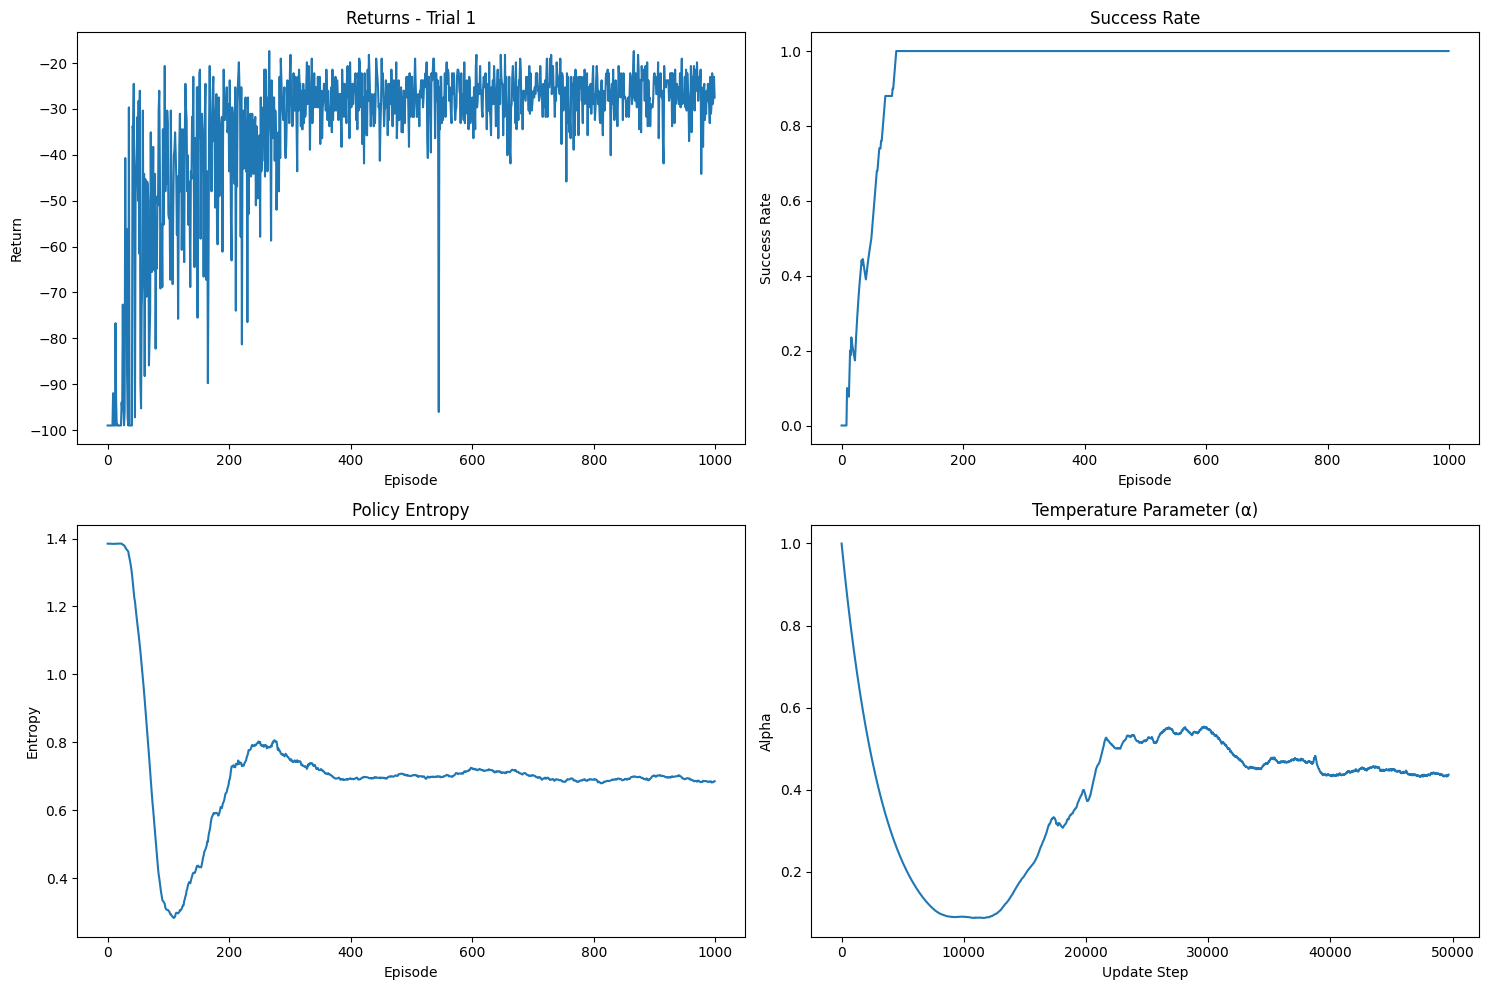


Trial 2/5


Ep:100 | R:-31.1 | AvgR:-67.7 | Succ:74.0% | Len:205.0 | α:0.164 | H:0.45:  10%|█         | 101/1000 [01:39<05:21,  2.80it/s]


Episode 100 Statistics:
Episode Return: -31.06
Average Return (100 ep): -67.73 ± 27.71
Success Rate (100 ep): 74.0%
Average Episode Length: 205.0
Evaluation Return: -63.40
Evaluation Success Rate: 100.0%
Average Q-Value: -17.75
Policy Entropy: 0.763
Alpha: 0.164
Policy Loss: 30.868
Q Loss: 1.576
--------------------------------------------------


Ep:201 | R:-20.6 | AvgR:-41.5 | Succ:100.0% | Len:60.8 | α:0.711 | H:0.57:  20%|██        | 202/1000 [02:15<02:55,  4.54it/s]


Episode 200 Statistics:
Episode Return: -34.43
Average Return (100 ep): -42.06 ± 16.70
Success Rate (100 ep): 100.0%
Average Episode Length: 62.0
Evaluation Return: -49.40
Evaluation Success Rate: 100.0%
Average Q-Value: -25.96
Policy Entropy: 0.544
Alpha: 0.712
Policy Loss: 25.364
Q Loss: 3.771
--------------------------------------------------


Ep:301 | R:-28.9 | AvgR:-33.9 | Succ:100.0% | Len:44.1 | α:0.540 | H:0.59:  30%|███       | 302/1000 [02:41<02:34,  4.52it/s]


Episode 300 Statistics:
Episode Return: -24.53
Average Return (100 ep): -33.83 ± 11.26
Success Rate (100 ep): 100.0%
Average Episode Length: 44.0
Evaluation Return: -37.20
Evaluation Success Rate: 100.0%
Average Q-Value: -19.66
Policy Entropy: 0.676
Alpha: 0.543
Policy Loss: 19.547
Q Loss: 2.642
--------------------------------------------------


Ep:401 | R:-23.8 | AvgR:-28.2 | Succ:100.0% | Len:34.3 | α:0.552 | H:0.65:  40%|████      | 402/1000 [03:01<01:31,  6.54it/s]


Episode 400 Statistics:
Episode Return: -32.43
Average Return (100 ep): -28.29 ± 5.42
Success Rate (100 ep): 100.0%
Average Episode Length: 34.4
Evaluation Return: -24.60
Evaluation Success Rate: 100.0%
Average Q-Value: -14.81
Policy Entropy: 0.701
Alpha: 0.551
Policy Loss: 13.263
Q Loss: 0.793
--------------------------------------------------


Ep:501 | R:-23.0 | AvgR:-26.6 | Succ:100.0% | Len:32.0 | α:0.474 | H:0.76:  50%|█████     | 502/1000 [03:17<01:07,  7.35it/s]


Episode 500 Statistics:
Episode Return: -22.22
Average Return (100 ep): -26.63 ± 4.83
Success Rate (100 ep): 100.0%
Average Episode Length: 32.0
Evaluation Return: -25.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.11
Policy Entropy: 0.692
Alpha: 0.475
Policy Loss: 10.912
Q Loss: 0.426
--------------------------------------------------


Ep:601 | R:-25.3 | AvgR:-27.1 | Succ:100.0% | Len:32.7 | α:0.426 | H:0.73:  60%|██████    | 602/1000 [03:35<01:17,  5.14it/s]


Episode 600 Statistics:
Episode Return: -28.23
Average Return (100 ep): -27.08 ± 4.72
Success Rate (100 ep): 100.0%
Average Episode Length: 32.6
Evaluation Return: -26.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.67
Policy Entropy: 0.704
Alpha: 0.425
Policy Loss: 10.769
Q Loss: 0.348
--------------------------------------------------


Ep:701 | R:-28.9 | AvgR:-26.5 | Succ:100.0% | Len:31.9 | α:0.415 | H:0.68:  70%|███████   | 702/1000 [03:53<00:51,  5.83it/s]


Episode 700 Statistics:
Episode Return: -26.03
Average Return (100 ep): -26.51 ± 4.58
Success Rate (100 ep): 100.0%
Average Episode Length: 31.9
Evaluation Return: -25.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.93
Policy Entropy: 0.712
Alpha: 0.412
Policy Loss: 10.778
Q Loss: 0.352
--------------------------------------------------


Ep:801 | R:-24.5 | AvgR:-27.0 | Succ:100.0% | Len:32.5 | α:0.401 | H:0.61:  80%|████████  | 802/1000 [04:10<00:31,  6.35it/s]


Episode 800 Statistics:
Episode Return: -20.64
Average Return (100 ep): -27.07 ± 4.22
Success Rate (100 ep): 100.0%
Average Episode Length: 32.6
Evaluation Return: -24.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.15
Policy Entropy: 0.698
Alpha: 0.400
Policy Loss: 11.035
Q Loss: 0.360
--------------------------------------------------


Ep:901 | R:-23.0 | AvgR:-27.3 | Succ:100.0% | Len:33.0 | α:0.396 | H:0.72:  90%|█████████ | 902/1000 [04:27<00:18,  5.35it/s]


Episode 900 Statistics:
Episode Return: -31.74
Average Return (100 ep): -27.33 ± 5.14
Success Rate (100 ep): 100.0%
Average Episode Length: 33.0
Evaluation Return: -28.20
Evaluation Success Rate: 100.0%
Average Q-Value: -11.04
Policy Entropy: 0.687
Alpha: 0.395
Policy Loss: 11.287
Q Loss: 0.380
--------------------------------------------------


Ep:999 | R:-22.2 | AvgR:-26.9 | Succ:100.0% | Len:32.5 | α:0.399 | H:0.62: 100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]


append to all_returns


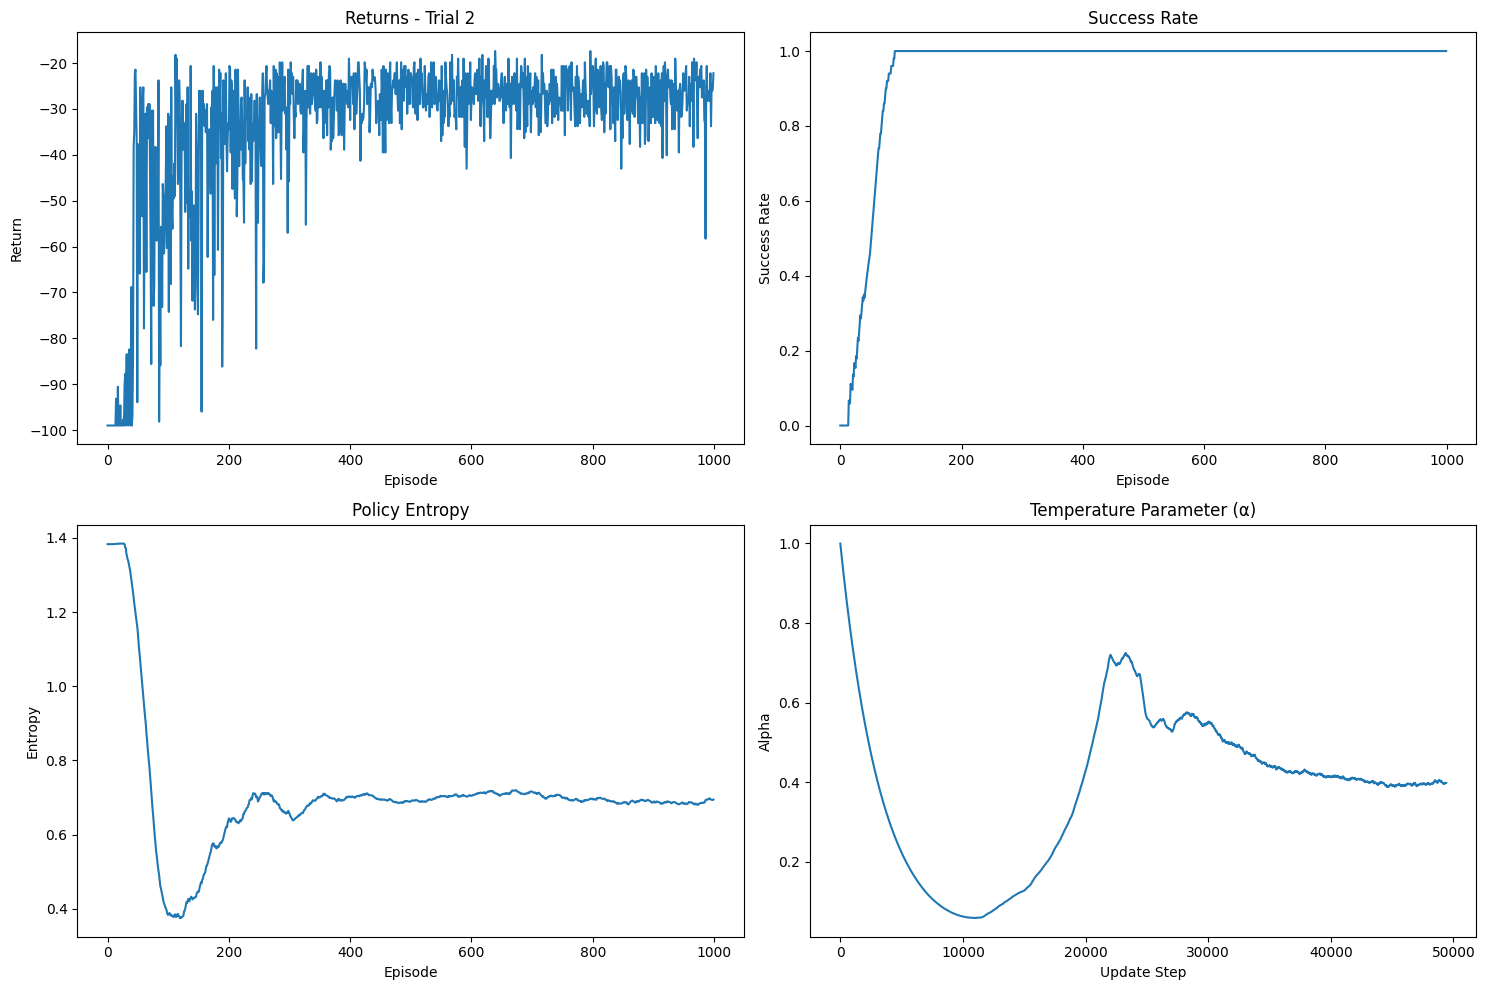


Trial 3/5


Ep:100 | R:-51.5 | AvgR:-70.9 | Succ:64.0% | Len:235.8 | α:0.197 | H:0.57:  10%|█         | 101/1000 [01:43<09:24,  1.59it/s]


Episode 100 Statistics:
Episode Return: -51.50
Average Return (100 ep): -70.92 ± 28.17
Success Rate (100 ep): 64.0%
Average Episode Length: 235.8
Evaluation Return: -207.80
Evaluation Success Rate: 60.0%
Average Q-Value: -17.97
Policy Entropy: 0.759
Alpha: 0.197
Policy Loss: 31.986
Q Loss: 2.849
--------------------------------------------------


Ep:201 | R:-24.5 | AvgR:-36.1 | Succ:99.0% | Len:53.1 | α:0.396 | H:0.42:  20%|██        | 202/1000 [02:15<02:42,  4.91it/s] 


Episode 200 Statistics:
Episode Return: -29.66
Average Return (100 ep): -36.83 ± 17.86
Success Rate (100 ep): 98.0%
Average Episode Length: 57.5
Evaluation Return: -35.00
Evaluation Success Rate: 100.0%
Average Q-Value: -26.35
Policy Entropy: 0.481
Alpha: 0.396
Policy Loss: 30.471
Q Loss: 4.416
--------------------------------------------------


Ep:300 | R:-57.0 | AvgR:-30.3 | Succ:100.0% | Len:39.2 | α:0.835 | H:0.38:  30%|███       | 301/1000 [02:35<03:13,  3.62it/s]


Episode 300 Statistics:
Episode Return: -57.01
Average Return (100 ep): -30.33 ± 12.23
Success Rate (100 ep): 100.0%
Average Episode Length: 39.2
Evaluation Return: -32.60
Evaluation Success Rate: 100.0%
Average Q-Value: -20.21
Policy Entropy: 0.489
Alpha: 0.835
Policy Loss: 20.564
Q Loss: 4.645
--------------------------------------------------


Ep:401 | R:-23.0 | AvgR:-28.6 | Succ:100.0% | Len:35.3 | α:0.566 | H:0.63:  40%|████      | 402/1000 [02:54<01:40,  5.94it/s]


Episode 400 Statistics:
Episode Return: -20.64
Average Return (100 ep): -28.66 ± 7.63
Success Rate (100 ep): 100.0%
Average Episode Length: 35.4
Evaluation Return: -22.60
Evaluation Success Rate: 100.0%
Average Q-Value: -13.65
Policy Entropy: 0.694
Alpha: 0.565
Policy Loss: 12.398
Q Loss: 0.673
--------------------------------------------------


Ep:501 | R:-25.3 | AvgR:-27.6 | Succ:100.0% | Len:33.5 | α:0.474 | H:0.57:  50%|█████     | 502/1000 [03:13<01:18,  6.32it/s]


Episode 500 Statistics:
Episode Return: -19.84
Average Return (100 ep): -27.61 ± 5.29
Success Rate (100 ep): 100.0%
Average Episode Length: 33.4
Evaluation Return: -25.60
Evaluation Success Rate: 100.0%
Average Q-Value: -11.00
Policy Entropy: 0.695
Alpha: 0.473
Policy Loss: 10.937
Q Loss: 0.372
--------------------------------------------------


Ep:601 | R:-23.8 | AvgR:-27.2 | Succ:100.0% | Len:32.9 | α:0.464 | H:0.68:  60%|██████    | 602/1000 [03:31<01:06,  5.99it/s]


Episode 600 Statistics:
Episode Return: -25.28
Average Return (100 ep): -27.26 ± 4.91
Success Rate (100 ep): 100.0%
Average Episode Length: 32.9
Evaluation Return: -23.20
Evaluation Success Rate: 100.0%
Average Q-Value: -11.15
Policy Entropy: 0.700
Alpha: 0.463
Policy Loss: 11.057
Q Loss: 0.385
--------------------------------------------------


Ep:701 | R:-21.4 | AvgR:-26.3 | Succ:100.0% | Len:31.5 | α:0.456 | H:0.67:  70%|███████   | 702/1000 [03:50<00:43,  6.79it/s]


Episode 700 Statistics:
Episode Return: -25.28
Average Return (100 ep): -26.29 ± 4.80
Success Rate (100 ep): 100.0%
Average Episode Length: 31.6
Evaluation Return: -23.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.99
Policy Entropy: 0.696
Alpha: 0.457
Policy Loss: 10.828
Q Loss: 0.376
--------------------------------------------------


Ep:801 | R:-21.4 | AvgR:-25.9 | Succ:100.0% | Len:31.0 | α:0.449 | H:0.68:  80%|████████  | 802/1000 [04:06<00:28,  6.91it/s]


Episode 800 Statistics:
Episode Return: -18.21
Average Return (100 ep): -25.92 ± 4.55
Success Rate (100 ep): 100.0%
Average Episode Length: 31.0
Evaluation Return: -28.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.83
Policy Entropy: 0.692
Alpha: 0.448
Policy Loss: 10.687
Q Loss: 0.344
--------------------------------------------------


Ep:900 | R:-23.0 | AvgR:-26.4 | Succ:100.0% | Len:31.7 | α:0.441 | H:0.76:  90%|█████████ | 901/1000 [04:23<00:15,  6.36it/s]


Episode 900 Statistics:
Episode Return: -23.00
Average Return (100 ep): -26.38 ± 4.62
Success Rate (100 ep): 100.0%
Average Episode Length: 31.7
Evaluation Return: -25.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.80
Policy Entropy: 0.694
Alpha: 0.441
Policy Loss: 10.590
Q Loss: 0.318
--------------------------------------------------


Ep:999 | R:-19.8 | AvgR:-27.3 | Succ:100.0% | Len:32.9 | α:0.433 | H:0.65: 100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


append to all_returns


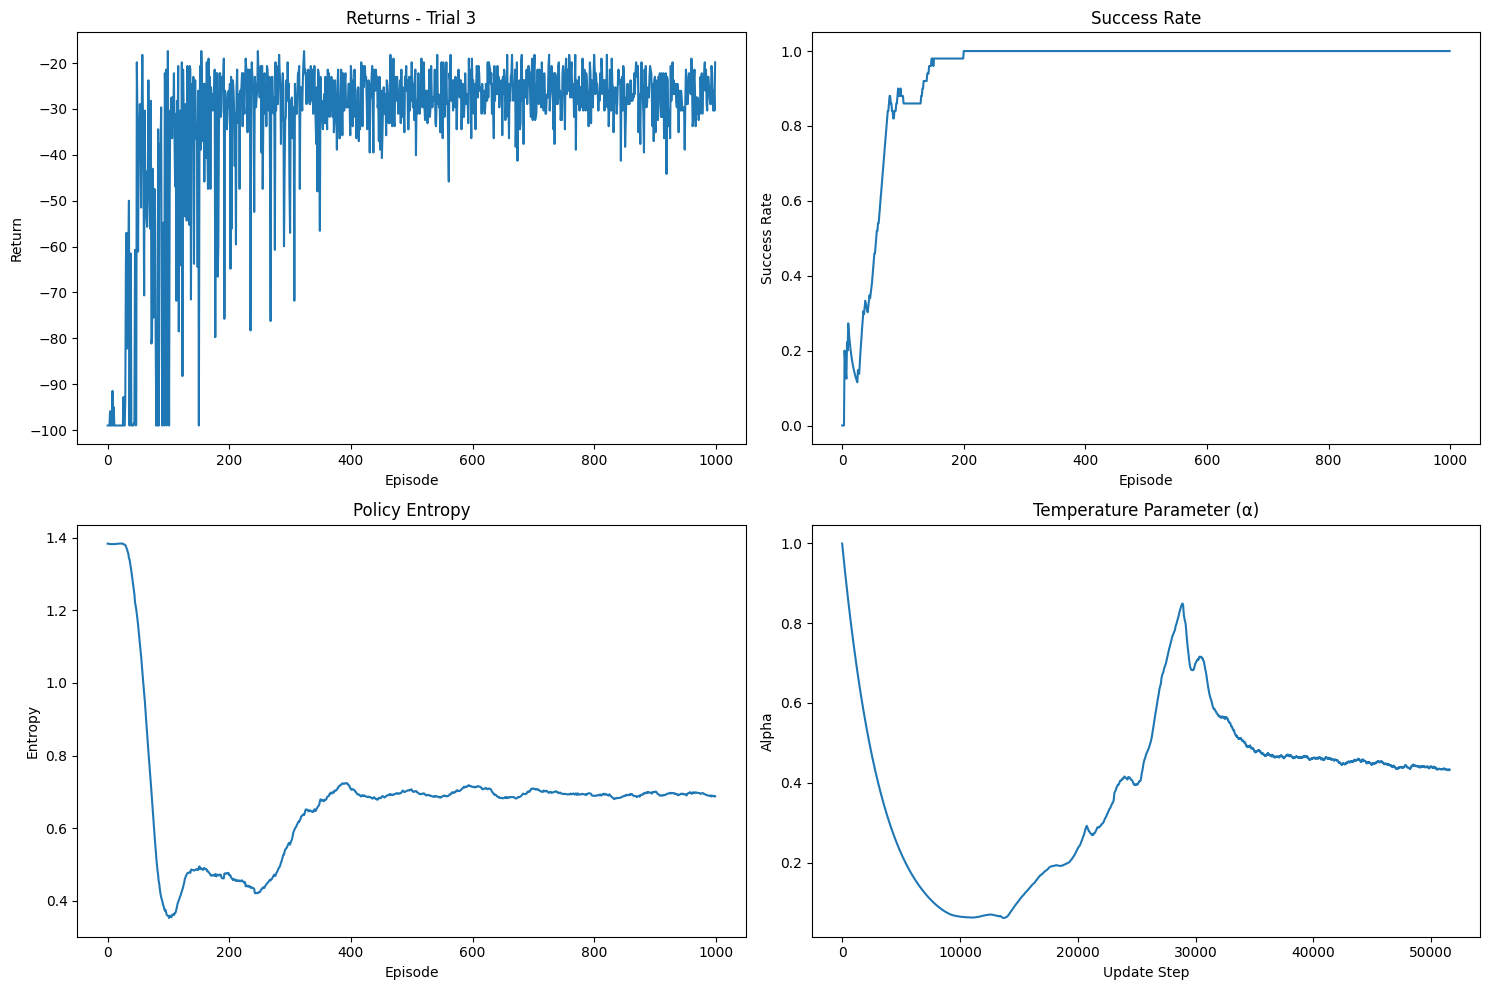


Trial 4/5


Ep:100 | R:-34.4 | AvgR:-69.8 | Succ:77.0% | Len:208.6 | α:0.182 | H:0.38:  10%|█         | 101/1000 [01:25<05:29,  2.73it/s]


Episode 100 Statistics:
Episode Return: -34.43
Average Return (100 ep): -69.81 ± 26.78
Success Rate (100 ep): 77.0%
Average Episode Length: 208.6
Evaluation Return: -460.00
Evaluation Success Rate: 0.0%
Average Q-Value: -15.44
Policy Entropy: 0.714
Alpha: 0.182
Policy Loss: 30.567
Q Loss: 2.230
--------------------------------------------------


Ep:200 | R:-88.2 | AvgR:-39.1 | Succ:100.0% | Len:53.4 | α:0.651 | H:0.48:  20%|██        | 201/1000 [01:57<07:15,  1.84it/s]


Episode 200 Statistics:
Episode Return: -88.24
Average Return (100 ep): -39.12 ± 13.06
Success Rate (100 ep): 100.0%
Average Episode Length: 53.4
Evaluation Return: -50.40
Evaluation Success Rate: 100.0%
Average Q-Value: -26.06
Policy Entropy: 0.544
Alpha: 0.651
Policy Loss: 26.392
Q Loss: 3.944
--------------------------------------------------


Ep:300 | R:-28.2 | AvgR:-29.2 | Succ:100.0% | Len:35.9 | α:0.587 | H:0.70:  30%|███       | 301/1000 [02:15<02:14,  5.18it/s]


Episode 300 Statistics:
Episode Return: -28.23
Average Return (100 ep): -29.19 ± 7.36
Success Rate (100 ep): 100.0%
Average Episode Length: 35.9
Evaluation Return: -25.80
Evaluation Success Rate: 100.0%
Average Q-Value: -20.23
Policy Entropy: 0.666
Alpha: 0.587
Policy Loss: 17.552
Q Loss: 1.581
--------------------------------------------------


Ep:401 | R:-25.3 | AvgR:-29.0 | Succ:100.0% | Len:35.6 | α:0.522 | H:0.70:  40%|████      | 402/1000 [02:34<01:34,  6.34it/s]


Episode 400 Statistics:
Episode Return: -28.23
Average Return (100 ep): -29.10 ± 6.65
Success Rate (100 ep): 100.0%
Average Episode Length: 35.7
Evaluation Return: -25.80
Evaluation Success Rate: 100.0%
Average Q-Value: -11.51
Policy Entropy: 0.703
Alpha: 0.526
Policy Loss: 11.352
Q Loss: 0.537
--------------------------------------------------


Ep:501 | R:-28.9 | AvgR:-28.2 | Succ:100.0% | Len:34.2 | α:0.412 | H:0.76:  50%|█████     | 502/1000 [02:51<01:29,  5.54it/s]


Episode 500 Statistics:
Episode Return: -23.00
Average Return (100 ep): -28.12 ± 5.11
Success Rate (100 ep): 100.0%
Average Episode Length: 34.1
Evaluation Return: -24.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.63
Policy Entropy: 0.712
Alpha: 0.413
Policy Loss: 10.843
Q Loss: 0.390
--------------------------------------------------


Ep:600 | R:-27.5 | AvgR:-26.9 | Succ:100.0% | Len:32.5 | α:0.434 | H:0.63:  60%|██████    | 601/1000 [03:07<01:17,  5.16it/s]


Episode 600 Statistics:
Episode Return: -27.50
Average Return (100 ep): -26.95 ± 4.74
Success Rate (100 ep): 100.0%
Average Episode Length: 32.5
Evaluation Return: -25.20
Evaluation Success Rate: 100.0%
Average Q-Value: -11.06
Policy Entropy: 0.703
Alpha: 0.434
Policy Loss: 10.613
Q Loss: 0.388
--------------------------------------------------


Ep:701 | R:-20.6 | AvgR:-27.1 | Succ:100.0% | Len:32.6 | α:0.424 | H:0.69:  70%|███████   | 702/1000 [03:25<00:49,  6.05it/s]


Episode 700 Statistics:
Episode Return: -29.66
Average Return (100 ep): -27.27 ± 4.28
Success Rate (100 ep): 100.0%
Average Episode Length: 32.9
Evaluation Return: -22.20
Evaluation Success Rate: 100.0%
Average Q-Value: -11.02
Policy Entropy: 0.706
Alpha: 0.426
Policy Loss: 10.865
Q Loss: 0.370
--------------------------------------------------


Ep:800 | R:-19.0 | AvgR:-26.0 | Succ:100.0% | Len:31.1 | α:0.421 | H:0.67:  80%|████████  | 801/1000 [03:42<00:25,  7.77it/s]


Episode 800 Statistics:
Episode Return: -19.03
Average Return (100 ep): -25.99 ± 4.01
Success Rate (100 ep): 100.0%
Average Episode Length: 31.1
Evaluation Return: -25.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.93
Policy Entropy: 0.695
Alpha: 0.421
Policy Loss: 10.910
Q Loss: 0.377
--------------------------------------------------


Ep:900 | R:-30.4 | AvgR:-26.3 | Succ:100.0% | Len:31.6 | α:0.412 | H:0.72:  90%|█████████ | 901/1000 [03:58<00:18,  5.32it/s]


Episode 900 Statistics:
Episode Return: -30.36
Average Return (100 ep): -26.31 ± 4.96
Success Rate (100 ep): 100.0%
Average Episode Length: 31.6
Evaluation Return: -25.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.90
Policy Entropy: 0.693
Alpha: 0.412
Policy Loss: 10.832
Q Loss: 0.375
--------------------------------------------------


Ep:999 | R:-20.6 | AvgR:-26.7 | Succ:100.0% | Len:32.1 | α:0.417 | H:0.61: 100%|██████████| 1000/1000 [04:14<00:00,  3.93it/s]


append to all_returns


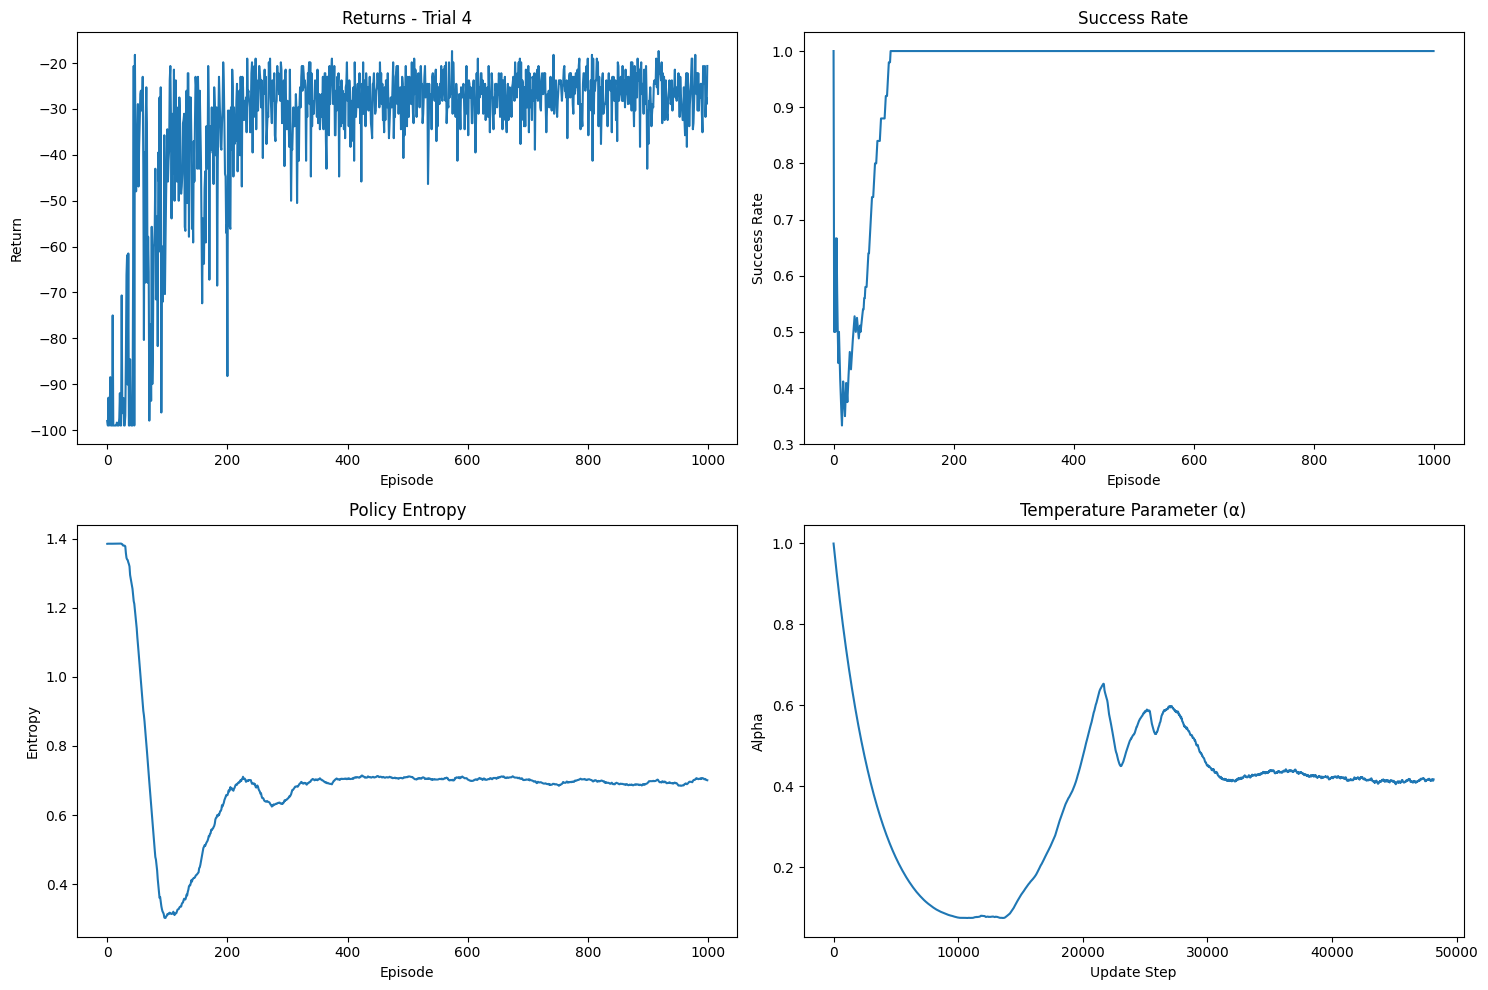


Trial 5/5


Ep:100 | R:-37.6 | AvgR:-64.9 | Succ:78.0% | Len:193.8 | α:0.107 | H:0.33:  10%|█         | 101/1000 [01:19<04:13,  3.55it/s]


Episode 100 Statistics:
Episode Return: -37.65
Average Return (100 ep): -64.87 ± 29.33
Success Rate (100 ep): 78.0%
Average Episode Length: 193.8
Evaluation Return: -66.80
Evaluation Success Rate: 100.0%
Average Q-Value: -15.50
Policy Entropy: 0.793
Alpha: 0.107
Policy Loss: 29.931
Q Loss: 1.593
--------------------------------------------------


Ep:201 | R:-27.5 | AvgR:-34.2 | Succ:100.0% | Len:44.5 | α:0.389 | H:0.54:  20%|██        | 202/1000 [01:41<02:33,  5.21it/s]


Episode 200 Statistics:
Episode Return: -24.53
Average Return (100 ep): -34.23 ± 11.88
Success Rate (100 ep): 100.0%
Average Episode Length: 44.6
Evaluation Return: -22.60
Evaluation Success Rate: 100.0%
Average Q-Value: -23.13
Policy Entropy: 0.383
Alpha: 0.385
Policy Loss: 25.613
Q Loss: 2.669
--------------------------------------------------


Ep:300 | R:-23.8 | AvgR:-29.7 | Succ:100.0% | Len:38.2 | α:0.884 | H:0.69:  30%|███       | 301/1000 [02:00<02:13,  5.22it/s]


Episode 300 Statistics:
Episode Return: -23.77
Average Return (100 ep): -29.69 ± 11.23
Success Rate (100 ep): 100.0%
Average Episode Length: 38.2
Evaluation Return: -26.00
Evaluation Success Rate: 100.0%
Average Q-Value: -17.95
Policy Entropy: 0.522
Alpha: 0.884
Policy Loss: 14.973
Q Loss: 2.151
--------------------------------------------------


Ep:401 | R:-28.2 | AvgR:-29.1 | Succ:100.0% | Len:35.4 | α:0.550 | H:0.64:  40%|████      | 402/1000 [02:18<01:40,  5.95it/s]


Episode 400 Statistics:
Episode Return: -29.66
Average Return (100 ep): -29.19 ± 5.02
Success Rate (100 ep): 100.0%
Average Episode Length: 35.6
Evaluation Return: -24.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.97
Policy Entropy: 0.751
Alpha: 0.552
Policy Loss: 10.892
Q Loss: 0.445
--------------------------------------------------


Ep:500 | R:-31.1 | AvgR:-26.5 | Succ:100.0% | Len:31.8 | α:0.459 | H:0.71:  50%|█████     | 501/1000 [02:34<01:21,  6.10it/s]


Episode 500 Statistics:
Episode Return: -31.06
Average Return (100 ep): -26.48 ± 4.21
Success Rate (100 ep): 100.0%
Average Episode Length: 31.8
Evaluation Return: -24.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.52
Policy Entropy: 0.708
Alpha: 0.459
Policy Loss: 10.861
Q Loss: 0.367
--------------------------------------------------


Ep:601 | R:-24.5 | AvgR:-27.7 | Succ:100.0% | Len:33.5 | α:0.454 | H:0.77:  60%|██████    | 602/1000 [02:51<00:55,  7.23it/s]


Episode 600 Statistics:
Episode Return: -22.22
Average Return (100 ep): -27.85 ± 5.56
Success Rate (100 ep): 100.0%
Average Episode Length: 33.8
Evaluation Return: -23.60
Evaluation Success Rate: 100.0%
Average Q-Value: -11.19
Policy Entropy: 0.710
Alpha: 0.453
Policy Loss: 11.136
Q Loss: 0.383
--------------------------------------------------


Ep:701 | R:-32.4 | AvgR:-27.1 | Succ:100.0% | Len:32.7 | α:0.454 | H:0.71:  70%|███████   | 702/1000 [03:07<00:50,  5.88it/s]


Episode 700 Statistics:
Episode Return: -30.36
Average Return (100 ep): -27.06 ± 4.39
Success Rate (100 ep): 100.0%
Average Episode Length: 32.6
Evaluation Return: -24.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.96
Policy Entropy: 0.702
Alpha: 0.454
Policy Loss: 10.808
Q Loss: 0.368
--------------------------------------------------


Ep:801 | R:-28.2 | AvgR:-26.6 | Succ:100.0% | Len:31.9 | α:0.444 | H:0.51:  80%|████████  | 802/1000 [03:23<00:33,  5.96it/s]


Episode 800 Statistics:
Episode Return: -26.77
Average Return (100 ep): -26.61 ± 4.67
Success Rate (100 ep): 100.0%
Average Episode Length: 32.0
Evaluation Return: -23.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.82
Policy Entropy: 0.690
Alpha: 0.441
Policy Loss: 10.823
Q Loss: 0.355
--------------------------------------------------


Ep:901 | R:-31.7 | AvgR:-27.5 | Succ:100.0% | Len:33.2 | α:0.437 | H:0.79:  90%|█████████ | 902/1000 [03:40<00:17,  5.67it/s]


Episode 900 Statistics:
Episode Return: -20.64
Average Return (100 ep): -27.45 ± 5.15
Success Rate (100 ep): 100.0%
Average Episode Length: 33.2
Evaluation Return: -23.20
Evaluation Success Rate: 100.0%
Average Q-Value: -11.04
Policy Entropy: 0.699
Alpha: 0.438
Policy Loss: 10.833
Q Loss: 0.365
--------------------------------------------------


Ep:999 | R:-25.3 | AvgR:-27.4 | Succ:100.0% | Len:33.0 | α:0.431 | H:0.64: 100%|██████████| 1000/1000 [03:56<00:00,  4.22it/s]


append to all_returns


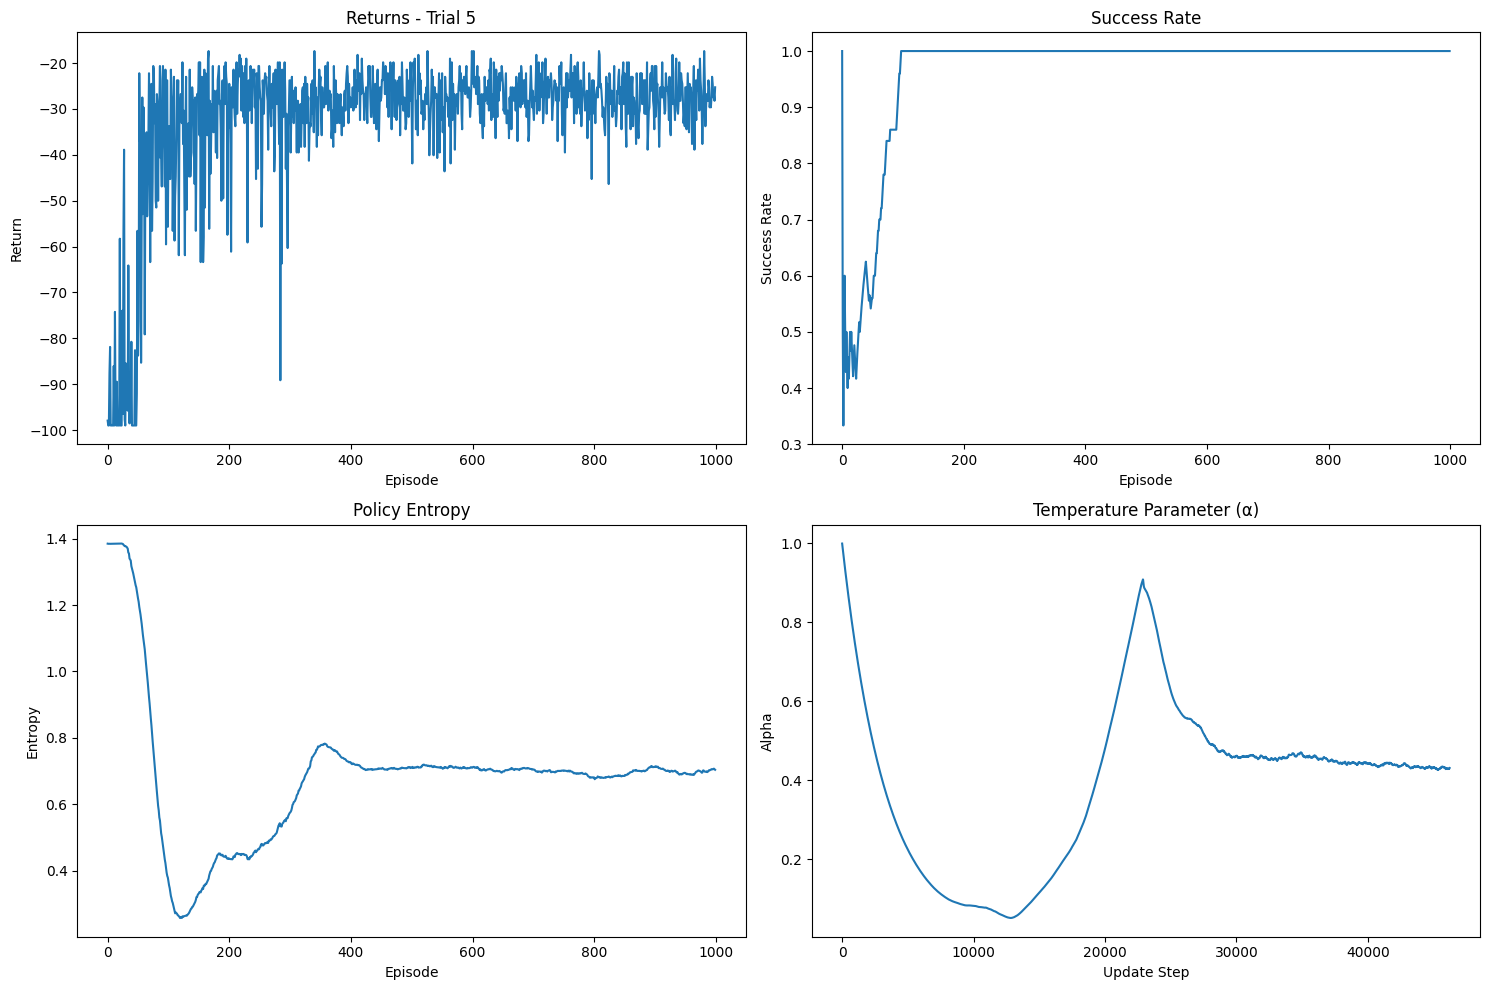

In [126]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt

# Replay buffer transition tuple
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, capacity, state_dim=3, device="cpu"):
        self.capacity = capacity
        self.device = device
        self.memory = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).to(self.device)
        action = torch.tensor([action], dtype=torch.long).to(self.device)
        reward = torch.tensor([reward], dtype=torch.float32).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.tensor([done], dtype=torch.float32).to(self.device)
        
        transition = Transition(state, action, reward, next_state, done)
        
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size)
        transitions = [self.memory[idx] for idx in indices]
        batch = Transition(*zip(*transitions))
        
        states = torch.stack(batch.state)
        actions = torch.stack(batch.action)
        rewards = torch.stack(batch.reward)
        next_states = torch.stack(batch.next_state)
        dones = torch.stack(batch.done)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, state):
        return self.net(state)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, state):
        return self.net(state)

class SACAgent:
    def __init__(self, state_dim=3, action_dim=4, hidden_dim=256,
                 lr=3e-4, gamma=0.99, tau=0.005,
                 batch_size=256, device="cpu"):
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.batch_size = batch_size
        self.action_dim = action_dim
        
        # Networks
        self.critic1 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.actor = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
        
        # Copy target parameters
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # Optimizers with eps like reference
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr, eps=1e-4)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr, eps=1e-4)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, eps=1e-4)
        
        # Entropy tuning matching reference
        self.target_entropy = -np.log((1.0 / action_dim)) * 0.5 
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr, eps=1e-4)
        
    @property
    def alpha(self):
        return self.log_alpha.exp()
    
    def get_action(self, state, evaluate=False):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action_probs = self.actor(state)
            if evaluate:
                action = torch.argmax(action_probs, dim=-1)
            else:
                dist = Categorical(action_probs)
                action = dist.sample()
            return action.item()
    
    def calculate_critic_losses(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with torch.no_grad():
            next_action_probs = self.actor(next_state_batch)
            # Handle zero probabilities exactly like reference
            z = next_action_probs == 0.0
            z = z.float() * 1e-8
            log_next_action_probs = torch.log(next_action_probs + z)
            
            next_q1 = self.critic1_target(next_state_batch)
            next_q2 = self.critic2_target(next_state_batch)
            
            # Matching reference implementation exactly
            min_qf_next_target = next_action_probs * (
                torch.min(next_q1, next_q2) - self.alpha * log_next_action_probs
            )
            min_qf_next_target = min_qf_next_target.sum(dim=1).unsqueeze(-1)
            next_q_value = reward_batch + (1 - done_batch) * self.gamma * min_qf_next_target

        q1 = self.critic1(state_batch).gather(1, action_batch.long())
        q2 = self.critic2(state_batch).gather(1, action_batch.long())
        
        critic1_loss = F.mse_loss(q1, next_q_value)
        critic2_loss = F.mse_loss(q2, next_q_value)
        
        return critic1_loss, critic2_loss

    def calculate_actor_loss(self, state_batch):
        action_probs = self.actor(state_batch)
        # Handle zero probabilities
        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probs = torch.log(action_probs + z)
        
        q1 = self.critic1(state_batch)
        q2 = self.critic2(state_batch)
        min_q = torch.min(q1, q2).detach()
        
        # Matching reference implementation
        inside_term = self.alpha * log_action_probs - min_q
        policy_loss = (action_probs * inside_term).sum(dim=1).mean()
        log_action_probs = torch.sum(log_action_probs * action_probs, dim=1)
        
        return policy_loss, log_action_probs
    # Standard Four Rooms SAC Update Method
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, total_steps, freq_update_target):
        """Standard SAC update for Four Rooms"""
        # Get gradients before updates
        pre_grad_stats = track_grad_stats(self)
        
        # Critic update
        critic1_loss, critic2_loss = self.calculate_critic_losses(
            state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        
        # Actor update
        policy_loss, log_probs = self.calculate_actor_loss(state_batch)
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        
        # Alpha update 
        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Target update
        if total_steps % freq_update_target == 0:
            for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
                
        return pre_grad_stats, {
            'critic1_loss': critic1_loss.item(),
            'critic2_loss': critic2_loss.item(),
            'policy_loss': policy_loss.item(),
            'alpha': self.alpha.item()
    }
def evaluate_policy(env, agent, num_episodes=5):
    """Runs policy evaluation episodes."""
    eval_returns = []
    eval_successes = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]
        episode_return = 0
        done = False
        reached_goal = False

        while not done:
            action = agent.get_action(state_features, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reached_goal = True

            episode_return += reward
            state = next_state
            state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]

        eval_returns.append(episode_return)
        eval_successes.append(float(reached_goal))

    # Return all evaluation returns and successes for further processing
    return np.array(eval_returns), np.array(eval_successes)


def train_sac_trials(num_trials=10, num_episodes=10000, smoothing=True):
    """Run multiple trials with detailed logging"""
    all_returns = []
    all_losses = []
    eval_returns_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episodes
    eval_success_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episodes
    all_grad_metrics = []
    
    training_params = {
        'num_episodes': num_episodes,
        'batch_size': 256,
        'buffer_size': 10_000,
        'learning_rate': 3e-4,
        'hidden_dim': 256,
        'gamma': 0.99,
        'tau': 0.005,
        'min_steps_before_learning': 5000,
        "freq_update_target": 1,
        "updates_per_step": 1, 
        "steps_per_update": 1
    }
    
    for trial in range(num_trials):
        print(f"\nTrial {trial + 1}/{num_trials}")
        
        # Set seeds
        torch.manual_seed(trial)
        np.random.seed(trial)
        
        env = FourRooms()
        eval_env = FourRooms()
        agent = SACAgent()
        buffer = ReplayBuffer(training_params['buffer_size'])
        
        # Training metrics
        trial_returns = []
        episode_lengths = []
        q_values = []
        entropies = []
        alphas = []
        policy_losses = []
        q_losses = []
        success_rate = []
        grad_metrics = {
            'actor_grad_mag': [],
            'critic1_grad_mag': [],
            'critic2_grad_mag': [],
            'total_grad_mag': []
        }
        
        total_steps = 0
        pbar = tqdm.trange(training_params['num_episodes'])
        
        for episode in pbar:
            state, _ = env.reset()
            episode_rewards = []
            episode_length = 0
            episode_q_values = []
            episode_entropies = []
            
            done = False
            reached_goal = False
            
            while not done:
                # Get state features and action
                state_features = [state[0]/10.0, state[1]/10.0, 1.0]
                state_tensor = torch.FloatTensor(state_features).unsqueeze(0).to(agent.device)
                
                # Get action and log metrics
                with torch.no_grad():
                    probs = agent.actor(state_tensor)
                    q1 = agent.critic1(state_tensor)
                    q2 = agent.critic2(state_tensor)
                    episode_q_values.append(torch.max(torch.min(q1, q2)).item())
                    entropy = -(probs * torch.log(probs + 1e-8)).sum(1).item()
                    episode_entropies.append(entropy)
                
                action = agent.get_action(state_features)
                
                # Environment step
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                if terminated:
                    reached_goal = True
                
                next_state_features = [next_state[0]/10.0, next_state[1]/10.0, 1.0]
                
                # Store transition
                buffer.push(state_features, action, reward, next_state_features, done)
                
                            # Update if enough samples
                if total_steps > training_params['min_steps_before_learning'] and len(buffer) >= training_params['batch_size'] and total_steps % training_params['steps_per_update'] == 0:
                    for _ in range(training_params["updates_per_step"]):
                        batch = buffer.sample(training_params['batch_size'])
                        grad_stats, loss_dict = agent.update(*batch, total_steps, training_params["freq_update_target"])

                        for key, value in grad_stats.items():
                            grad_metrics[key].append(value)
                        
                        
                        policy_losses.append(loss_dict['policy_loss'])
                        q_losses.append((loss_dict['critic1_loss'] + loss_dict['critic2_loss']) / 2)
                        alphas.append(loss_dict['alpha'])
                        
                episode_rewards.append(reward)
                episode_length += 1
                total_steps += 1
                state = next_state
            
            # Compute total discounted return for the episode
            G = 0
            for r in reversed(episode_rewards):
                G = r + training_params['gamma'] * G
            episode_return = G  # Total discounted return for the episode
            
            # Store the episode return
            #print(episode_return)
            #print("append to trial_returns")
            trial_returns.append(episode_return)
            episode_lengths.append(episode_length)
            success_rate.append(float(reached_goal))
            
            if episode_q_values:
                q_values.append(np.mean(episode_q_values))
            if episode_entropies:
                entropies.append(np.mean(episode_entropies))
            
            # Update progress bar with per-episode return
            current_return = trial_returns[-1]
            avg_return = np.mean(trial_returns[-100:]) if len(trial_returns) >= 100 else np.mean(trial_returns)
            avg_success = np.mean(success_rate[-100:]) * 100 if len(success_rate) >= 100 else np.mean(success_rate) * 100
            avg_length = np.mean(episode_lengths[-100:]) if len(episode_lengths) >= 100 else np.mean(episode_lengths)
            
            current_alpha = alphas[-1] if alphas else 0
            current_entropy = entropies[-1] if entropies else 0
            
            desc = f"Ep:{episode} | R:{current_return:.1f} | AvgR:{avg_return:.1f} | Succ:{avg_success:.1f}% | Len:{avg_length:.1f}"
            if alphas:
                desc += f" | α:{current_alpha:.3f}"
            if entropies:
                desc += f" | H:{current_entropy:.2f}"
            
            pbar.set_description(desc)
            
            # Periodically print detailed stats
            if episode % 100 == 0 and episode > 0:
                eval_returns, eval_successes = evaluate_policy(eval_env, agent)
                # Store raw evaluation returns and successes
                eval_idx = episode // 100
                eval_returns_array[trial, eval_idx] = eval_returns
                eval_success_array[trial, eval_idx] = eval_successes

                stats = f"\nEpisode {episode} Statistics:"
                stats += f"\nEpisode Return: {current_return:.2f}"
                stats += f"\nAverage Return (100 ep): {np.mean(trial_returns[-100:]):.2f} ± {np.std(trial_returns[-100:]):.2f}"
                stats += f"\nSuccess Rate (100 ep): {np.mean(success_rate[-100:]) * 100:.1f}%"
                stats += f"\nAverage Episode Length: {np.mean(episode_lengths[-100:]):.1f}"
                # add evaluation stats
                stats += f"\nEvaluation Return: {np.mean(eval_returns):.2f}"
                stats += f"\nEvaluation Success Rate: {(np.mean(eval_successes)*100):.1f}%"
                if q_values:
                    stats += f"\nAverage Q-Value: {np.mean(q_values[-100:]):.2f}"
                if entropies:
                    stats += f"\nPolicy Entropy: {np.mean(entropies[-100:]):.3f}"
                if alphas:
                    stats += f"\nAlpha: {alphas[-1]:.3f}"
                if policy_losses:
                    stats += f"\nPolicy Loss: {np.mean(policy_losses[-100:]):.3f}"
                if q_losses:
                    stats += f"\nQ Loss: {np.mean(q_losses[-100:]):.3f}"
                stats += "\n" + "-" * 50
                pbar.write(stats)
        
        # Store trial results
        print("append to all_returns")
        all_returns.append(trial_returns)
        all_grad_metrics.append(grad_metrics)
        all_losses.append({
            'policy_loss': policy_losses,
            'q_loss': q_losses,
            'alpha': alphas
        })
        
        if len(trial_returns) > 0:
            plt.figure(figsize=(15, 10))
            
            # Plot returns
            plt.subplot(2, 2, 1)
            plt.plot(trial_returns)
            plt.title(f'Returns - Trial {trial+1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            
            # Plot success rate
            plt.subplot(2, 2, 2)
            plt.plot(moving_average(np.array(success_rate)) if smoothing else success_rate)
            plt.title('Success Rate')
            plt.xlabel('Episode')
            plt.ylabel('Success Rate')
            
            # Plot entropy if we have it
            if entropies:
                plt.subplot(2, 2, 3)
                plt.plot(moving_average(np.array(entropies)) if smoothing else entropies)
                plt.title('Policy Entropy')
                plt.xlabel('Episode')
                plt.ylabel('Entropy')
            
            # Plot alpha if we have it
            if alphas:
                plt.subplot(2, 2, 4)
                plt.plot(alphas)
                plt.title('Temperature Parameter (α)')
                plt.xlabel('Update Step')
                plt.ylabel('Alpha')
            
            plt.tight_layout()
            plt.show()
    
    return all_returns, eval_returns_array, eval_success_array, all_losses, all_grad_metrics, agent


# Run training
returns, eval_returns, eval_success, losses, grad_metrics, agent = train_sac_trials(num_trials=5, num_episodes=1000)

In [ ]:
returns = np.array(returns)
plot_curves([returns], ['SAC'], ['b'], 'Discounted Returns', 'SAC traning returns - FourRooms', smoothing=True)

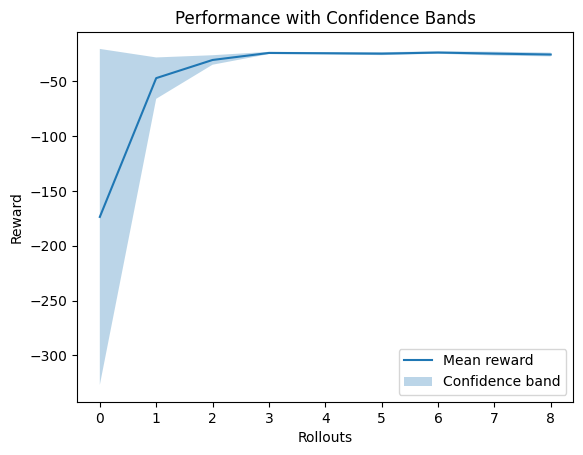

In [120]:
#plot ema eval returns
eval_returns = np.array(eval_returns)
eval_returns = eval_returns[:, 1:-1, :]
import numpy as np
import matplotlib.pyplot as plt

# assuming `arr` is your (5, 9, 5) array

# average across episodes for each trial and rollout
mean_values = np.mean(eval_returns, axis=2)  # shape: (5, 9)
std_values = np.std(eval_returns, axis=2)    # shape: (5, 9)

# average across trials
mean_across_trials = np.mean(mean_values, axis=0)  # shape: (9,)
std_across_trials = np.std(mean_values, axis=0)    # shape: (9,)

# plot
x = np.arange(mean_across_trials.shape[0])  # rollouts

plt.plot(x, mean_across_trials, label="Mean reward")
plt.fill_between(x, mean_across_trials - std_across_trials,
                 mean_across_trials + std_across_trials, alpha=0.3, label="Confidence band")
plt.xlabel("Rollouts")
plt.ylabel("Reward")
plt.legend()
plt.title("Performance with Confidence Bands")
plt.show()


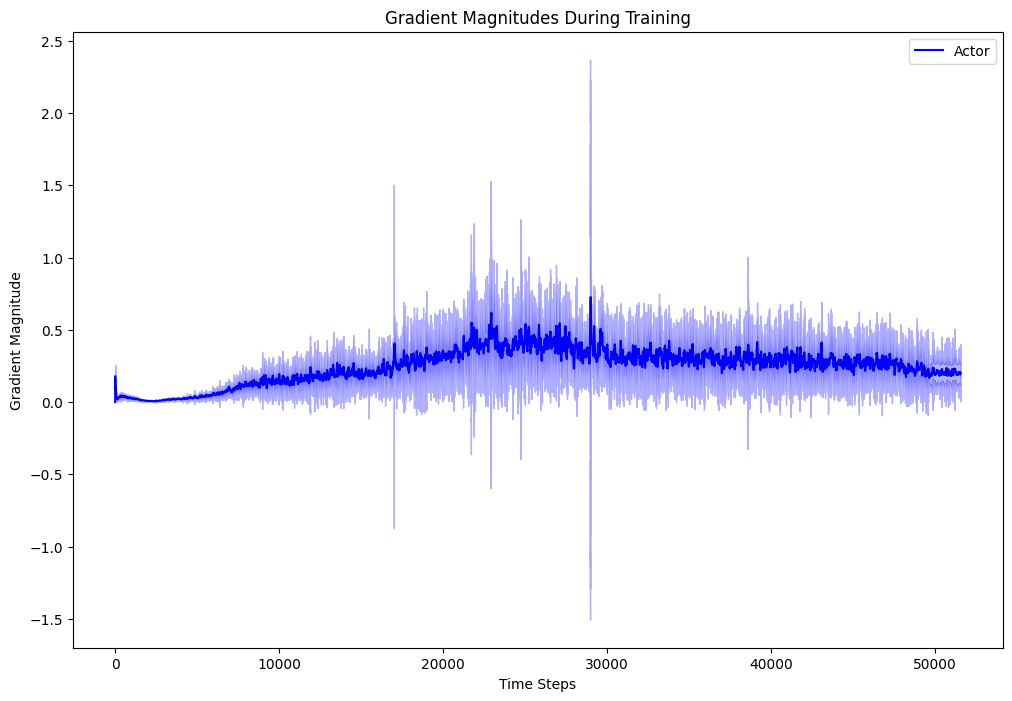

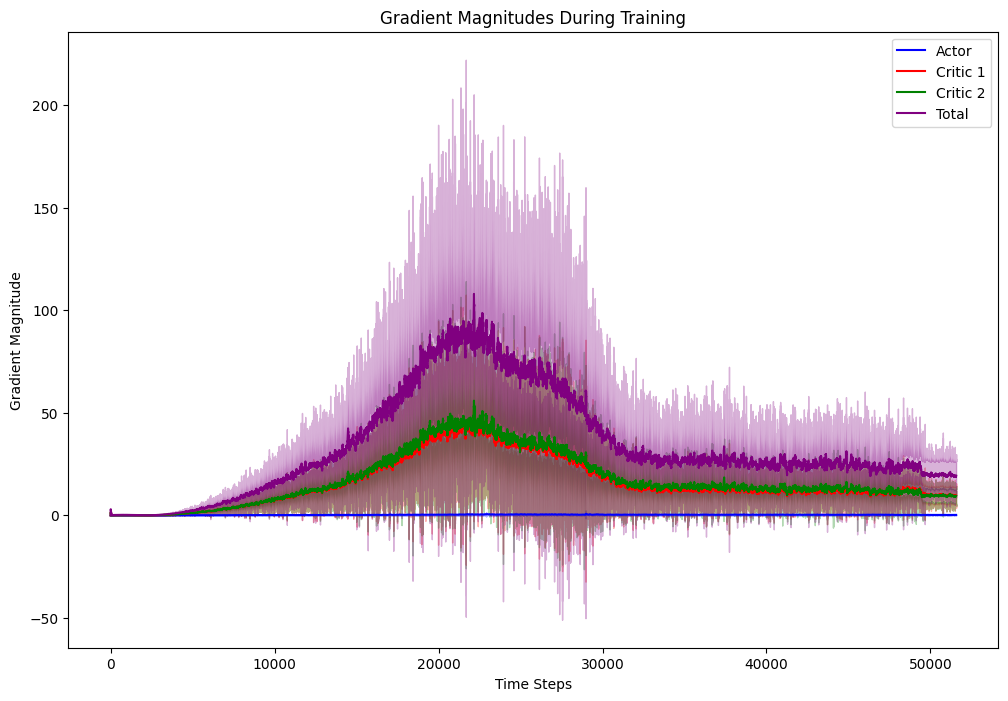

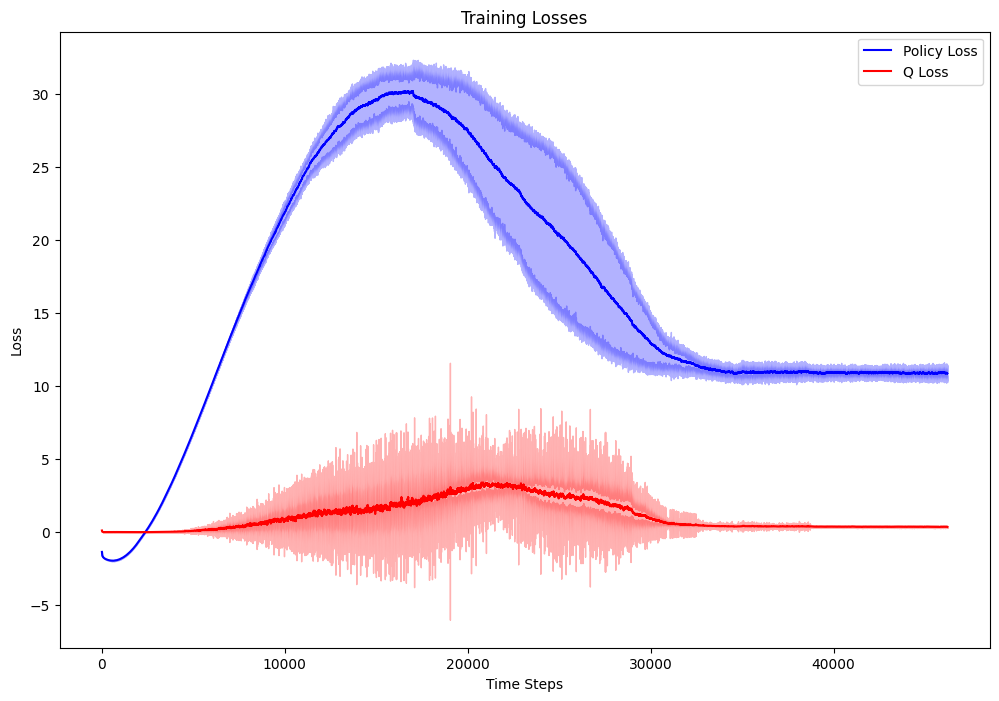

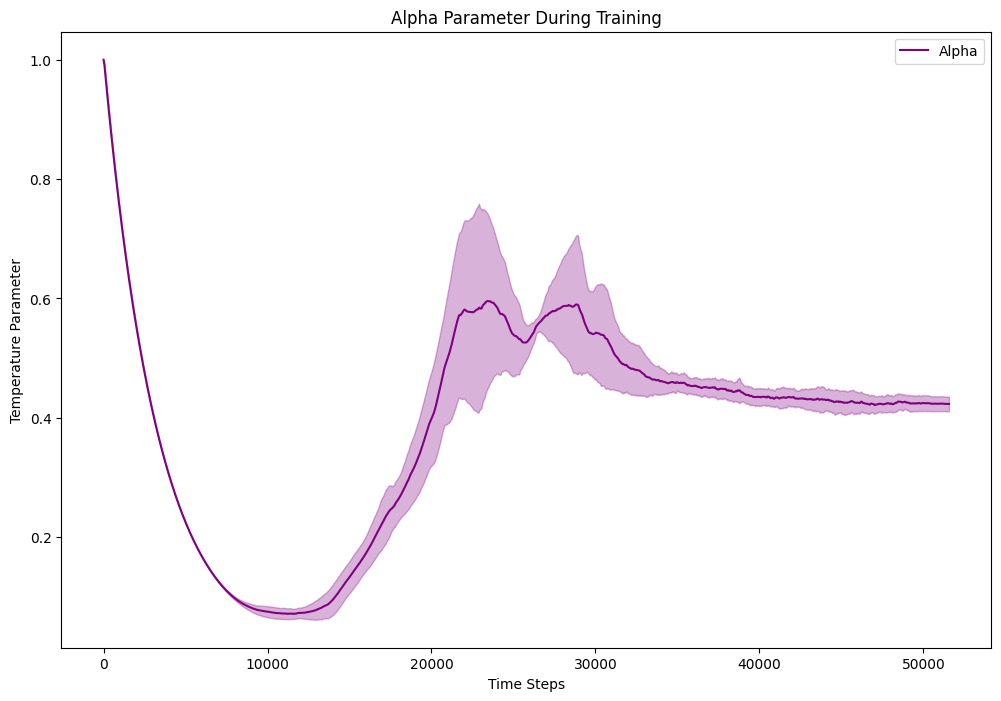

In [173]:
plot_training_metrics(grad_metrics, losses)


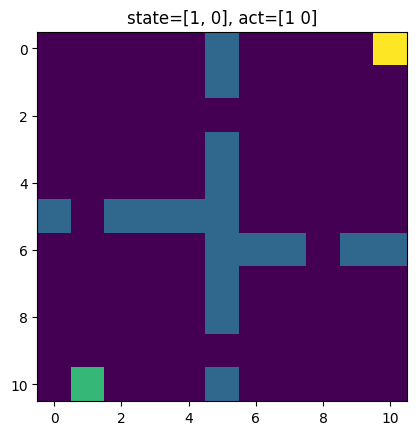

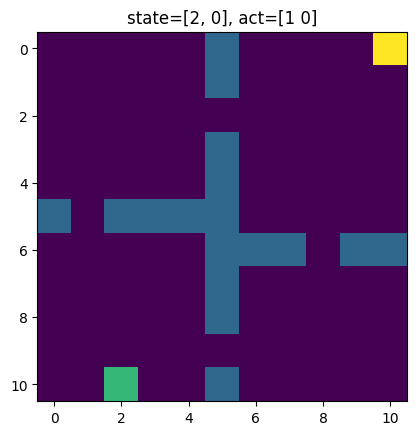

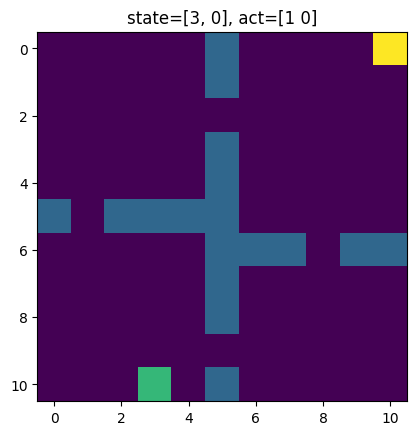

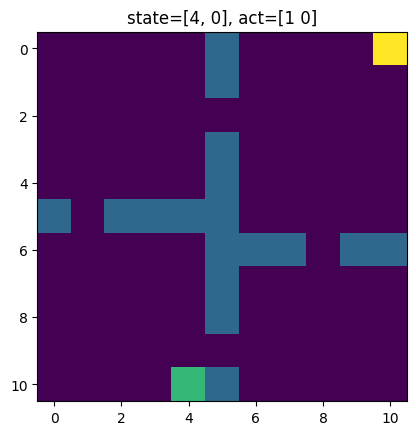

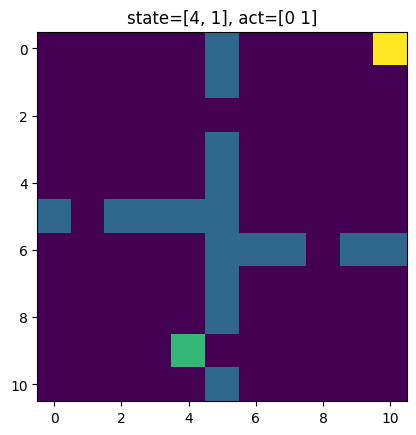

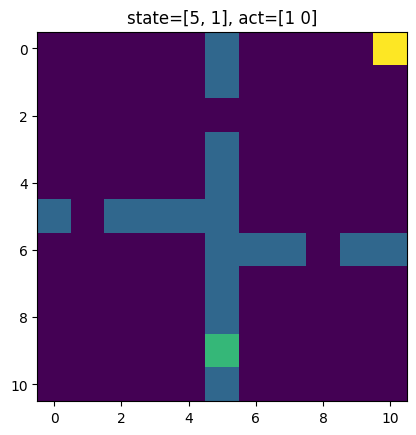

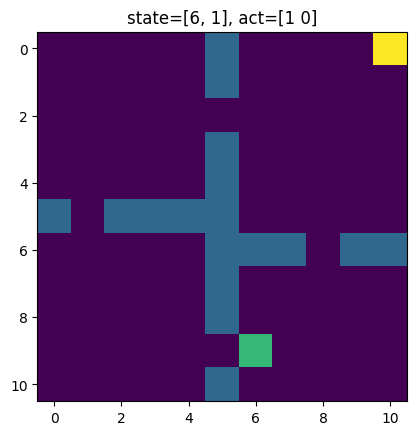

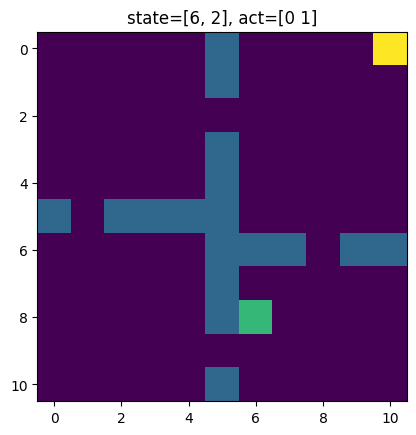

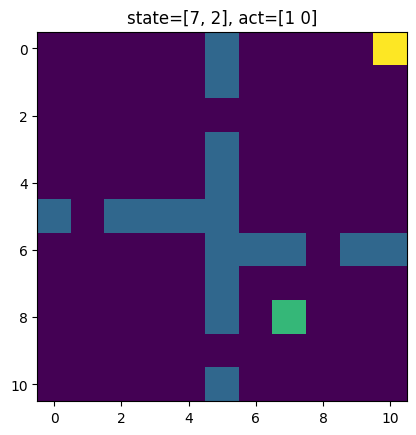

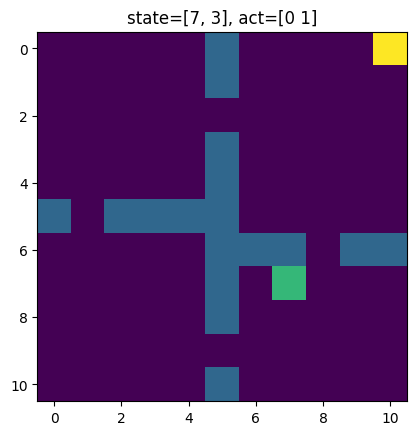

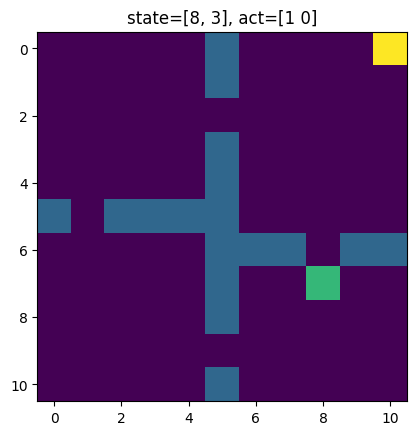

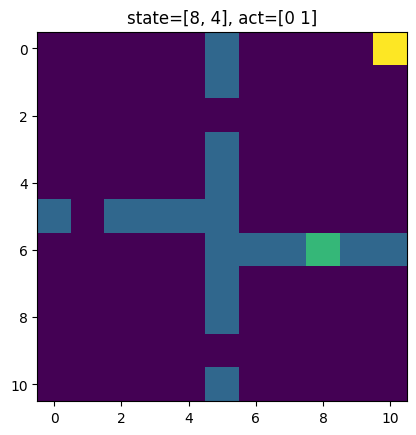

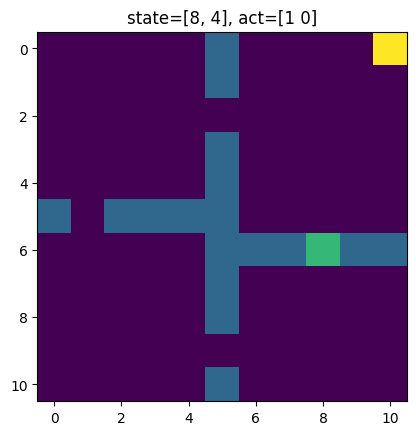

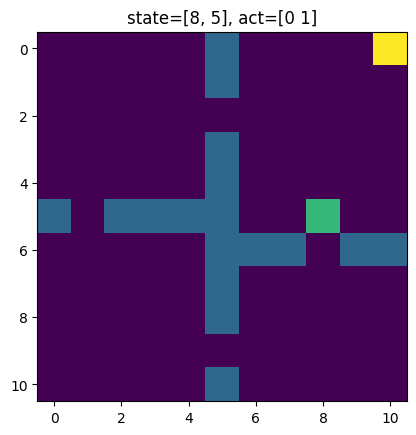

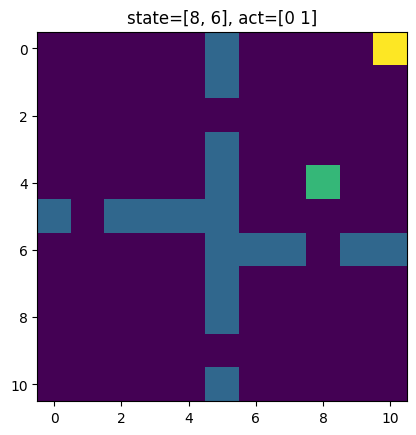

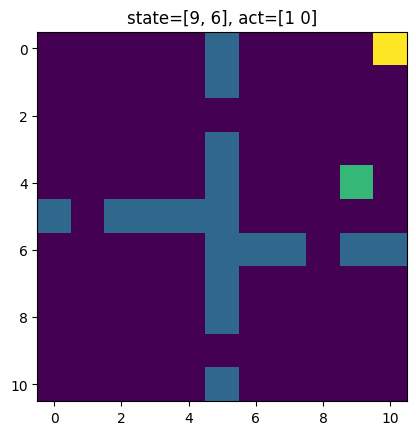

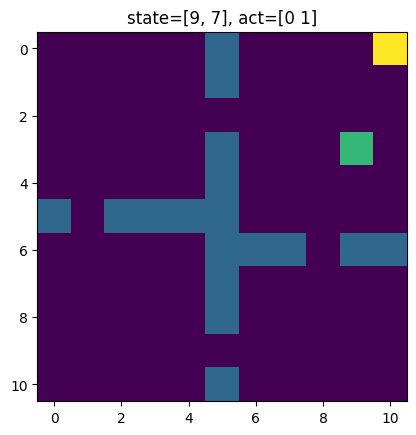

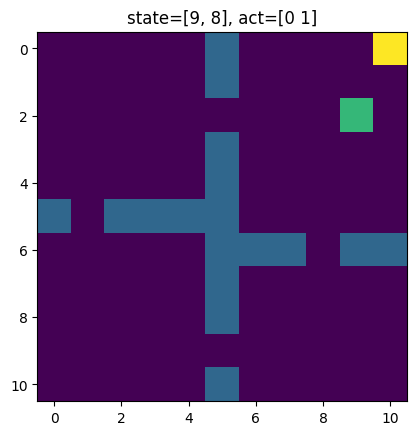

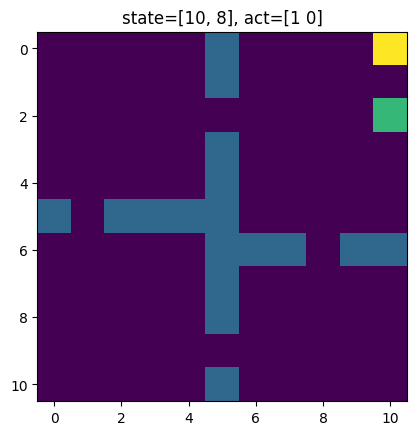

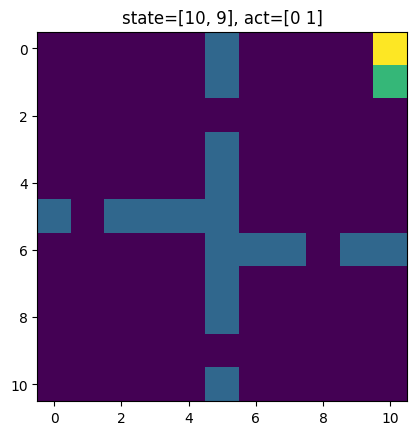

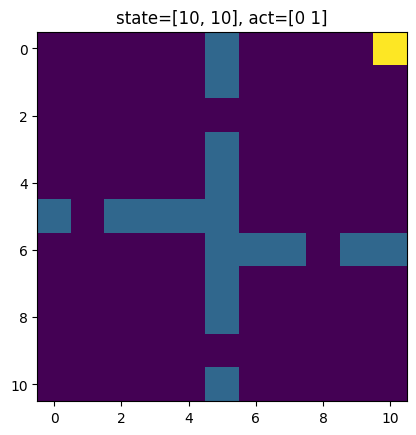

Episode finished after 21 timesteps


In [ ]:
# check the agent
env = FourRooms()
state, _ = env.reset()
done = False
t = 0
while not done:
    action = agent.get_action([state[0] / 10, state[1] / 10, 1], evaluate=True)
    state, _, done, _, _ = env.step(action) 
    env.render()
    t += 1
print(f"Episode finished after {t} timesteps")

In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
from collections import deque
from tqdm import tqdm
import gymnasium as gym
import os
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

# ----------------------------- Replay Buffer ----------------------------- #

class ReplayBuffer:
    def __init__(self, capacity, batch_size, state_dim, device):
        self.capacity = capacity
        self.batch_size = batch_size
        self.device = device
        self.ptr = 0
        self.size = 0

        # Preallocate tensors for efficiency
        self.states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.actions = torch.zeros((capacity, 1), dtype=torch.long, device=device)
        self.rewards = torch.zeros((capacity, 1), dtype=torch.float32, device=device)
        self.next_states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.dones = torch.zeros((capacity, 1), dtype=torch.float32, device=device)

    def add(self, state, action, reward, next_state, done):
        self.states[self.ptr] = torch.from_numpy(state).float()
        self.actions[self.ptr] = torch.tensor([action], dtype=torch.long)
        self.rewards[self.ptr] = torch.tensor([reward], dtype=torch.float32)
        self.next_states[self.ptr] = torch.from_numpy(next_state).float()
        self.dones[self.ptr] = torch.tensor([done], dtype=torch.float32)

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self):
        indices = torch.randint(0, self.size, (self.batch_size,), device=self.device)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.size

# ----------------------------- Networks ----------------------------- #

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)
        
    def get_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(next(self.parameters()).device)
        probs = self.forward(state)
        dist = Categorical(probs)
        if evaluate:
            action = torch.argmax(probs, dim=-1)
        else:  
            action = dist.sample()
        return action.item()

class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class SACAgentLunar:
    def __init__(self, state_dim, action_dim, hidden_dim=256, lr=3e-4, gamma=0.99, tau=0.005, device="cpu", initial_alpha=0.2):
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.action_dim = action_dim
        
        # Initialize networks
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.critic1 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        
        # Copy parameters to targets
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # Initialize optimizers with proper hyperparameters
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, eps=1e-4)
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr, eps=1e-4)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr, eps=1e-4)
        
        # Initialize temperature parameter with alpha=0.2
        self.target_entropy = 0.6 * (-np.log(1 / action_dim))  # Target entropy
        self.log_alpha = torch.tensor(np.log(initial_alpha), dtype=torch.float32, requires_grad=True, device=device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr, eps=1e-4)
        self.alpha = self.log_alpha.exp().item()
        self.H_mean = 0  # Track entropy
        
    @property
    def alpha_value(self):
        return self.log_alpha.exp().item()
    
    def get_action(self, state, evaluate=False):
        return self.actor.get_action(state, evaluate)
    
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        """Standard SAC update for Lunar Lander"""
        # Get gradients before updates
        pre_grad_stats = track_grad_stats(self)
        
        with torch.no_grad():
            next_probs = self.actor(next_state_batch)
            next_log_probs = torch.log(next_probs + 1e-8)
            q1_next = self.critic1_target(next_state_batch)
            q2_next = self.critic2_target(next_state_batch)
            min_q_next = torch.min(q1_next, q2_next)
            target_q = (next_probs * (min_q_next - self.alpha * next_log_probs)).sum(dim=1, keepdim=True)
            target_q = reward_batch + (1 - done_batch) * self.gamma * target_q
        
        # Critic updates
        current_q1 = self.critic1(state_batch).gather(1, action_batch)
        current_q2 = self.critic2(state_batch).gather(1, action_batch)
        
        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        

        # Actor update (policy loss)
        probs = self.actor(state_batch)
        log_probs = torch.log(probs + 1e-8)
        q1 = self.critic1(state_batch).detach()  # [batch, action_dim]
        q2 = self.critic2(state_batch).detach()  # [batch, action_dim]
        min_q = torch.min(q1, q2)
        actor_loss = (probs * (self.alpha * log_probs - min_q)).sum(dim=1).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Alpha update
        with torch.no_grad():
            self.H_mean = -(probs * log_probs).sum(dim=1).mean()
            
        alpha_loss = self.log_alpha * (self.H_mean - self.target_entropy)
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Update alpha value
        self.alpha = self.alpha_value

        # Soft update targets
        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)
        
        return pre_grad_stats, {
            'critic1_loss': critic1_loss.item(),
            'critic2_loss': critic2_loss.item(),
            'actor_loss': actor_loss.item(),
            'alpha': self.alpha
        }
    
    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
    
    def save(self, timestep, EnvName):
        os.makedirs("models", exist_ok=True)
        torch.save(self.actor.state_dict(), f"./models/sacd_actor_{timestep}_{EnvName}.pth")
        torch.save(self.critic1.state_dict(), f"./models/sacd_critic1_{timestep}_{EnvName}.pth")
        torch.save(self.critic2.state_dict(), f"./models/sacd_critic2_{timestep}_{EnvName}.pth")
    
    def load(self, timestep, EnvName):
        self.actor.load_state_dict(torch.load(f"./models/sacd_actor_{timestep}_{EnvName}.pth", map_location=self.device))
        self.critic1.load_state_dict(torch.load(f"./models/sacd_critic1_{timestep}_{EnvName}.pth", map_location=self.device))
        self.critic2.load_state_dict(torch.load(f"./models/sacd_critic2_{timestep}_{EnvName}.pth", map_location=self.device))

# ----------------------------- Training and Evaluation ----------------------------- #

def compute_discounted_return(rewards, gamma):
    """Compute the discounted return by iterating backwards through the rewards."""
    discounted_return = 0.0
    for r in reversed(rewards):
        discounted_return = r + gamma * discounted_return
    return discounted_return

def evaluate_agent(env, agent, num_episodes=5, gamma=0.99):
    """Evaluate agent with both sum of rewards and discounted returns."""
    agent.actor.eval()
    sum_returns = []
    discounted_returns = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0.0
        episode_rewards = []
        while not done:
            action = agent.get_action(state, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            episode_rewards.append(reward)
            state = next_state
        sum_returns.append(total_reward)
        discounted_returns.append(compute_discounted_return(episode_rewards, gamma))
    agent.actor.train()
    return np.mean(sum_returns), np.mean(discounted_returns)

def set_seed(seed, env):
    """Set seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.reset(seed=seed)

def train_sac_lunar(num_trials=5, num_steps=400_000, buffer_capacity=1_000_000, batch_size=256,
                   prepopulate_steps=10_000, eval_interval=10, num_eval_episodes=5, gamma=0.99, steps_per_update=50, updates_per_step=50):
    """Run multiple trials for Lunar Lander with standard SAC"""
    all_returns = []
    all_disc_returns = []
    all_eval_returns = []
    all_eval_disc = []
    all_losses = []
    all_grad_metrics = []
    
    for trial in range(num_trials):
        print(f"\nTrial {trial + 1}/{num_trials}")
        
        # Set seeds
        seed = trial
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        env = gym.make("LunarLander-v2")
        eval_env = gym.make("LunarLander-v2")
        env.reset(seed=seed)
        eval_env.reset(seed=seed+1000)

        best_eval_return = float('-inf')
        
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        agent = SACAgentLunar(state_dim, action_dim, hidden_dim=200, lr=3e-4,
                           gamma=gamma, tau=0.005, device=device, initial_alpha=0.2)
        buffer = ReplayBuffer(buffer_capacity, batch_size, state_dim, device)
        
        returns = deque(maxlen=100)
        returns_over_steps = []  # For storing all returns
        discounted_returns = []
        eval_returns_sum = []
        eval_returns_discounted = []
        policy_losses = []
        q_losses = []
        alphas = []
        grad_metrics = {
            'actor_grad_mag': [],
            'critic1_grad_mag': [],
            'critic2_grad_mag': [],
            'total_grad_mag': []
        }
        
        # Prepopulate buffer
        state, _ = env.reset()
        pbar = tqdm(range(prepopulate_steps), desc="Prepopulating buffer")
        for _ in pbar:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if reward <= -100:
                reward = -10.0
            
            buffer.add(state, action, reward, next_state, done)
            
            if done:
                state, _ = env.reset()
            else:
                state = next_state
        
        # Training loop
        total_steps = 0
        episode = 0
        state, _ = env.reset()
        episode_rewards = []
        
        pbar = tqdm(range(num_steps), desc=f"Training Trial {trial+1}")
        for step in pbar:
            total_steps += 1
            
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_rewards.append(reward)
            
            if reward <= -100:
                reward = -10.0
            
            buffer.add(state, action, reward, next_state, done)
            
            if len(buffer) >= batch_size and total_steps % steps_per_update == 0:
                for _ in range(updates_per_step):
                    grad_stats, loss_dict = agent.update(*buffer.sample())
                
                    for key, value in grad_stats.items():
                        grad_metrics[key].append(value)
                    
                    policy_losses.append(loss_dict['actor_loss'])
                    q_losses.append((loss_dict['critic1_loss'] + loss_dict['critic2_loss']) / 2)
                    alphas.append(loss_dict['alpha'])
            
            if done:
                sum_return = sum(episode_rewards)
                discounted_return = compute_discounted_return(episode_rewards, gamma)
                
                returns.append(sum_return)
                returns_over_steps.append(sum_return)
                discounted_returns.append(discounted_return)
                episode_rewards = []
                state, _ = env.reset()
                episode += 1
                
                if episode % eval_interval == 0:
                    eval_return_sum, eval_return_disc = evaluate_agent(eval_env, agent, num_eval_episodes, gamma)
                    eval_returns_sum.append(eval_return_sum)
                    eval_returns_discounted.append(eval_return_disc)
                    print(f"\nStep {total_steps}, Episode {episode}, Eval Return Sum: {eval_return_sum:.1f}, Eval Return Discounted: {eval_return_disc:.1f}")
                    # Save best model
                    if eval_return_sum > best_eval_return:
                        best_eval_return = eval_return_sum
                        agent.save(total_steps, "LunarLander")
                        print(f"New best model saved with Eval Return Sum: {eval_return_sum:.1f}")
                
                mean_return = np.mean(list(returns))
                # Add gradient magnitudes to description
                recent_grads = {k: np.mean(v[-100:]) for k, v in grad_metrics.items() if v}
                desc = (f"Trial: {trial+1} | Step: {step} | Episode: {episode} | Return: {sum_return:.1f} | "
                       f"Discounted: {discounted_return:.1f} | Avg100: {mean_return:.1f} | "
                       f"Actor Grad: {recent_grads.get('actor_grad_mag', 0):.3f} | "
                       f"Critic Grads: {recent_grads.get('critic1_grad_mag', 0):.3f}, "
                       f"{recent_grads.get('critic2_grad_mag', 0):.3f}")
                pbar.set_description(desc)
            else:
                state = next_state
        
        # Store trial results
        all_returns.append(returns_over_steps)
        all_disc_returns.append(discounted_returns)
        all_eval_returns.append(eval_returns_sum)
        all_eval_disc.append(eval_returns_discounted)
        all_grad_metrics.append(grad_metrics)
        all_losses.append({
            'policy_loss': policy_losses,
            'q_loss': q_losses,
            'alpha': alphas
        })
        
        env.close()
        eval_env.close()
    
    return agent, all_returns, all_disc_returns, all_eval_returns, all_eval_disc, all_losses, all_grad_metrics

  

In [140]:
# Define parameters directly
env_name = 'LunarLander-v2'
prepopulate_steps = 10_000
batch_size = 256
buffer_capacity = 100_000
num_train_steps = 500_000
eval_interval = 10
num_eval_episodes = 5
gamma = 0.99
    
# Create environment
env = gym.make(env_name)
    
# Train SAC Agent
lunarSACAgent, returns_over_steps, discounted_returns, eval_returns_sum, eval_returns_discount, all_losses, all_grad_metrics = train_sac_lunar(
        num_trials=1,
        num_steps=num_train_steps,
        buffer_capacity=buffer_capacity,
        batch_size=batch_size,
        prepopulate_steps=prepopulate_steps,
        eval_interval=eval_interval,
        num_eval_episodes=num_eval_episodes,
        gamma=gamma
    )


Trial 1/1


Prepopulating buffer:   0%|          | 0/10000 [00:00<?, ?it/s]/Users/vedantnilabh/miniforge3/envs/mlenv_m1/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Prepopulating buffer: 100%|██████████| 10000/10000 [00:01<00:00, 5344.89it/s]
Trial: 1 | Step: 3728 | Episode: 10 | Return: -133.4 | Discounted: -6.0 | Avg100: -290.4 | Actor Grad: 0.349 | Critic Grads: 59.209, 53.826:   1%|          | 3729/500000 [00:28<5:25:52, 25.38it/s] 


Step 3729, Episode 10, Eval Return Sum: -133.7, Eval Return Discounted: 9.2
New best model saved with Eval Return Sum: -133.7


Trial: 1 | Step: 7152 | Episode: 20 | Return: -164.9 | Discounted: -33.6 | Avg100: -171.6 | Actor Grad: 0.479 | Critic Grads: 93.739, 78.963:   1%|▏         | 7171/500000 [00:57<8:18:39, 16.47it/s] 


Step 7153, Episode 20, Eval Return Sum: -104.7, Eval Return Discounted: 14.6
New best model saved with Eval Return Sum: -104.7


Trial: 1 | Step: 14112 | Episode: 30 | Return: 104.4 | Discounted: 36.3 | Avg100: -92.9 | Actor Grad: 0.326 | Critic Grads: 136.454, 113.732:   3%|▎         | 14116/500000 [01:48<10:36:00, 12.73it/s] 


Step 14113, Episode 30, Eval Return Sum: -82.2, Eval Return Discounted: 31.3
New best model saved with Eval Return Sum: -82.2


Trial: 1 | Step: 20268 | Episode: 40 | Return: -21.8 | Discounted: 25.9 | Avg100: -56.4 | Actor Grad: 0.410 | Critic Grads: 139.732, 112.581:   4%|▍         | 20269/500000 [02:38<8:32:37, 15.60it/s] 


Step 20269, Episode 40, Eval Return Sum: -34.2, Eval Return Discounted: 42.3
New best model saved with Eval Return Sum: -34.2


Trial: 1 | Step: 29484 | Episode: 50 | Return: 124.8 | Discounted: 43.9 | Avg100: -22.4 | Actor Grad: 0.367 | Critic Grads: 151.721, 117.505:   6%|▌         | 29485/500000 [03:42<6:29:59, 20.11it/s] 


Step 29485, Episode 50, Eval Return Sum: -72.8, Eval Return Discounted: 31.4


Trial: 1 | Step: 39484 | Episode: 60 | Return: 102.0 | Discounted: 70.7 | Avg100: -2.2 | Actor Grad: 0.299 | Critic Grads: 161.435, 126.803:   8%|▊         | 39496/500000 [04:59<6:01:49, 21.21it/s]  


Step 39485, Episode 60, Eval Return Sum: -81.6, Eval Return Discounted: 33.5


Trial: 1 | Step: 49484 | Episode: 70 | Return: -17.9 | Discounted: 41.4 | Avg100: 7.8 | Actor Grad: 0.284 | Critic Grads: 170.286, 161.085:  10%|▉         | 49480/500000 [06:13<59:39, 125.87it/s]   


Step 49485, Episode 70, Eval Return Sum: -55.9, Eval Return Discounted: 30.1


Trial: 1 | Step: 59484 | Episode: 80 | Return: 130.1 | Discounted: 45.8 | Avg100: 17.9 | Actor Grad: 0.237 | Critic Grads: 193.005, 169.105:  12%|█▏        | 59485/500000 [07:23<5:22:46, 22.75it/s] 


Step 59485, Episode 80, Eval Return Sum: -95.6, Eval Return Discounted: 26.0


Trial: 1 | Step: 69484 | Episode: 90 | Return: 135.9 | Discounted: 67.3 | Avg100: 27.0 | Actor Grad: 0.343 | Critic Grads: 203.228, 159.923:  14%|█▍        | 69485/500000 [08:32<4:39:37, 25.66it/s] 


Step 69485, Episode 90, Eval Return Sum: 81.1, Eval Return Discounted: 34.9
New best model saved with Eval Return Sum: 81.1


Trial: 1 | Step: 79484 | Episode: 100 | Return: 136.7 | Discounted: 54.7 | Avg100: 34.0 | Actor Grad: 0.246 | Critic Grads: 159.150, 142.914:  16%|█▌        | 79485/500000 [09:34<3:03:09, 38.26it/s]


Step 79485, Episode 100, Eval Return Sum: 133.5, Eval Return Discounted: 41.9
New best model saved with Eval Return Sum: 133.5


Trial: 1 | Step: 89484 | Episode: 110 | Return: 144.1 | Discounted: 38.3 | Avg100: 77.4 | Actor Grad: 0.307 | Critic Grads: 184.453, 171.646:  18%|█▊        | 89485/500000 [10:39<3:27:55, 32.90it/s] 


Step 89485, Episode 110, Eval Return Sum: 202.0, Eval Return Discounted: 41.3
New best model saved with Eval Return Sum: 202.0


Trial: 1 | Step: 98820 | Episode: 120 | Return: 137.1 | Discounted: 39.7 | Avg100: 94.8 | Actor Grad: 0.286 | Critic Grads: 184.744, 154.001:  20%|█▉        | 98821/500000 [11:40<1:47:26, 62.23it/s] 


Step 98821, Episode 120, Eval Return Sum: 238.1, Eval Return Discounted: 41.7
New best model saved with Eval Return Sum: 238.1


Trial: 1 | Step: 108820 | Episode: 130 | Return: 146.4 | Discounted: 50.4 | Avg100: 102.7 | Actor Grad: 0.302 | Critic Grads: 93.210, 82.862:  22%|██▏       | 108821/500000 [12:42<1:29:07, 73.16it/s]   


Step 108821, Episode 130, Eval Return Sum: 250.9, Eval Return Discounted: 50.4
New best model saved with Eval Return Sum: 250.9


Trial: 1 | Step: 118024 | Episode: 140 | Return: 176.3 | Discounted: 41.1 | Avg100: 111.4 | Actor Grad: 0.254 | Critic Grads: 95.734, 89.160:  24%|██▎       | 118025/500000 [13:39<1:29:38, 71.02it/s] 


Step 118025, Episode 140, Eval Return Sum: 258.5, Eval Return Discounted: 52.4
New best model saved with Eval Return Sum: 258.5


Trial: 1 | Step: 127394 | Episode: 150 | Return: 138.5 | Discounted: 56.7 | Avg100: 114.7 | Actor Grad: 0.249 | Critic Grads: 117.188, 99.201:  25%|██▌       | 127395/500000 [14:34<1:22:36, 75.17it/s]


Step 127395, Episode 150, Eval Return Sum: 245.6, Eval Return Discounted: 44.3


Trial: 1 | Step: 136687 | Episode: 160 | Return: 195.0 | Discounted: 85.8 | Avg100: 117.2 | Actor Grad: 0.266 | Critic Grads: 96.451, 97.515:  27%|██▋       | 136704/500000 [15:22<59:08, 102.39it/s]  


Step 136688, Episode 160, Eval Return Sum: 188.5, Eval Return Discounted: 34.9


Trial: 1 | Step: 146687 | Episode: 170 | Return: 139.2 | Discounted: 46.4 | Avg100: 124.5 | Actor Grad: 0.273 | Critic Grads: 72.963, 80.878:  29%|██▉       | 146688/500000 [16:23<1:00:49, 96.80it/s] 


Step 146688, Episode 170, Eval Return Sum: 248.3, Eval Return Discounted: 53.1


Trial: 1 | Step: 155365 | Episode: 180 | Return: 163.7 | Discounted: 39.6 | Avg100: 129.6 | Actor Grad: 0.388 | Critic Grads: 72.813, 58.221:  31%|███       | 155369/500000 [17:11<1:00:33, 94.86it/s]


Step 155366, Episode 180, Eval Return Sum: 256.1, Eval Return Discounted: 43.1


Trial: 1 | Step: 165265 | Episode: 190 | Return: 151.5 | Discounted: 60.0 | Avg100: 135.6 | Actor Grad: 0.247 | Critic Grads: 81.466, 62.072:  33%|███▎      | 165300/500000 [18:06<48:04, 116.03it/s] 


Step 165266, Episode 190, Eval Return Sum: 257.8, Eval Return Discounted: 43.4


Trial: 1 | Step: 174515 | Episode: 200 | Return: 184.8 | Discounted: 87.8 | Avg100: 141.3 | Actor Grad: 0.271 | Critic Grads: 72.320, 54.010:  35%|███▍      | 174516/500000 [18:59<1:06:44, 81.28it/s]


Step 174516, Episode 200, Eval Return Sum: 259.8, Eval Return Discounted: 53.2
New best model saved with Eval Return Sum: 259.8


Trial: 1 | Step: 184515 | Episode: 210 | Return: 200.0 | Discounted: 74.8 | Avg100: 143.1 | Actor Grad: 0.272 | Critic Grads: 77.365, 60.551:  37%|███▋      | 184521/500000 [19:55<1:07:05, 78.37it/s]


Step 184516, Episode 210, Eval Return Sum: 243.7, Eval Return Discounted: 47.6


Trial: 1 | Step: 194515 | Episode: 220 | Return: 126.6 | Discounted: 30.7 | Avg100: 146.4 | Actor Grad: 0.316 | Critic Grads: 78.017, 59.592:  39%|███▉      | 194520/500000 [20:52<1:53:24, 44.90it/s]


Step 194516, Episode 220, Eval Return Sum: 228.4, Eval Return Discounted: 49.0


Trial: 1 | Step: 204515 | Episode: 230 | Return: 172.6 | Discounted: 73.1 | Avg100: 147.7 | Actor Grad: 0.472 | Critic Grads: 87.092, 59.418:  41%|████      | 204520/500000 [21:47<47:33, 103.56it/s] 


Step 204516, Episode 230, Eval Return Sum: 251.8, Eval Return Discounted: 55.9


Trial: 1 | Step: 214515 | Episode: 240 | Return: 128.3 | Discounted: 39.9 | Avg100: 149.1 | Actor Grad: 0.335 | Critic Grads: 95.068, 80.533:  43%|████▎     | 214521/500000 [22:41<40:59, 116.07it/s]


Step 214516, Episode 240, Eval Return Sum: 262.4, Eval Return Discounted: 60.9
New best model saved with Eval Return Sum: 262.4


Trial: 1 | Step: 224515 | Episode: 250 | Return: 145.8 | Discounted: 41.4 | Avg100: 149.1 | Actor Grad: 0.439 | Critic Grads: 71.217, 68.516:  45%|████▍     | 224520/500000 [23:38<43:58, 104.41it/s]


Step 224516, Episode 250, Eval Return Sum: 257.8, Eval Return Discounted: 61.7


Trial: 1 | Step: 234515 | Episode: 260 | Return: 139.3 | Discounted: 43.1 | Avg100: 151.3 | Actor Grad: 0.524 | Critic Grads: 77.349, 57.108:  47%|████▋     | 234519/500000 [24:34<1:17:43, 56.92it/s]


Step 234516, Episode 260, Eval Return Sum: 218.7, Eval Return Discounted: 50.2


Trial: 1 | Step: 243900 | Episode: 270 | Return: 138.4 | Discounted: 67.1 | Avg100: 153.3 | Actor Grad: 0.260 | Critic Grads: 55.584, 48.020:  49%|████▉     | 243921/500000 [25:27<1:22:46, 51.56it/s]


Step 243901, Episode 270, Eval Return Sum: 203.1, Eval Return Discounted: 48.1


Trial: 1 | Step: 253409 | Episode: 280 | Return: 120.5 | Discounted: 35.9 | Avg100: 153.1 | Actor Grad: 0.657 | Critic Grads: 91.393, 59.828:  51%|█████     | 253422/500000 [26:21<58:07, 70.70it/s]  


Step 253410, Episode 280, Eval Return Sum: 246.3, Eval Return Discounted: 61.5


Trial: 1 | Step: 263409 | Episode: 290 | Return: 148.2 | Discounted: 57.0 | Avg100: 152.8 | Actor Grad: 0.450 | Critic Grads: 81.806, 51.723:  53%|█████▎    | 263420/500000 [27:16<42:57, 91.78it/s] 


Step 263410, Episode 290, Eval Return Sum: 246.9, Eval Return Discounted: 52.0


Trial: 1 | Step: 273409 | Episode: 300 | Return: 180.0 | Discounted: 81.2 | Avg100: 152.7 | Actor Grad: 0.346 | Critic Grads: 55.626, 48.232:  55%|█████▍    | 273420/500000 [28:13<33:10, 113.81it/s]


Step 273410, Episode 300, Eval Return Sum: 258.5, Eval Return Discounted: 57.1


Trial: 1 | Step: 283409 | Episode: 310 | Return: 137.7 | Discounted: 54.5 | Avg100: 153.4 | Actor Grad: 0.388 | Critic Grads: 68.937, 64.468:  57%|█████▋    | 283420/500000 [29:06<35:47, 100.85it/s]


Step 283410, Episode 310, Eval Return Sum: 264.4, Eval Return Discounted: 56.0
New best model saved with Eval Return Sum: 264.4


Trial: 1 | Step: 293409 | Episode: 320 | Return: 141.0 | Discounted: 43.7 | Avg100: 154.4 | Actor Grad: 0.346 | Critic Grads: 57.564, 57.148:  59%|█████▊    | 293450/500000 [30:02<31:45, 108.39it/s]


Step 293410, Episode 320, Eval Return Sum: 252.1, Eval Return Discounted: 51.0


Trial: 1 | Step: 303409 | Episode: 330 | Return: 122.1 | Discounted: 40.3 | Avg100: 154.6 | Actor Grad: 0.569 | Critic Grads: 66.229, 41.568:  61%|██████    | 303419/500000 [30:56<57:08, 57.33it/s] 


Step 303410, Episode 330, Eval Return Sum: 226.2, Eval Return Discounted: 66.0


Trial: 1 | Step: 313409 | Episode: 340 | Return: 151.5 | Discounted: 53.5 | Avg100: 153.8 | Actor Grad: 0.249 | Critic Grads: 68.123, 47.842:  63%|██████▎   | 313420/500000 [31:56<36:22, 85.47it/s] 


Step 313410, Episode 340, Eval Return Sum: 275.9, Eval Return Discounted: 63.4
New best model saved with Eval Return Sum: 275.9


Trial: 1 | Step: 323361 | Episode: 350 | Return: 170.5 | Discounted: 56.3 | Avg100: 156.5 | Actor Grad: 0.656 | Critic Grads: 76.343, 59.811:  65%|██████▍   | 323365/500000 [32:56<32:44, 89.93it/s] 


Step 323362, Episode 350, Eval Return Sum: 258.5, Eval Return Discounted: 58.1


Trial: 1 | Step: 333361 | Episode: 360 | Return: 145.5 | Discounted: 49.0 | Avg100: 156.7 | Actor Grad: 0.264 | Critic Grads: 59.133, 50.425:  67%|██████▋   | 333400/500000 [33:47<19:00, 146.03it/s]


Step 333362, Episode 360, Eval Return Sum: 274.2, Eval Return Discounted: 59.3


Trial: 1 | Step: 342919 | Episode: 370 | Return: 165.4 | Discounted: 67.9 | Avg100: 157.3 | Actor Grad: 0.337 | Critic Grads: 91.748, 77.347:  69%|██████▊   | 342950/500000 [34:30<17:23, 150.44it/s]


Step 342920, Episode 370, Eval Return Sum: 243.9, Eval Return Discounted: 47.1


Trial: 1 | Step: 352225 | Episode: 380 | Return: 125.2 | Discounted: 47.4 | Avg100: 159.7 | Actor Grad: 0.356 | Critic Grads: 52.190, 41.818:  70%|███████   | 352250/500000 [35:17<17:01, 144.64it/s]


Step 352226, Episode 380, Eval Return Sum: 236.5, Eval Return Discounted: 48.4


Trial: 1 | Step: 362225 | Episode: 390 | Return: 173.1 | Discounted: 75.3 | Avg100: 159.5 | Actor Grad: 0.288 | Critic Grads: 56.165, 54.116:  72%|███████▏  | 362250/500000 [36:03<13:54, 165.04it/s]


Step 362226, Episode 390, Eval Return Sum: 256.8, Eval Return Discounted: 56.3


Trial: 1 | Step: 370891 | Episode: 400 | Return: 247.9 | Discounted: 55.5 | Avg100: 159.6 | Actor Grad: 0.447 | Critic Grads: 88.692, 71.631:  74%|███████▍  | 370912/500000 [36:42<13:10, 163.30it/s]


Step 370892, Episode 400, Eval Return Sum: 257.7, Eval Return Discounted: 54.2


Trial: 1 | Step: 380891 | Episode: 410 | Return: 155.5 | Discounted: 55.5 | Avg100: 157.6 | Actor Grad: 0.237 | Critic Grads: 49.610, 41.755:  76%|███████▌  | 380892/500000 [37:27<12:55, 153.55it/s]


Step 380892, Episode 410, Eval Return Sum: 259.1, Eval Return Discounted: 56.8


Trial: 1 | Step: 390891 | Episode: 420 | Return: 167.0 | Discounted: 65.3 | Avg100: 157.9 | Actor Grad: 0.427 | Critic Grads: 69.992, 54.270:  78%|███████▊  | 390892/500000 [38:12<13:33, 134.04it/s]


Step 390892, Episode 420, Eval Return Sum: 255.9, Eval Return Discounted: 57.1


Trial: 1 | Step: 400891 | Episode: 430 | Return: 168.4 | Discounted: 67.5 | Avg100: 157.5 | Actor Grad: 0.381 | Critic Grads: 65.927, 50.836:  80%|████████  | 400911/500000 [38:57<13:21, 123.68it/s]


Step 400892, Episode 430, Eval Return Sum: 245.8, Eval Return Discounted: 55.2


Trial: 1 | Step: 410891 | Episode: 440 | Return: 169.9 | Discounted: 55.7 | Avg100: 158.7 | Actor Grad: 0.263 | Critic Grads: 60.725, 43.443:  82%|████████▏ | 410911/500000 [39:44<09:32, 155.72it/s]


Step 410892, Episode 440, Eval Return Sum: 265.5, Eval Return Discounted: 60.9


Trial: 1 | Step: 420673 | Episode: 450 | Return: 130.1 | Discounted: 43.1 | Avg100: 153.5 | Actor Grad: 0.428 | Critic Grads: 64.108, 52.835:  84%|████████▍ | 420674/500000 [40:26<08:41, 152.03it/s] 


Step 420674, Episode 450, Eval Return Sum: 258.8, Eval Return Discounted: 58.5


Trial: 1 | Step: 430673 | Episode: 460 | Return: 145.2 | Discounted: 44.4 | Avg100: 154.3 | Actor Grad: 0.307 | Critic Grads: 47.877, 43.741:  86%|████████▌ | 430700/500000 [41:12<07:35, 152.12it/s]


Step 430674, Episode 460, Eval Return Sum: 273.4, Eval Return Discounted: 65.0


Trial: 1 | Step: 439904 | Episode: 470 | Return: 163.8 | Discounted: 79.9 | Avg100: 153.9 | Actor Grad: 0.287 | Critic Grads: 35.739, 29.104:  88%|████████▊ | 439950/500000 [42:01<06:21, 157.38it/s]


Step 439905, Episode 470, Eval Return Sum: 270.5, Eval Return Discounted: 77.1


Trial: 1 | Step: 449188 | Episode: 480 | Return: 155.9 | Discounted: 54.0 | Avg100: 153.8 | Actor Grad: 0.200 | Critic Grads: 44.702, 39.441:  90%|████████▉ | 449209/500000 [42:44<05:32, 152.74it/s]


Step 449189, Episode 480, Eval Return Sum: 270.5, Eval Return Discounted: 66.5


Trial: 1 | Step: 459030 | Episode: 490 | Return: 151.3 | Discounted: 64.5 | Avg100: 155.7 | Actor Grad: 0.243 | Critic Grads: 58.001, 54.779:  92%|█████████▏| 459050/500000 [43:29<04:24, 155.08it/s]


Step 459031, Episode 490, Eval Return Sum: 260.2, Eval Return Discounted: 62.0


Trial: 1 | Step: 469030 | Episode: 500 | Return: 186.1 | Discounted: 48.7 | Avg100: 156.6 | Actor Grad: 0.370 | Critic Grads: 50.124, 40.842:  94%|█████████▍| 469031/500000 [44:14<05:58, 86.30it/s] 


Step 469031, Episode 500, Eval Return Sum: 251.6, Eval Return Discounted: 71.4


Trial: 1 | Step: 478617 | Episode: 510 | Return: 183.9 | Discounted: 77.4 | Avg100: 157.1 | Actor Grad: 0.226 | Critic Grads: 49.553, 41.528:  96%|█████████▌| 478650/500000 [44:57<02:10, 163.08it/s]


Step 478618, Episode 510, Eval Return Sum: 259.4, Eval Return Discounted: 67.6


Trial: 1 | Step: 487203 | Episode: 520 | Return: 249.8 | Discounted: 58.2 | Avg100: 155.1 | Actor Grad: 0.220 | Critic Grads: 53.720, 51.109:  97%|█████████▋| 487224/500000 [45:36<01:19, 160.84it/s]


Step 487204, Episode 520, Eval Return Sum: 280.9, Eval Return Discounted: 66.5
New best model saved with Eval Return Sum: 280.9


Trial: 1 | Step: 496708 | Episode: 530 | Return: 183.4 | Discounted: 50.6 | Avg100: 156.2 | Actor Grad: 0.243 | Critic Grads: 75.415, 55.686:  99%|█████████▉| 496750/500000 [46:21<00:22, 146.15it/s]


Step 496709, Episode 530, Eval Return Sum: 275.5, Eval Return Discounted: 63.3


Trial: 1 | Step: 499708 | Episode: 533 | Return: 150.2 | Discounted: 50.8 | Avg100: 155.9 | Actor Grad: 0.204 | Critic Grads: 54.849, 43.704: 100%|██████████| 500000/500000 [46:36<00:00, 178.81it/s]


In [150]:
def pad_to_max_length(arrays):
    """Pad lists of different lengths to the length of the longest list."""
    max_length = max(len(arr) for arr in arrays)
    padded_arrays = []
    
    for arr in arrays:
        # Convert to numpy array if it's a list
        arr = np.array(arr)
        # Pad with zeros or repeat last value
        padding = max_length - len(arr)
        if padding > 0:
            padded_arr = np.pad(arr, (0, padding), 'edge')  # Use 'edge' to repeat last value
            padded_arrays.append(padded_arr)
        else:
            padded_arrays.append(arr)
    
    return np.array(padded_arrays)

def plot_training_metrics(all_grad_metrics, all_losses):
    """Plot training metrics with padding for different lengths."""
    
    # Convert and pad gradient metrics
    actor_grads = pad_to_max_length([metrics['actor_grad_mag'] for metrics in all_grad_metrics])
    critic1_grads = pad_to_max_length([metrics['critic1_grad_mag'] for metrics in all_grad_metrics])
    critic2_grads = pad_to_max_length([metrics['critic2_grad_mag'] for metrics in all_grad_metrics])
    total_grads = pad_to_max_length([metrics['total_grad_mag'] for metrics in all_grad_metrics])
    
    # Convert and pad losses
    policy_losses = pad_to_max_length([losses['policy_loss'] for losses in all_losses])
    q_losses = pad_to_max_length([losses['q_loss'] for losses in all_losses])
    alphas = pad_to_max_length([losses['alpha'] for losses in all_losses])
    
    # plot gradient magnitudes for actor 
    plot_curves(
        arr_list=[actor_grads],
        legend_list=['Actor'],
        color_list=['blue'],
        ylabel='Gradient Magnitude',
        fig_title='Gradient Magnitudes During Training'
    )
    # Plot gradient magnitudes
    plot_curves(
        arr_list=[actor_grads, critic1_grads, critic2_grads, total_grads],
        legend_list=['Actor', 'Critic 1', 'Critic 2', 'Total'],
        color_list=['blue', 'red', 'green', 'purple'],
        ylabel='Gradient Magnitude',
        fig_title='Gradient Magnitudes During Training'
    )
    
    # Plot losses
    plot_curves(
        arr_list=[policy_losses, q_losses],
        legend_list=['Policy Loss', 'Q Loss'],
        color_list=['blue', 'red'],
        ylabel='Loss',
        fig_title='Training Losses'
    )
    
    # Plot alpha
    plot_curves(
        arr_list=[alphas],
        legend_list=['Alpha'],
        color_list=['purple'],
        ylabel='Temperature Parameter',
        fig_title='Alpha Parameter During Training'
    )

In [99]:
env = gym.make('LunarLander-v2')
returns, disc_returns = evaluate_agent(env, lunarSACAgent, num_episodes=100, gamma=0.99)
print(f"Average Return: {returns:.2f}, Average Discounted Return: {disc_returns:.2f}")
# in lunar lander, if the average return is above 200 for 100 episodes, it is considered solved 

Average Return: 258.98, Average Discounted Return: 66.28


In [100]:

if np.array(returns_over_steps).ndim == 1:
    returns_over_steps = np.expand_dims(returns_over_steps, axis=0)

if np.array(discounted_returns).ndim == 1:
    discounted_returns = np.expand_dims(discounted_returns, axis=0)

if np.array(eval_returns_sum).ndim == 1:
    eval_returns_sum = np.expand_dims(eval_returns_sum, axis=0)
if np.array(eval_returns_discount).ndim == 1:
    eval_returns_discount = np.expand_dims(eval_returns_discount, axis=0)


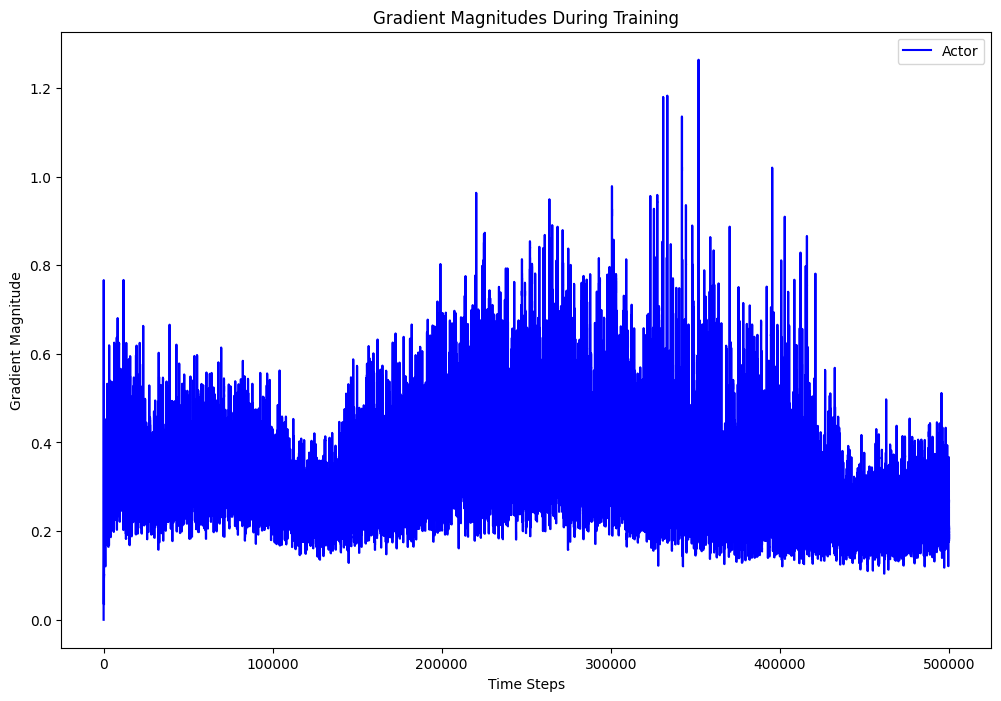

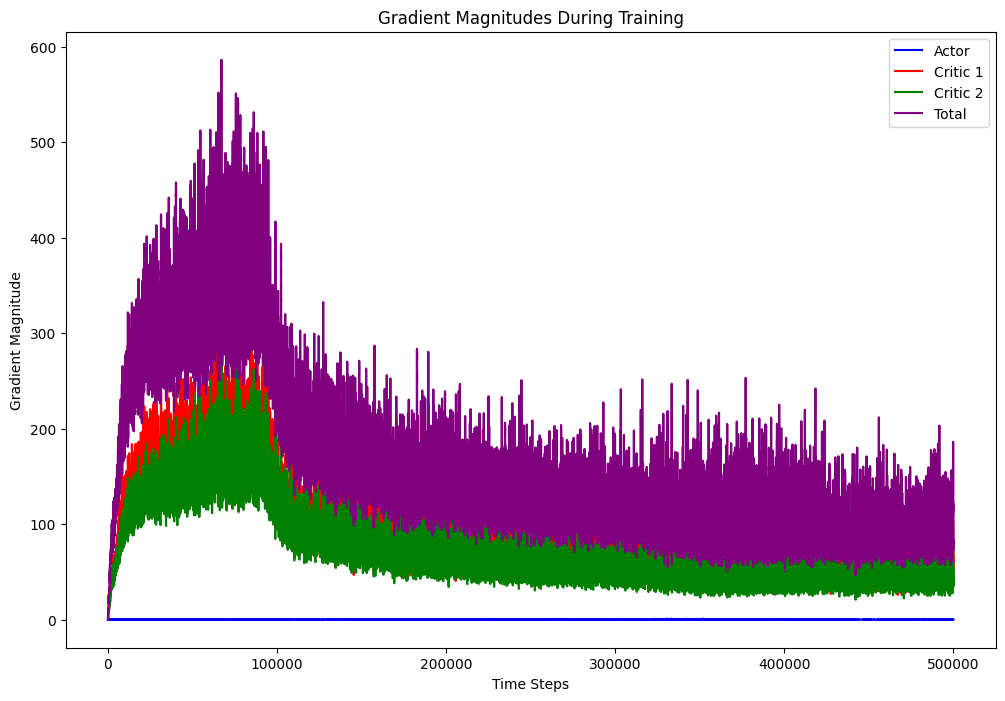

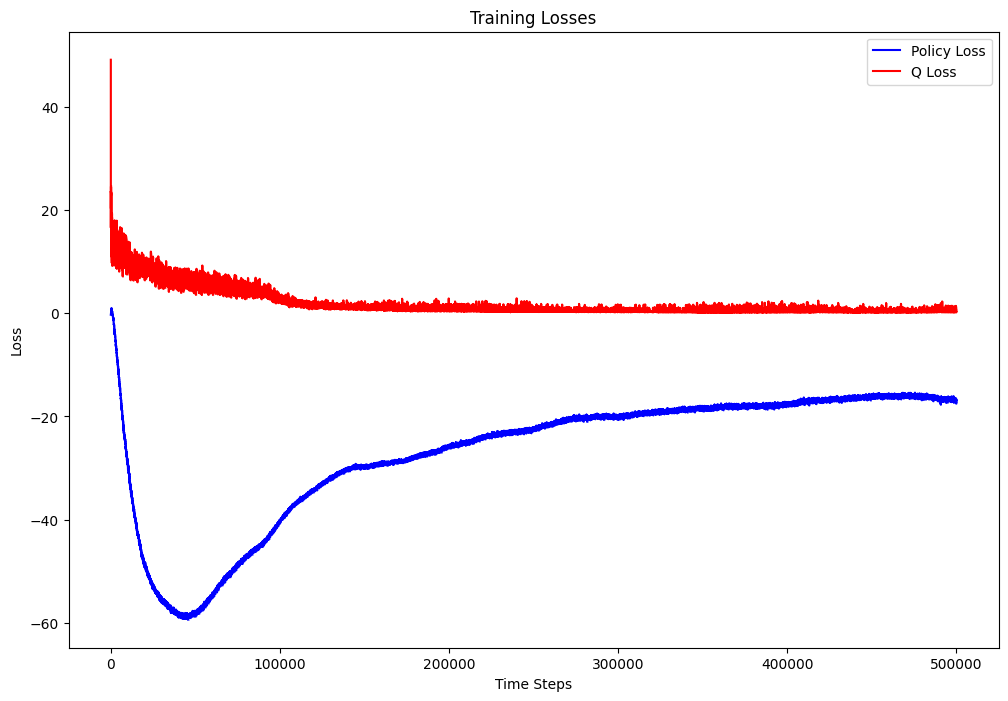

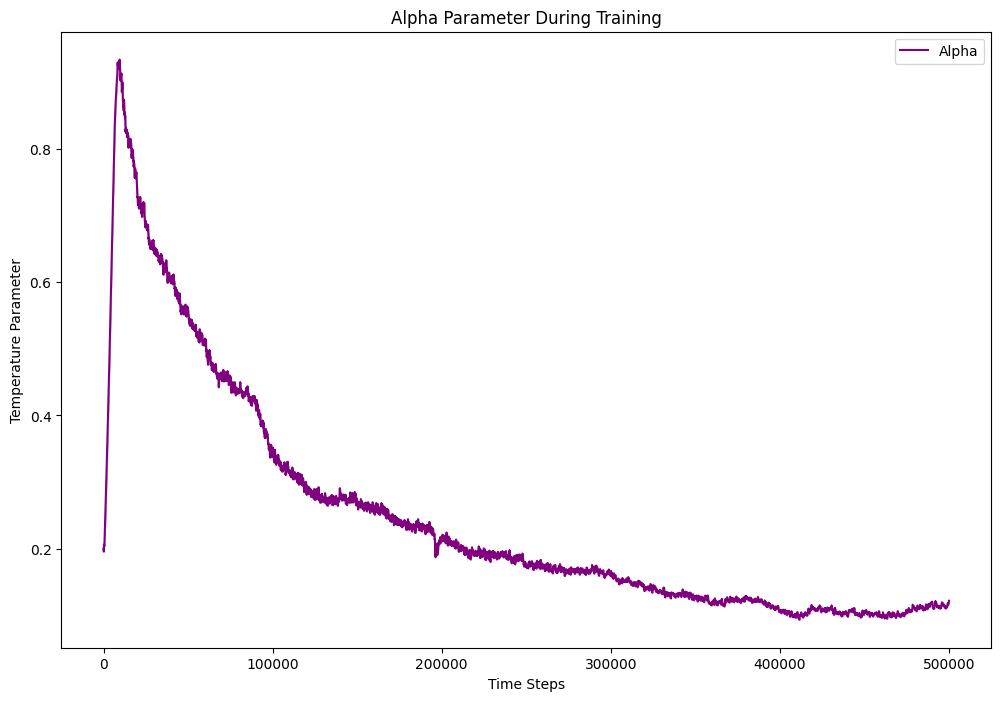

In [151]:
plot_training_metrics(all_grad_metrics, all_losses)

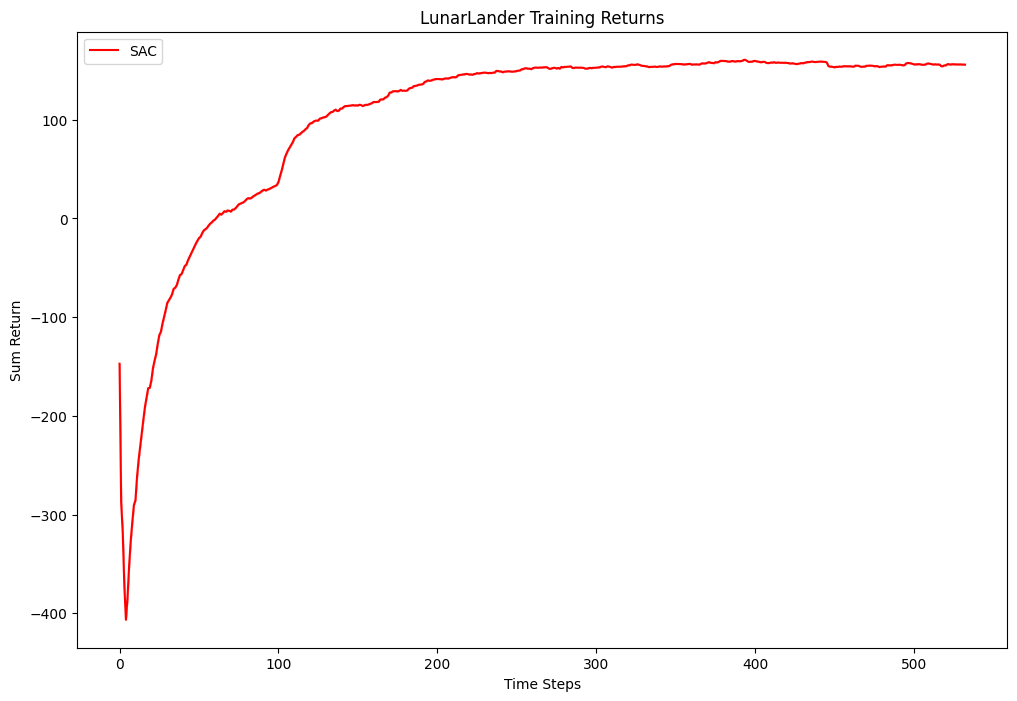

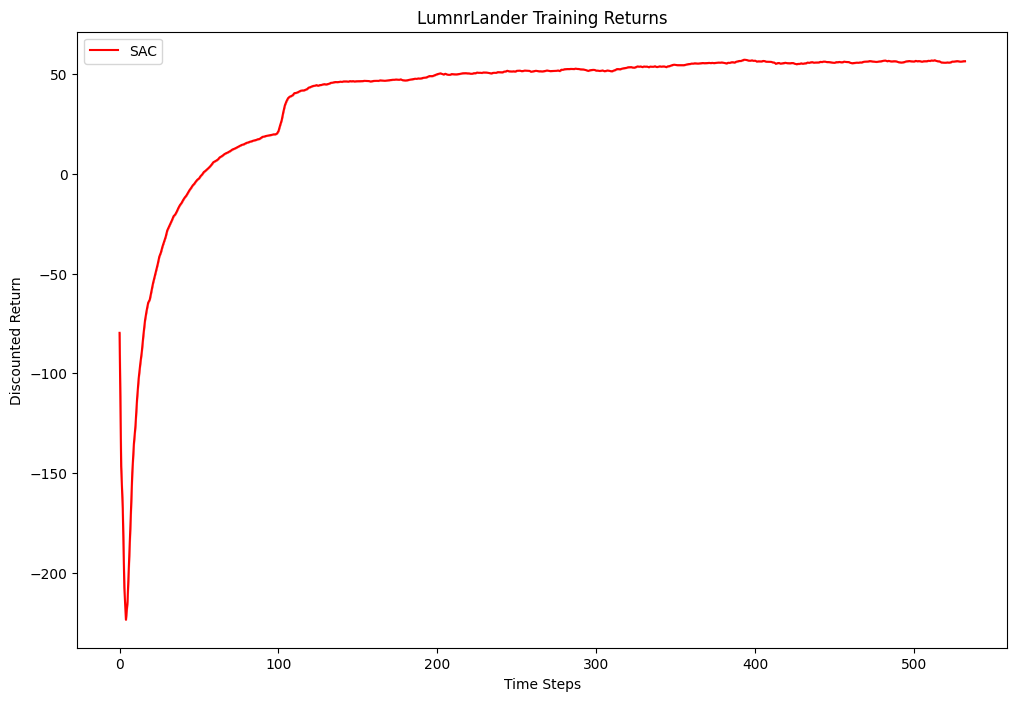

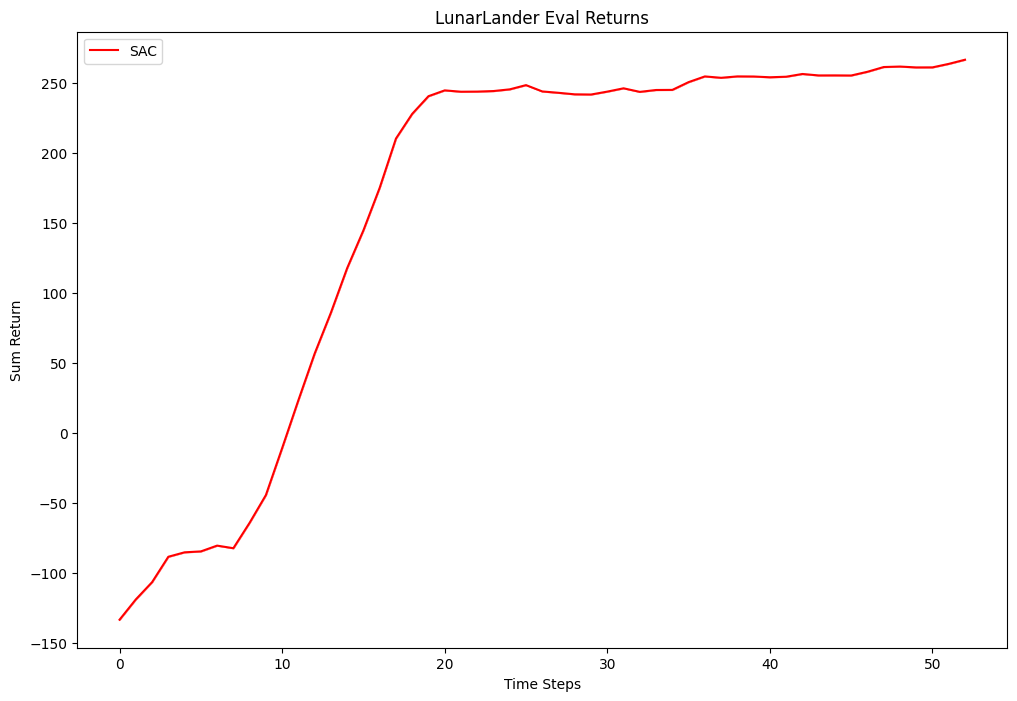

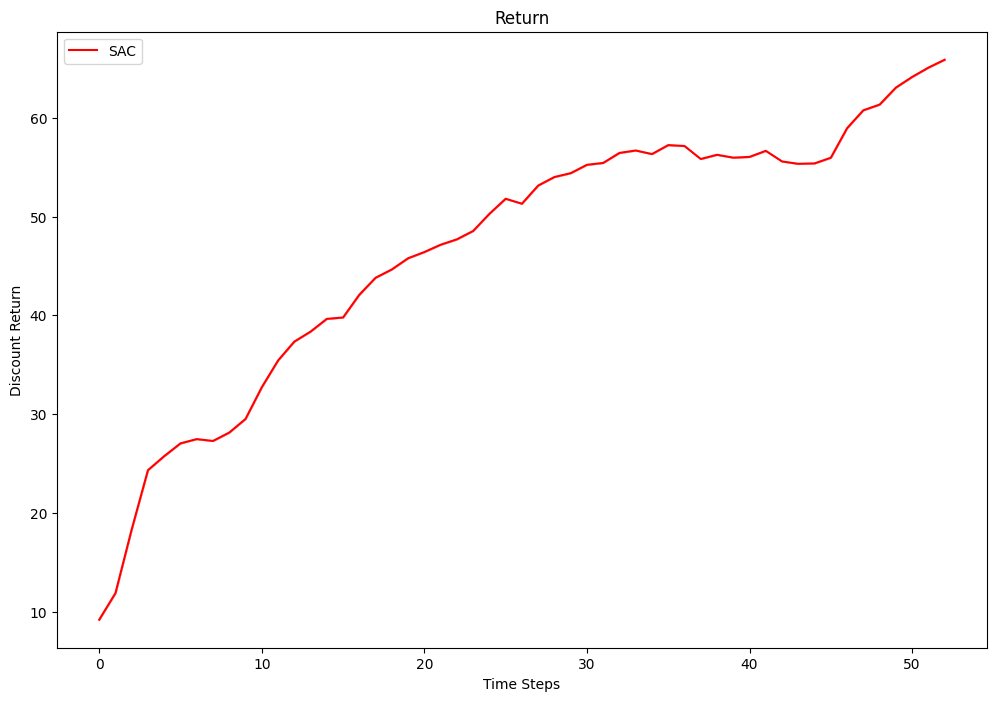

In [176]:
plot_curves([np.array(returns_over_steps)], ['SAC'], ['r'], 'Sum Return', 'LunarLander Training Returns', smoothing = True, window=100)
plot_curves([np.array(discounted_returns)], ['SAC'], ['r'], 'Discounted Return', 'LumnrLander Training Returns', smoothing = True, window=100)
plot_curves([np.array(eval_returns_sum)], ['SAC'], ['r'], 'Sum Return', 'LunarLander Eval Returns', smoothing = True, window=10)
plot_curves([np.array(eval_returns_discount)], ['SAC'], ['r'], 'Discount Return', 'Return', smoothing = True, window=10)

In [102]:
from typing import Optional, Dict
# from grokfast paper - https://arxiv.org/abs/2405.20233
def gradfilter_ema(
    m: nn.Module,
    grads: Optional[Dict[str, torch.Tensor]] = None,
    alpha: float = 0.98,
    lamb: float = 2.0,
) -> Dict[str, torch.Tensor]:
    if grads is None:
        grads = {n: p.grad.data.detach() for n, p in m.named_parameters() if p.requires_grad and p.grad is not None}

    for n, p in m.named_parameters():
        if p.requires_grad and p.grad is not None:
            grads[n] = grads[n] * alpha + p.grad.data.detach() * (1 - alpha)
            p.grad.data = p.grad.data + grads[n] * lamb

    return grads

# we can apply this directly to the model before optimizer step simply by -
# in optimization loop

# loss.backwards()
# grads = gradfilter_ema(model, grads, alpha=alpha, lamb=lamb)
# optimizer.step()


Trial 1/5


Ep:100 | R:-24.5 | AvgR:-67.7 | Succ:73.0% | Len:204.1 | α:0.249 | H:0.29:  10%|█         | 101/1000 [01:29<04:09,  3.60it/s]


Episode 100 Statistics:
Episode Return: -24.53
Average Return (100 ep): -67.70 ± 27.13
Success Rate (100 ep): 73.0%
Average Episode Length: 204.1
Evaluation Return: -56.40
Evaluation Success Rate: 100.0%
Average Q-Value: -14.75
Policy Entropy: 0.655
Alpha: 0.249
Policy Loss: 27.966
Q Loss: 1.717
--------------------------------------------------


Ep:200 | R:-26.8 | AvgR:-31.7 | Succ:100.0% | Len:41.9 | α:0.458 | H:0.50:  20%|██        | 201/1000 [01:52<04:59,  2.67it/s]


Episode 200 Statistics:
Episode Return: -26.77
Average Return (100 ep): -31.72 ± 11.83
Success Rate (100 ep): 100.0%
Average Episode Length: 41.9
Evaluation Return: -24.80
Evaluation Success Rate: 100.0%
Average Q-Value: -22.11
Policy Entropy: 0.477
Alpha: 0.458
Policy Loss: 23.785
Q Loss: 2.489
--------------------------------------------------


Ep:301 | R:-21.4 | AvgR:-30.5 | Succ:100.0% | Len:39.7 | α:0.626 | H:0.70:  30%|███       | 302/1000 [02:14<01:56,  6.00it/s]


Episode 300 Statistics:
Episode Return: -31.06
Average Return (100 ep): -30.61 ± 11.91
Success Rate (100 ep): 100.0%
Average Episode Length: 39.8
Evaluation Return: -25.20
Evaluation Success Rate: 100.0%
Average Q-Value: -16.38
Policy Entropy: 0.613
Alpha: 0.626
Policy Loss: 14.309
Q Loss: 1.068
--------------------------------------------------


Ep:400 | R:-28.9 | AvgR:-27.3 | Succ:100.0% | Len:33.0 | α:0.486 | H:0.72:  40%|████      | 401/1000 [02:31<01:49,  5.46it/s]


Episode 400 Statistics:
Episode Return: -28.94
Average Return (100 ep): -27.32 ± 4.85
Success Rate (100 ep): 100.0%
Average Episode Length: 33.0
Evaluation Return: -26.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.43
Policy Entropy: 0.711
Alpha: 0.486
Policy Loss: 10.824
Q Loss: 0.409
--------------------------------------------------


Ep:501 | R:-28.9 | AvgR:-26.2 | Succ:100.0% | Len:31.5 | α:0.424 | H:0.81:  50%|█████     | 502/1000 [02:48<01:32,  5.40it/s]


Episode 500 Statistics:
Episode Return: -27.50
Average Return (100 ep): -26.27 ± 4.62
Success Rate (100 ep): 100.0%
Average Episode Length: 31.5
Evaluation Return: -27.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.35
Policy Entropy: 0.677
Alpha: 0.424
Policy Loss: 10.728
Q Loss: 0.357
--------------------------------------------------


Ep:601 | R:-19.0 | AvgR:-26.6 | Succ:100.0% | Len:32.3 | α:0.441 | H:0.55:  60%|██████    | 602/1000 [03:08<01:05,  6.09it/s]


Episode 600 Statistics:
Episode Return: -21.43
Average Return (100 ep): -26.66 ± 6.20
Success Rate (100 ep): 100.0%
Average Episode Length: 32.4
Evaluation Return: -24.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.94
Policy Entropy: 0.704
Alpha: 0.438
Policy Loss: 10.647
Q Loss: 0.377
--------------------------------------------------


Ep:700 | R:-29.7 | AvgR:-26.8 | Succ:100.0% | Len:32.3 | α:0.428 | H:0.73:  70%|███████   | 701/1000 [03:25<00:55,  5.35it/s]


Episode 700 Statistics:
Episode Return: -29.66
Average Return (100 ep): -26.82 ± 4.55
Success Rate (100 ep): 100.0%
Average Episode Length: 32.3
Evaluation Return: -23.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.82
Policy Entropy: 0.706
Alpha: 0.428
Policy Loss: 10.591
Q Loss: 0.380
--------------------------------------------------


Ep:801 | R:-28.2 | AvgR:-26.3 | Succ:100.0% | Len:31.5 | α:0.419 | H:0.72:  80%|████████  | 802/1000 [03:43<00:32,  6.12it/s]


Episode 800 Statistics:
Episode Return: -19.84
Average Return (100 ep): -26.35 ± 3.95
Success Rate (100 ep): 100.0%
Average Episode Length: 31.6
Evaluation Return: -24.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.69
Policy Entropy: 0.685
Alpha: 0.419
Policy Loss: 10.759
Q Loss: 0.367
--------------------------------------------------


Ep:901 | R:-19.0 | AvgR:-25.9 | Succ:100.0% | Len:31.1 | α:0.422 | H:0.67:  90%|█████████ | 902/1000 [04:00<00:14,  6.96it/s]


Episode 900 Statistics:
Episode Return: -23.77
Average Return (100 ep): -26.00 ± 4.93
Success Rate (100 ep): 100.0%
Average Episode Length: 31.2
Evaluation Return: -27.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.49
Policy Entropy: 0.690
Alpha: 0.423
Policy Loss: 10.535
Q Loss: 0.349
--------------------------------------------------


Ep:999 | R:-25.3 | AvgR:-26.9 | Succ:100.0% | Len:32.4 | α:0.427 | H:0.66: 100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]


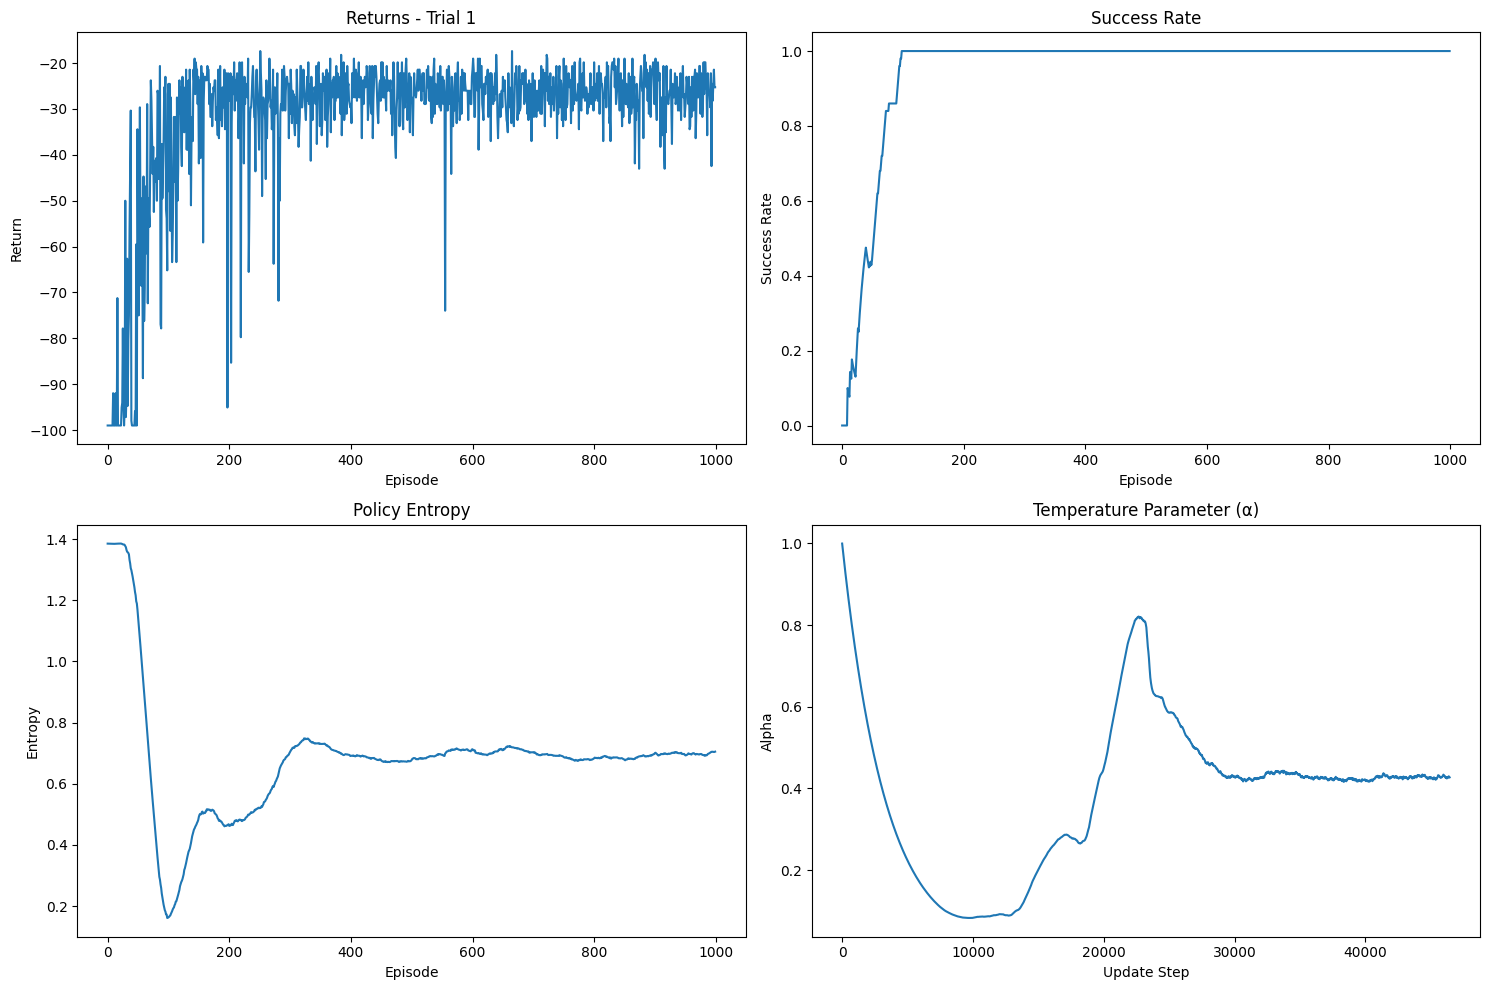


Trial 2/5


Ep:100 | R:-38.3 | AvgR:-66.5 | Succ:77.0% | Len:197.7 | α:0.133 | H:0.19:  10%|█         | 101/1000 [01:25<03:32,  4.23it/s]


Episode 100 Statistics:
Episode Return: -38.27
Average Return (100 ep): -66.48 ± 28.43
Success Rate (100 ep): 77.0%
Average Episode Length: 197.7
Evaluation Return: -75.60
Evaluation Success Rate: 100.0%
Average Q-Value: -17.50
Policy Entropy: 0.766
Alpha: 0.133
Policy Loss: 31.094
Q Loss: 1.743
--------------------------------------------------


Ep:201 | R:-23.8 | AvgR:-36.3 | Succ:100.0% | Len:49.4 | α:0.522 | H:0.62:  20%|██        | 202/1000 [01:51<03:43,  3.56it/s]


Episode 200 Statistics:
Episode Return: -71.53
Average Return (100 ep): -36.79 ± 14.92
Success Rate (100 ep): 100.0%
Average Episode Length: 50.4
Evaluation Return: -38.40
Evaluation Success Rate: 100.0%
Average Q-Value: -25.10
Policy Entropy: 0.446
Alpha: 0.518
Policy Loss: 27.255
Q Loss: 4.934
--------------------------------------------------


Ep:301 | R:-26.0 | AvgR:-31.6 | Succ:100.0% | Len:39.8 | α:0.675 | H:0.69:  30%|███       | 302/1000 [02:12<02:36,  4.47it/s]


Episode 300 Statistics:
Episode Return: -52.94
Average Return (100 ep): -31.53 ± 9.35
Success Rate (100 ep): 100.0%
Average Episode Length: 39.8
Evaluation Return: -22.00
Evaluation Success Rate: 100.0%
Average Q-Value: -18.59
Policy Entropy: 0.732
Alpha: 0.676
Policy Loss: 14.584
Q Loss: 1.329
--------------------------------------------------


Ep:401 | R:-29.7 | AvgR:-28.7 | Succ:100.0% | Len:35.0 | α:0.497 | H:0.66:  40%|████      | 402/1000 [02:30<01:47,  5.56it/s]


Episode 400 Statistics:
Episode Return: -30.36
Average Return (100 ep): -28.66 ± 5.41
Success Rate (100 ep): 100.0%
Average Episode Length: 34.9
Evaluation Return: -26.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.14
Policy Entropy: 0.736
Alpha: 0.499
Policy Loss: 10.082
Q Loss: 0.419
--------------------------------------------------


Ep:501 | R:-29.7 | AvgR:-27.0 | Succ:100.0% | Len:32.6 | α:0.409 | H:0.71:  50%|█████     | 502/1000 [02:46<01:23,  5.98it/s]


Episode 500 Statistics:
Episode Return: -29.66
Average Return (100 ep): -27.01 ± 4.82
Success Rate (100 ep): 100.0%
Average Episode Length: 32.6
Evaluation Return: -25.20
Evaluation Success Rate: 100.0%
Average Q-Value: -9.92
Policy Entropy: 0.714
Alpha: 0.408
Policy Loss: 10.049
Q Loss: 0.301
--------------------------------------------------


Ep:600 | R:-27.5 | AvgR:-25.9 | Succ:100.0% | Len:31.0 | α:0.416 | H:0.69:  60%|██████    | 601/1000 [03:02<01:07,  5.93it/s]


Episode 600 Statistics:
Episode Return: -27.50
Average Return (100 ep): -25.90 ± 3.91
Success Rate (100 ep): 100.0%
Average Episode Length: 31.0
Evaluation Return: -25.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.89
Policy Entropy: 0.715
Alpha: 0.416
Policy Loss: 10.271
Q Loss: 0.341
--------------------------------------------------


Ep:701 | R:-29.7 | AvgR:-26.1 | Succ:100.0% | Len:31.2 | α:0.418 | H:0.73:  70%|███████   | 702/1000 [03:18<00:50,  5.91it/s]


Episode 700 Statistics:
Episode Return: -23.77
Average Return (100 ep): -26.13 ± 4.17
Success Rate (100 ep): 100.0%
Average Episode Length: 31.3
Evaluation Return: -25.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.82
Policy Entropy: 0.687
Alpha: 0.419
Policy Loss: 10.592
Q Loss: 0.333
--------------------------------------------------


Ep:800 | R:-28.9 | AvgR:-26.4 | Succ:100.0% | Len:31.7 | α:0.417 | H:0.66:  80%|████████  | 801/1000 [03:34<00:30,  6.48it/s]


Episode 800 Statistics:
Episode Return: -28.94
Average Return (100 ep): -26.40 ± 4.27
Success Rate (100 ep): 100.0%
Average Episode Length: 31.7
Evaluation Return: -25.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.55
Policy Entropy: 0.692
Alpha: 0.417
Policy Loss: 10.571
Q Loss: 0.317
--------------------------------------------------


Ep:901 | R:-23.0 | AvgR:-25.9 | Succ:100.0% | Len:31.0 | α:0.407 | H:0.71:  90%|█████████ | 902/1000 [03:51<00:16,  5.78it/s]


Episode 900 Statistics:
Episode Return: -26.77
Average Return (100 ep): -26.00 ± 4.52
Success Rate (100 ep): 100.0%
Average Episode Length: 31.1
Evaluation Return: -25.60
Evaluation Success Rate: 100.0%
Average Q-Value: -10.66
Policy Entropy: 0.689
Alpha: 0.410
Policy Loss: 10.544
Q Loss: 0.330
--------------------------------------------------


Ep:999 | R:-22.2 | AvgR:-26.2 | Succ:100.0% | Len:31.4 | α:0.396 | H:0.72: 100%|██████████| 1000/1000 [04:07<00:00,  4.04it/s]


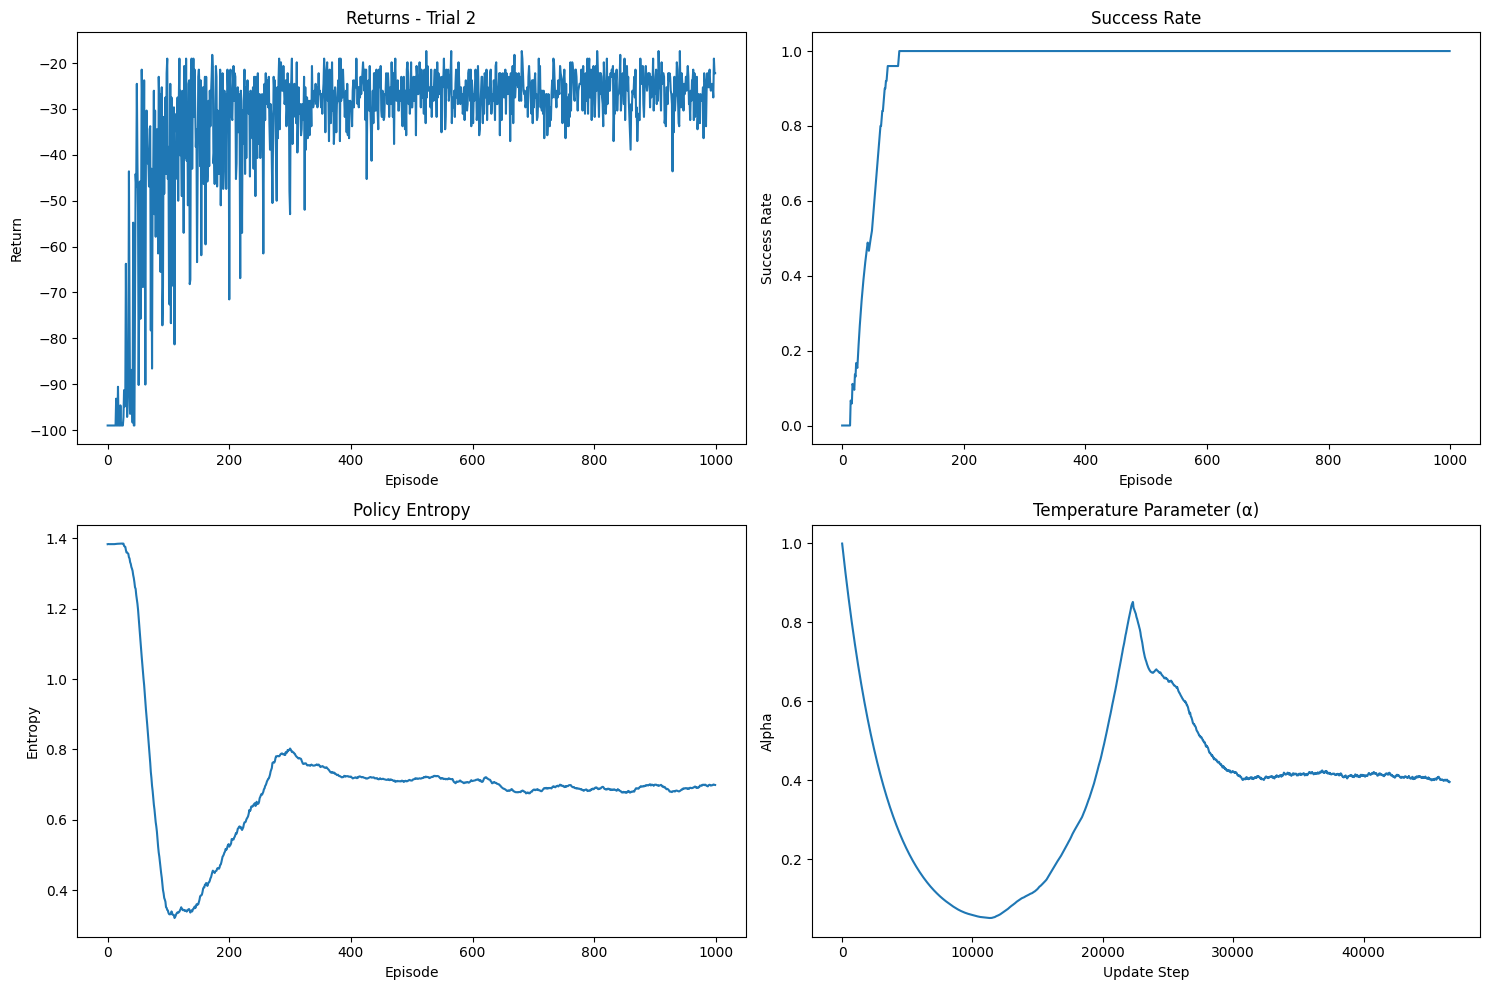


Trial 3/5


Ep:100 | R:-99.0 | AvgR:-73.0 | Succ:64.0% | Len:243.9 | α:0.269 | H:0.52:  10%|█         | 101/1000 [01:43<34:46,  2.32s/it]


Episode 100 Statistics:
Episode Return: -99.02
Average Return (100 ep): -72.96 ± 27.33
Success Rate (100 ep): 64.0%
Average Episode Length: 243.9
Evaluation Return: -460.00
Evaluation Success Rate: 0.0%
Average Q-Value: -19.10
Policy Entropy: 0.739
Alpha: 0.269
Policy Loss: 30.318
Q Loss: 2.759
--------------------------------------------------


Ep:201 | R:-33.1 | AvgR:-48.8 | Succ:92.0% | Len:107.8 | α:0.307 | H:0.48:  20%|██        | 201/1000 [02:42<02:37,  5.06it/s]


Episode 200 Statistics:
Episode Return: -22.22
Average Return (100 ep): -49.47 ± 25.83
Success Rate (100 ep): 91.0%
Average Episode Length: 112.0
Evaluation Return: -88.60
Evaluation Success Rate: 100.0%
Average Q-Value: -17.39
Policy Entropy: 0.502
Alpha: 0.304
Policy Loss: 24.174
Q Loss: 1.988
--------------------------------------------------


Ep:301 | R:-20.6 | AvgR:-30.0 | Succ:100.0% | Len:37.8 | α:0.656 | H:0.61:  30%|███       | 302/1000 [03:02<01:52,  6.19it/s]


Episode 300 Statistics:
Episode Return: -26.77
Average Return (100 ep): -30.10 ± 10.15
Success Rate (100 ep): 100.0%
Average Episode Length: 38.0
Evaluation Return: -37.60
Evaluation Success Rate: 100.0%
Average Q-Value: -18.89
Policy Entropy: 0.537
Alpha: 0.653
Policy Loss: 19.225
Q Loss: 2.759
--------------------------------------------------


Ep:401 | R:-23.0 | AvgR:-28.4 | Succ:100.0% | Len:34.6 | α:0.569 | H:0.66:  40%|████      | 402/1000 [03:20<01:42,  5.86it/s]


Episode 400 Statistics:
Episode Return: -30.36
Average Return (100 ep): -28.34 ± 6.30
Success Rate (100 ep): 100.0%
Average Episode Length: 34.6
Evaluation Return: -22.80
Evaluation Success Rate: 100.0%
Average Q-Value: -13.20
Policy Entropy: 0.692
Alpha: 0.571
Policy Loss: 10.457
Q Loss: 0.569
--------------------------------------------------


Ep:501 | R:-30.4 | AvgR:-26.9 | Succ:100.0% | Len:32.4 | α:0.435 | H:0.82:  50%|█████     | 502/1000 [03:36<01:22,  6.05it/s]


Episode 500 Statistics:
Episode Return: -25.28
Average Return (100 ep): -26.84 ± 4.60
Success Rate (100 ep): 100.0%
Average Episode Length: 32.3
Evaluation Return: -22.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.32
Policy Entropy: 0.692
Alpha: 0.437
Policy Loss: 10.181
Q Loss: 0.348
--------------------------------------------------


Ep:600 | R:-22.2 | AvgR:-26.5 | Succ:100.0% | Len:31.8 | α:0.436 | H:0.64:  60%|██████    | 601/1000 [03:54<01:24,  4.71it/s]


Episode 600 Statistics:
Episode Return: -22.22
Average Return (100 ep): -26.45 ± 4.52
Success Rate (100 ep): 100.0%
Average Episode Length: 31.8
Evaluation Return: -29.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.68
Policy Entropy: 0.698
Alpha: 0.436
Policy Loss: 10.548
Q Loss: 0.360
--------------------------------------------------


Ep:701 | R:-31.1 | AvgR:-26.7 | Succ:100.0% | Len:32.1 | α:0.437 | H:0.78:  70%|███████   | 702/1000 [04:15<00:52,  5.71it/s]


Episode 700 Statistics:
Episode Return: -21.43
Average Return (100 ep): -26.55 ± 4.64
Success Rate (100 ep): 100.0%
Average Episode Length: 31.9
Evaluation Return: -25.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.72
Policy Entropy: 0.703
Alpha: 0.435
Policy Loss: 10.445
Q Loss: 0.346
--------------------------------------------------


Ep:801 | R:-19.8 | AvgR:-26.5 | Succ:100.0% | Len:31.8 | α:0.444 | H:0.61:  80%|████████  | 802/1000 [04:34<00:33,  5.93it/s]


Episode 800 Statistics:
Episode Return: -23.00
Average Return (100 ep): -26.58 ± 4.78
Success Rate (100 ep): 100.0%
Average Episode Length: 32.0
Evaluation Return: -22.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.60
Policy Entropy: 0.690
Alpha: 0.444
Policy Loss: 10.395
Q Loss: 0.332
--------------------------------------------------


Ep:901 | R:-26.8 | AvgR:-26.9 | Succ:100.0% | Len:32.4 | α:0.444 | H:0.67:  90%|█████████ | 902/1000 [04:51<00:15,  6.38it/s]


Episode 900 Statistics:
Episode Return: -24.53
Average Return (100 ep): -26.86 ± 4.29
Success Rate (100 ep): 100.0%
Average Episode Length: 32.3
Evaluation Return: -27.00
Evaluation Success Rate: 100.0%
Average Q-Value: -10.49
Policy Entropy: 0.690
Alpha: 0.444
Policy Loss: 10.487
Q Loss: 0.321
--------------------------------------------------


Ep:999 | R:-23.8 | AvgR:-26.6 | Succ:100.0% | Len:31.9 | α:0.451 | H:0.73: 100%|██████████| 1000/1000 [05:07<00:00,  3.25it/s]


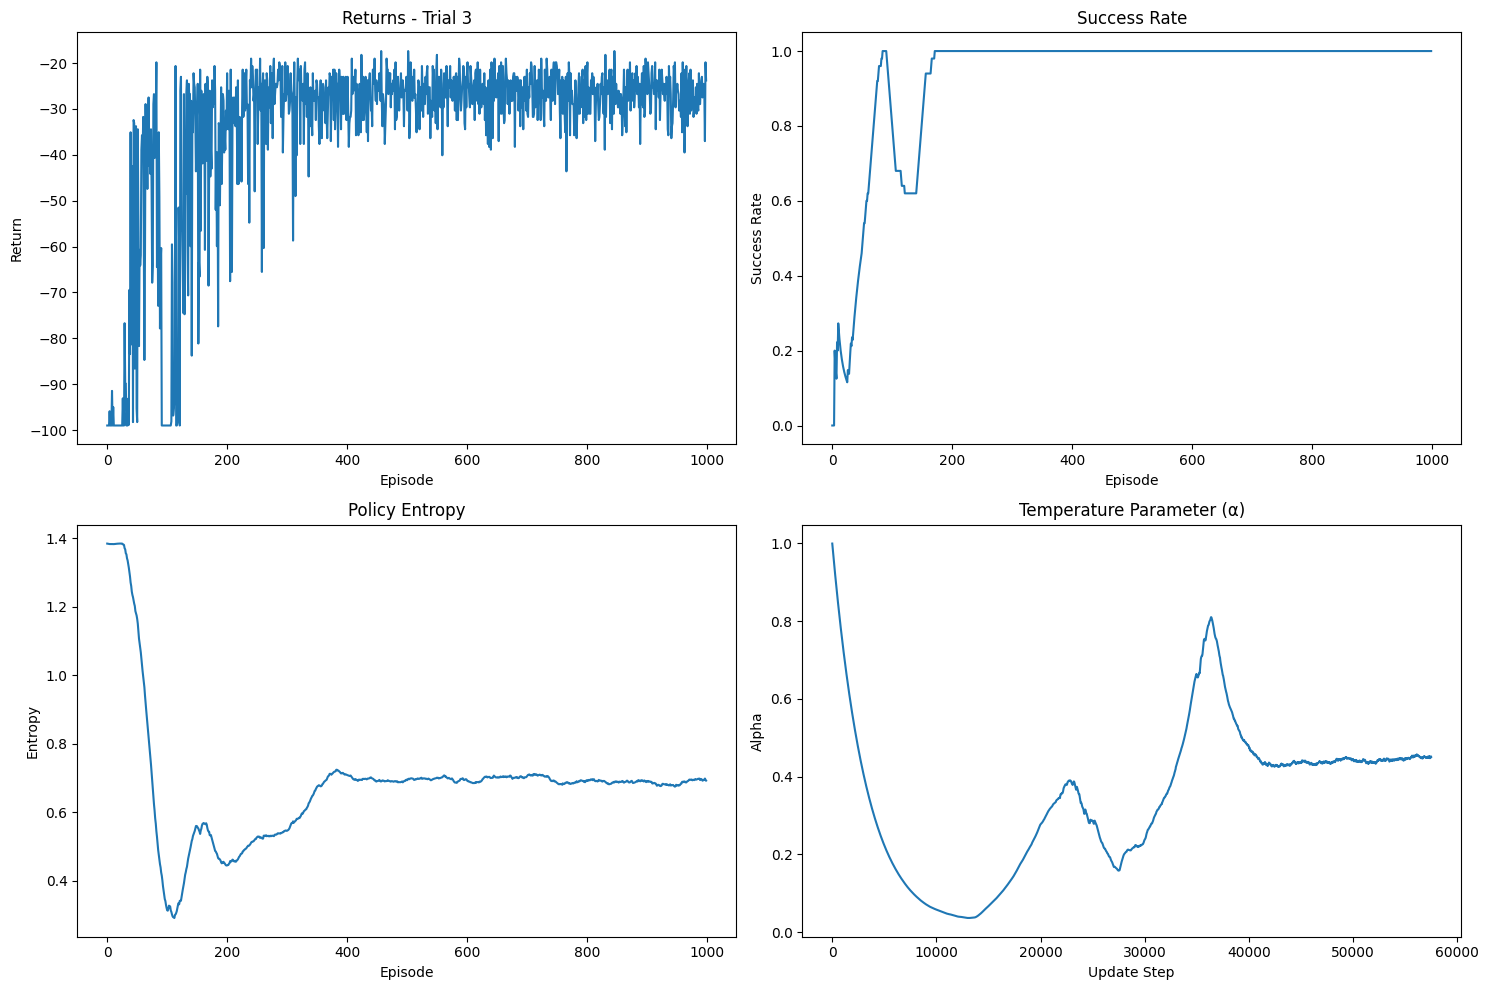


Trial 4/5


Ep:100 | R:-45.3 | AvgR:-60.2 | Succ:78.0% | Len:180.6 | α:0.118 | H:0.14:  10%|█         | 101/1000 [01:13<04:27,  3.36it/s]


Episode 100 Statistics:
Episode Return: -45.28
Average Return (100 ep): -60.19 ± 30.09
Success Rate (100 ep): 78.0%
Average Episode Length: 180.6
Evaluation Return: -64.00
Evaluation Success Rate: 100.0%
Average Q-Value: -14.73
Policy Entropy: 0.703
Alpha: 0.118
Policy Loss: 26.732
Q Loss: 1.524
--------------------------------------------------


Ep:200 | R:-24.5 | AvgR:-29.3 | Succ:100.0% | Len:36.8 | α:0.413 | H:0.47:  20%|██        | 201/1000 [01:32<02:05,  6.36it/s]


Episode 200 Statistics:
Episode Return: -24.53
Average Return (100 ep): -29.32 ± 10.29
Success Rate (100 ep): 100.0%
Average Episode Length: 36.8
Evaluation Return: -23.20
Evaluation Success Rate: 100.0%
Average Q-Value: -19.26
Policy Entropy: 0.308
Alpha: 0.413
Policy Loss: 21.887
Q Loss: 2.064
--------------------------------------------------


Ep:300 | R:-23.8 | AvgR:-28.8 | Succ:100.0% | Len:35.5 | α:0.595 | H:0.77:  30%|███       | 301/1000 [01:51<01:57,  5.93it/s]


Episode 300 Statistics:
Episode Return: -23.77
Average Return (100 ep): -28.78 ± 8.07
Success Rate (100 ep): 100.0%
Average Episode Length: 35.5
Evaluation Return: -22.80
Evaluation Success Rate: 100.0%
Average Q-Value: -14.19
Policy Entropy: 0.608
Alpha: 0.595
Policy Loss: 12.311
Q Loss: 0.737
--------------------------------------------------


Ep:401 | R:-19.8 | AvgR:-27.0 | Succ:100.0% | Len:32.6 | α:0.433 | H:0.72:  40%|████      | 402/1000 [02:08<01:41,  5.87it/s]


Episode 400 Statistics:
Episode Return: -24.53
Average Return (100 ep): -27.13 ± 4.86
Success Rate (100 ep): 100.0%
Average Episode Length: 32.7
Evaluation Return: -23.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.72
Policy Entropy: 0.719
Alpha: 0.434
Policy Loss: 10.604
Q Loss: 0.381
--------------------------------------------------


Ep:501 | R:-27.5 | AvgR:-27.0 | Succ:100.0% | Len:32.5 | α:0.401 | H:0.72:  50%|█████     | 502/1000 [02:26<01:27,  5.69it/s]


Episode 500 Statistics:
Episode Return: -22.22
Average Return (100 ep): -26.92 ± 4.27
Success Rate (100 ep): 100.0%
Average Episode Length: 32.4
Evaluation Return: -26.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.91
Policy Entropy: 0.718
Alpha: 0.402
Policy Loss: 10.748
Q Loss: 0.358
--------------------------------------------------


Ep:601 | R:-30.4 | AvgR:-25.6 | Succ:100.0% | Len:30.6 | α:0.407 | H:0.73:  60%|██████    | 602/1000 [02:43<01:07,  5.94it/s]


Episode 600 Statistics:
Episode Return: -20.64
Average Return (100 ep): -25.53 ± 4.44
Success Rate (100 ep): 100.0%
Average Episode Length: 30.5
Evaluation Return: -24.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.48
Policy Entropy: 0.688
Alpha: 0.410
Policy Loss: 10.520
Q Loss: 0.343
--------------------------------------------------


Ep:700 | R:-22.2 | AvgR:-26.6 | Succ:100.0% | Len:31.9 | α:0.411 | H:0.64:  70%|███████   | 701/1000 [02:59<00:43,  6.82it/s]


Episode 700 Statistics:
Episode Return: -22.22
Average Return (100 ep): -26.56 ± 4.16
Success Rate (100 ep): 100.0%
Average Episode Length: 31.9
Evaluation Return: -27.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.71
Policy Entropy: 0.694
Alpha: 0.411
Policy Loss: 10.530
Q Loss: 0.329
--------------------------------------------------


Ep:801 | R:-22.2 | AvgR:-26.7 | Succ:100.0% | Len:32.1 | α:0.417 | H:0.74:  80%|████████  | 802/1000 [03:17<00:32,  6.08it/s]


Episode 800 Statistics:
Episode Return: -28.23
Average Return (100 ep): -26.83 ± 4.39
Success Rate (100 ep): 100.0%
Average Episode Length: 32.3
Evaluation Return: -26.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.77
Policy Entropy: 0.702
Alpha: 0.416
Policy Loss: 10.376
Q Loss: 0.327
--------------------------------------------------


Ep:901 | R:-21.4 | AvgR:-26.4 | Succ:100.0% | Len:31.7 | α:0.410 | H:0.68:  90%|█████████ | 902/1000 [03:36<00:15,  6.20it/s]


Episode 900 Statistics:
Episode Return: -25.28
Average Return (100 ep): -26.40 ± 4.54
Success Rate (100 ep): 100.0%
Average Episode Length: 31.7
Evaluation Return: -25.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.58
Policy Entropy: 0.700
Alpha: 0.411
Policy Loss: 10.504
Q Loss: 0.337
--------------------------------------------------


Ep:999 | R:-25.3 | AvgR:-26.1 | Succ:100.0% | Len:31.4 | α:0.404 | H:0.73: 100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s]


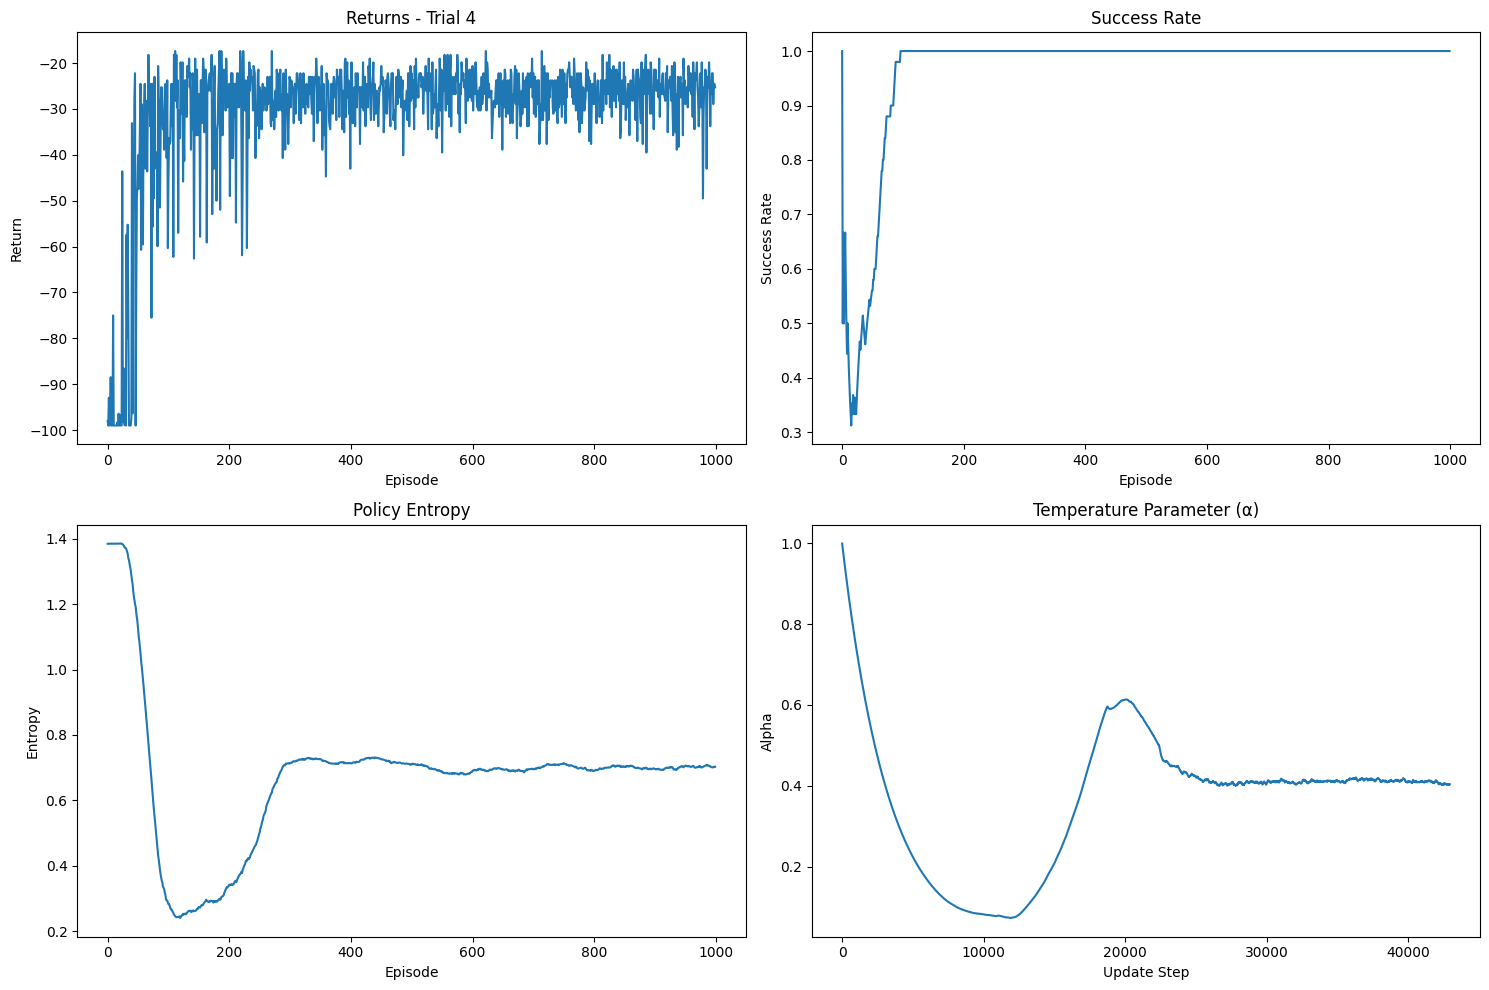


Trial 5/5


Ep:100 | R:-53.4 | AvgR:-66.0 | Succ:77.0% | Len:189.2 | α:0.155 | H:0.21:  10%|█         | 101/1000 [01:16<07:17,  2.05it/s]


Episode 100 Statistics:
Episode Return: -53.41
Average Return (100 ep): -65.95 ± 26.50
Success Rate (100 ep): 77.0%
Average Episode Length: 189.2
Evaluation Return: -51.40
Evaluation Success Rate: 100.0%
Average Q-Value: -14.78
Policy Entropy: 0.738
Alpha: 0.155
Policy Loss: 27.370
Q Loss: 1.600
--------------------------------------------------


Ep:200 | R:-26.0 | AvgR:-34.9 | Succ:100.0% | Len:46.7 | α:0.516 | H:0.49:  20%|██        | 201/1000 [01:42<02:18,  5.78it/s]


Episode 200 Statistics:
Episode Return: -26.03
Average Return (100 ep): -34.91 ± 13.79
Success Rate (100 ep): 100.0%
Average Episode Length: 46.7
Evaluation Return: -36.00
Evaluation Success Rate: 100.0%
Average Q-Value: -22.37
Policy Entropy: 0.399
Alpha: 0.516
Policy Loss: 24.936
Q Loss: 3.707
--------------------------------------------------


Ep:300 | R:-25.3 | AvgR:-30.4 | Succ:100.0% | Len:38.7 | α:0.610 | H:0.63:  30%|███       | 301/1000 [02:03<02:07,  5.49it/s]


Episode 300 Statistics:
Episode Return: -25.28
Average Return (100 ep): -30.39 ± 9.90
Success Rate (100 ep): 100.0%
Average Episode Length: 38.7
Evaluation Return: -22.20
Evaluation Success Rate: 100.0%
Average Q-Value: -17.13
Policy Entropy: 0.648
Alpha: 0.610
Policy Loss: 15.466
Q Loss: 1.733
--------------------------------------------------


Ep:401 | R:-23.0 | AvgR:-27.9 | Succ:100.0% | Len:33.9 | α:0.478 | H:0.72:  40%|████      | 402/1000 [02:28<02:04,  4.82it/s]


Episode 400 Statistics:
Episode Return: -39.50
Average Return (100 ep): -27.96 ± 5.51
Success Rate (100 ep): 100.0%
Average Episode Length: 33.9
Evaluation Return: -24.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.61
Policy Entropy: 0.707
Alpha: 0.481
Policy Loss: 10.432
Q Loss: 0.420
--------------------------------------------------


Ep:501 | R:-25.3 | AvgR:-27.0 | Succ:100.0% | Len:32.6 | α:0.406 | H:0.72:  50%|█████     | 502/1000 [02:47<01:31,  5.45it/s]


Episode 500 Statistics:
Episode Return: -28.23
Average Return (100 ep): -27.03 ± 4.79
Success Rate (100 ep): 100.0%
Average Episode Length: 32.6
Evaluation Return: -22.80
Evaluation Success Rate: 100.0%
Average Q-Value: -10.30
Policy Entropy: 0.697
Alpha: 0.405
Policy Loss: 10.669
Q Loss: 0.345
--------------------------------------------------


Ep:600 | R:-22.2 | AvgR:-26.7 | Succ:100.0% | Len:32.2 | α:0.405 | H:0.74:  60%|██████    | 601/1000 [03:04<01:01,  6.50it/s]


Episode 600 Statistics:
Episode Return: -22.22
Average Return (100 ep): -26.75 ± 4.47
Success Rate (100 ep): 100.0%
Average Episode Length: 32.2
Evaluation Return: -26.00
Evaluation Success Rate: 100.0%
Average Q-Value: -11.21
Policy Entropy: 0.695
Alpha: 0.405
Policy Loss: 10.692
Q Loss: 0.366
--------------------------------------------------


Ep:701 | R:-28.2 | AvgR:-25.7 | Succ:100.0% | Len:30.8 | α:0.425 | H:0.77:  70%|███████   | 702/1000 [03:24<00:57,  5.21it/s]


Episode 700 Statistics:
Episode Return: -23.00
Average Return (100 ep): -25.78 ± 4.13
Success Rate (100 ep): 100.0%
Average Episode Length: 30.8
Evaluation Return: -21.40
Evaluation Success Rate: 100.0%
Average Q-Value: -11.01
Policy Entropy: 0.692
Alpha: 0.426
Policy Loss: 10.794
Q Loss: 0.362
--------------------------------------------------


Ep:800 | R:-23.0 | AvgR:-25.9 | Succ:100.0% | Len:31.0 | α:0.414 | H:0.72:  80%|████████  | 801/1000 [03:41<00:30,  6.43it/s]


Episode 800 Statistics:
Episode Return: -23.00
Average Return (100 ep): -25.93 ± 3.69
Success Rate (100 ep): 100.0%
Average Episode Length: 31.0
Evaluation Return: -23.40
Evaluation Success Rate: 100.0%
Average Q-Value: -10.80
Policy Entropy: 0.694
Alpha: 0.414
Policy Loss: 10.753
Q Loss: 0.340
--------------------------------------------------


Ep:901 | R:-20.6 | AvgR:-26.2 | Succ:100.0% | Len:31.5 | α:0.401 | H:0.71:  90%|█████████ | 902/1000 [03:58<00:14,  6.71it/s]


Episode 900 Statistics:
Episode Return: -23.00
Average Return (100 ep): -26.35 ± 4.40
Success Rate (100 ep): 100.0%
Average Episode Length: 31.6
Evaluation Return: -24.20
Evaluation Success Rate: 100.0%
Average Q-Value: -10.95
Policy Entropy: 0.695
Alpha: 0.400
Policy Loss: 10.751
Q Loss: 0.356
--------------------------------------------------


Ep:999 | R:-21.4 | AvgR:-26.4 | Succ:100.0% | Len:31.6 | α:0.403 | H:0.68: 100%|██████████| 1000/1000 [04:15<00:00,  3.92it/s]


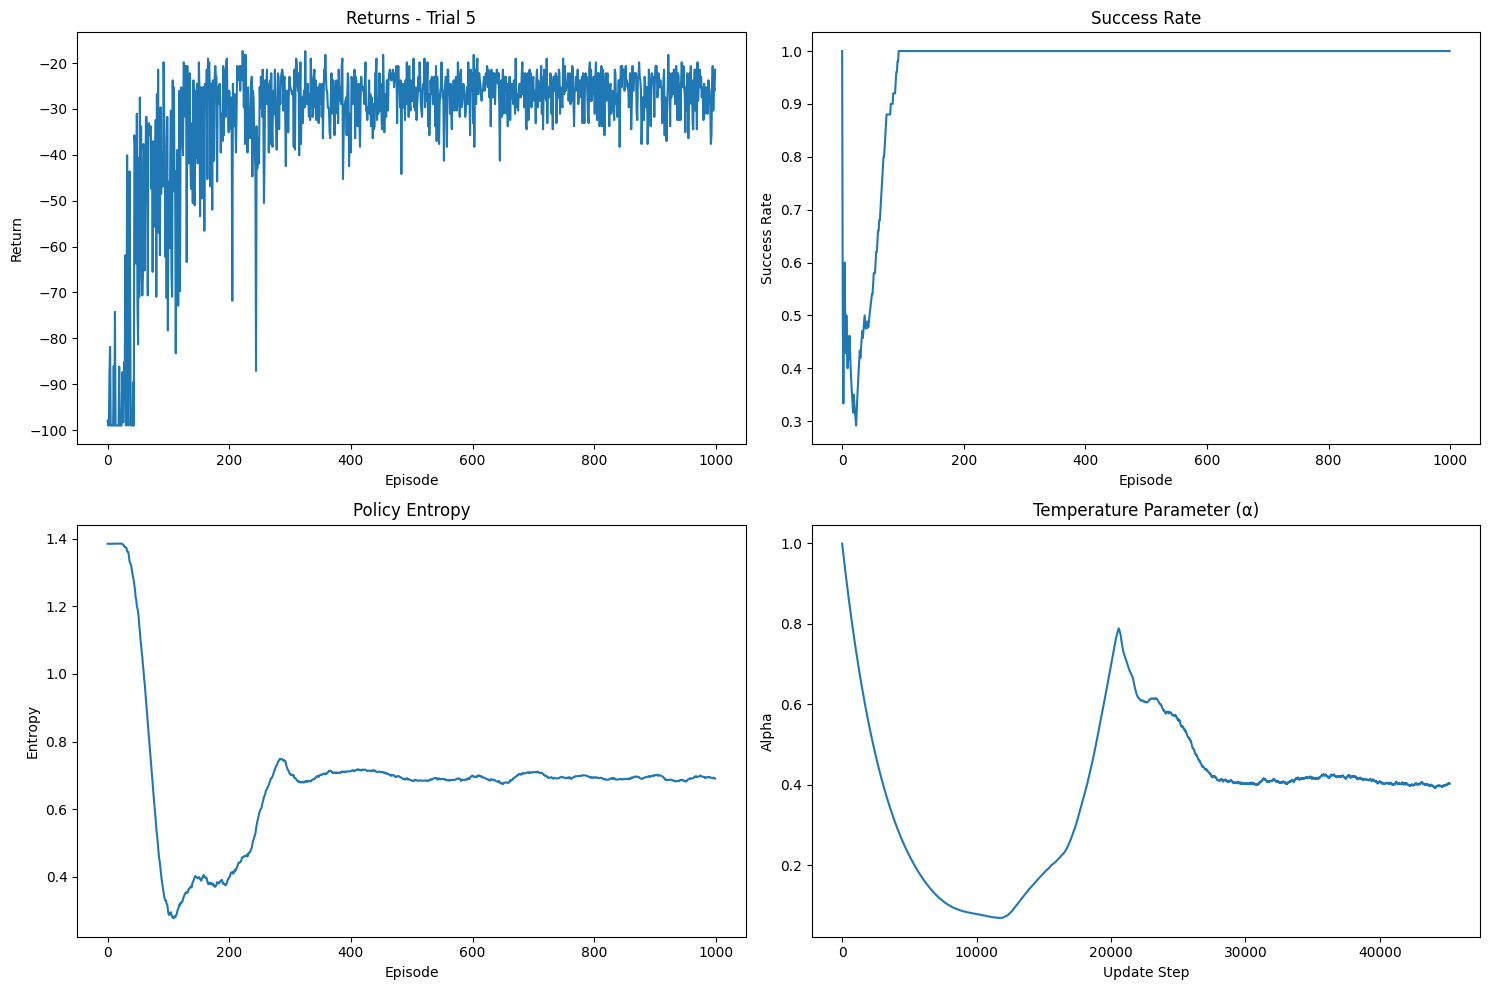

In [141]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt

# Replay buffer transition tuple
Transition = namedtuple('Transition', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, capacity, state_dim=3, device="cpu"):
        self.capacity = capacity
        self.device = device
        self.memory = []
        self.position = 0
        
    def push(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).to(self.device)
        action = torch.tensor([action], dtype=torch.long).to(self.device)
        reward = torch.tensor([reward], dtype=torch.float32).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.tensor([done], dtype=torch.float32).to(self.device)
        
        transition = Transition(state, action, reward, next_state, done)
        
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition
        
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size)
        transitions = [self.memory[idx] for idx in indices]
        batch = Transition(*zip(*transitions))
        
        states = torch.stack(batch.state)
        actions = torch.stack(batch.action)
        rewards = torch.stack(batch.reward)
        next_states = torch.stack(batch.next_state)
        dones = torch.stack(batch.done)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, state):
        return self.net(state)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, state):
        return self.net(state)

class SACAgent:
    def __init__(self, state_dim=3, action_dim=4, hidden_dim=256,
                 lr=3e-4, gamma=0.99, tau=0.005,
                 batch_size=256, device="cpu"):
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.batch_size = batch_size
        self.action_dim = action_dim
        
        # Networks
        self.critic1 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
        self.actor = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)
        
        # Copy target parameters
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # Optimizers with eps like reference
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr, eps=1e-4)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr, eps=1e-4)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, eps=1e-4)
        
        # Entropy tuning matching reference
        self.target_entropy = -np.log((1.0 / action_dim)) * 0.5 
        self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr, eps=1e-4)
        
    @property
    def alpha(self):
        return self.log_alpha.exp()
    
    def get_action(self, state, evaluate=False):
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            action_probs = self.actor(state)
            if evaluate:
                action = torch.argmax(action_probs, dim=-1)
            else:
                dist = Categorical(action_probs)
                action = dist.sample()
            return action.item()
    
    def calculate_critic_losses(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch):
        with torch.no_grad():
            next_action_probs = self.actor(next_state_batch)
            # Handle zero probabilities exactly like reference
            z = next_action_probs == 0.0
            z = z.float() * 1e-8
            log_next_action_probs = torch.log(next_action_probs + z)
            
            next_q1 = self.critic1_target(next_state_batch)
            next_q2 = self.critic2_target(next_state_batch)
            
            # Matching reference implementation exactly
            min_qf_next_target = next_action_probs * (
                torch.min(next_q1, next_q2) - self.alpha * log_next_action_probs
            )
            min_qf_next_target = min_qf_next_target.sum(dim=1).unsqueeze(-1)
            next_q_value = reward_batch + (1 - done_batch) * self.gamma * min_qf_next_target

        q1 = self.critic1(state_batch).gather(1, action_batch.long())
        q2 = self.critic2(state_batch).gather(1, action_batch.long())
        
        critic1_loss = F.mse_loss(q1, next_q_value)
        critic2_loss = F.mse_loss(q2, next_q_value)
        
        return critic1_loss, critic2_loss

    def calculate_actor_loss(self, state_batch):
        action_probs = self.actor(state_batch)
        # Handle zero probabilities
        z = action_probs == 0.0
        z = z.float() * 1e-8
        log_action_probs = torch.log(action_probs + z)
        
        q1 = self.critic1(state_batch)
        q2 = self.critic2(state_batch)
        min_q = torch.min(q1, q2).detach()
        
        # Matching reference implementation
        inside_term = self.alpha * log_action_probs - min_q
        policy_loss = (action_probs * inside_term).sum(dim=1).mean()
        log_action_probs = torch.sum(log_action_probs * action_probs, dim=1)
        
        return policy_loss, log_action_probs
# Four Rooms SAC Update Method with EMA
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, total_steps, freq_update_target, actor_grads, critic_1_grads, critic_2_grads):
        """SAC update with EMA gradient tracking for Four Rooms"""
        # Critic update
        critic1_loss, critic2_loss = self.calculate_critic_losses(
            state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        critic_1_grads = gradfilter_ema(self.critic1, critic_1_grads, alpha=0.98, lamb=2.0)
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        critic_2_grads = gradfilter_ema(self.critic2, critic_2_grads, alpha=0.98, lamb=2.0)
        self.critic2_optimizer.step()
        
        # Actor update
        policy_loss, log_probs = self.calculate_actor_loss(state_batch)
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        actor_grads = gradfilter_ema(self.actor, actor_grads, alpha=0.98, lamb=2.0)
        self.actor_optimizer.step()
        
        # Track EMA gradients
        grad_stats = track_ema_grad_stats(actor_grads, critic_1_grads, critic_2_grads)
        
        # Alpha update 
        alpha_loss = -(self.log_alpha * (log_probs + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Target update
        if total_steps % freq_update_target == 0:
            for target_param, param in zip(self.critic1_target.parameters(), self.critic1.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
            for target_param, param in zip(self.critic2_target.parameters(), self.critic2.parameters()):
                target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
        
        return actor_grads, critic_1_grads, critic_2_grads, grad_stats, {
            'critic1_loss': critic1_loss.item(),
            'critic2_loss': critic2_loss.item(),
            'policy_loss': policy_loss.item(),
            'alpha': self.alpha.item()
        }

def evaluate_policy(env, agent, num_episodes=5):
    """Runs policy evaluation episodes."""
    eval_returns = []
    eval_successes = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]
        episode_return = 0
        done = False
        reached_goal = False

        while not done:
            action = agent.get_action(state_features, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if terminated:
                reached_goal = True

            episode_return += reward
            state = next_state
            state_features = [state[0] / 10.0, state[1] / 10.0, 1.0]

        eval_returns.append(episode_return)
        eval_successes.append(float(reached_goal))

    # Return all evaluation returns and successes for further processing
    return np.array(eval_returns), np.array(eval_successes)

def train_sac_trials(num_trials=10, num_episodes=10000, smoothing=True):
    """Run multiple trials with detailed logging"""
    all_returns = []
    all_losses = []
    eval_returns_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episodes
    eval_success_array = np.zeros((num_trials, num_episodes // 100 + 1, 5))  # Store all episode
    all_grad_metrics = []
    
    training_params = {
        'num_episodes': num_episodes,
        'batch_size': 256,
        'buffer_size': 10_000,
        'learning_rate': 3e-4,
        'hidden_dim': 256,
        'gamma': 0.99,
        'tau': 0.005,
        'min_steps_before_learning': 5000,
        "freq_update_target": 1,
        "updates_per_step": 1, 
        "steps_per_update": 1
    }
    
    for trial in range(num_trials):
        print(f"\nTrial {trial + 1}/{num_trials}")
        
        # Set seeds
        torch.manual_seed(trial)
        np.random.seed(trial)
        
        env = FourRooms()
        eval_env = FourRooms()
        agent = SACAgent()
        buffer = ReplayBuffer(training_params['buffer_size'])
        
        # Training metrics
        trial_returns = []
        episode_lengths = []
        q_values = []
        entropies = []
        alphas = []
        policy_losses = []
        q_losses = []
        success_rate = []
        # EMA grads need to persist across episodes
        actor_grads = None
        critic_1_grads = None
        critic_2_grads = None
        grad_metrics = {
            'actor_grad_mag': [],
            'critic1_grad_mag': [],
            'critic2_grad_mag': [],
            'total_grad_mag': []
        }
        total_steps = 0
        pbar = tqdm.trange(training_params['num_episodes'])
        
        for episode in pbar:
            state, _ = env.reset()
            episode_rewards = []
            episode_length = 0
            episode_q_values = []
            episode_entropies = []
            
            done = False
            reached_goal = False
            
            while not done:
                # Get state features and action
                state_features = [state[0]/10.0, state[1]/10.0, 1.0]
                state_tensor = torch.FloatTensor(state_features).unsqueeze(0).to(agent.device)
                
                # Get action and log metrics
                with torch.no_grad():
                    probs = agent.actor(state_tensor)
                    q1 = agent.critic1(state_tensor)
                    q2 = agent.critic2(state_tensor)
                    episode_q_values.append(torch.max(torch.min(q1, q2)).item())
                    entropy = -(probs * torch.log(probs + 1e-8)).sum(1).item()
                    episode_entropies.append(entropy)
                
                action = agent.get_action(state_features)
                
                # Environment step
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                if terminated:
                    reached_goal = True
                
                next_state_features = [next_state[0]/10.0, next_state[1]/10.0, 1.0]
                
                # Store transition
                buffer.push(state_features, action, reward, next_state_features, done)
                
                # Update if enough samples
                if total_steps > training_params['min_steps_before_learning'] and len(buffer) >= training_params['batch_size'] and total_steps % training_params['steps_per_update'] == 0:
                    for _ in range(training_params["updates_per_step"]):
                        batch = buffer.sample(training_params['batch_size'])
                        actor_grads, critic_1_grads, critic_2_grads, grad_stats, loss_dict = agent.update(
                            *batch, total_steps, training_params["freq_update_target"],
                            actor_grads, critic_1_grads, critic_2_grads
                        )
                                                
                        for key, value in grad_stats.items():
                            grad_metrics[key].append(value)
                        # print grad metrics
                        # print(f"Actor Grad: {sum(torch.norm(g) for g in actor_grads.values()):.3f}, "
                        # f"Critic 1 Grad: {sum(torch.norm(g) for g in critic_1_grads.values()):.3f}, "
                        # f"Critic 2 Grad: {sum(torch.norm(g) for g in critic_2_grads.values()):.3f}")

                        policy_losses.append(loss_dict['policy_loss'])
                        q_losses.append((loss_dict['critic1_loss'] + loss_dict['critic2_loss']) / 2)
                        alphas.append(loss_dict['alpha'])
                        
                episode_rewards.append(reward)
                episode_length += 1
                total_steps += 1
                state = next_state
            
            # Compute total discounted return for the episode
            G = 0
            for r in reversed(episode_rewards):
                G = r + training_params['gamma'] * G
            episode_return = G  # Total discounted return for the episode
            
            # Store the episode return
            trial_returns.append(episode_return)
            episode_lengths.append(episode_length)
            success_rate.append(float(reached_goal))
            
            if episode_q_values:
                q_values.append(np.mean(episode_q_values))
            if episode_entropies:
                entropies.append(np.mean(episode_entropies))
            
            # Update progress bar with per-episode return
            current_return = trial_returns[-1]
            avg_return = np.mean(trial_returns[-100:]) if len(trial_returns) >= 100 else np.mean(trial_returns)
            avg_success = np.mean(success_rate[-100:]) * 100 if len(success_rate) >= 100 else np.mean(success_rate) * 100
            avg_length = np.mean(episode_lengths[-100:]) if len(episode_lengths) >= 100 else np.mean(episode_lengths)
            
            current_alpha = alphas[-1] if alphas else 0
            current_entropy = entropies[-1] if entropies else 0
            
            desc = f"Ep:{episode} | R:{current_return:.1f} | AvgR:{avg_return:.1f} | Succ:{avg_success:.1f}% | Len:{avg_length:.1f}"
            if alphas:
                desc += f" | α:{current_alpha:.3f}"
            if entropies:
                desc += f" | H:{current_entropy:.2f}"
            
            pbar.set_description(desc)
            
            # Periodically print detailed stats
            if episode % 100 == 0 and episode > 0:
                eval_returns, eval_successes = evaluate_policy(eval_env, agent)
                # Store raw evaluation returns and successes
                eval_idx = episode // 100
                eval_returns_array[trial, eval_idx] = eval_returns
                eval_success_array[trial, eval_idx] = eval_successes
                stats = f"\nEpisode {episode} Statistics:"
                stats += f"\nEpisode Return: {current_return:.2f}"
                stats += f"\nAverage Return (100 ep): {np.mean(trial_returns[-100:]):.2f} ± {np.std(trial_returns[-100:]):.2f}"
                stats += f"\nSuccess Rate (100 ep): {np.mean(success_rate[-100:]) * 100:.1f}%"
                stats += f"\nAverage Episode Length: {np.mean(episode_lengths[-100:]):.1f}"
                # add evaluation stats
                stats += f"\nEvaluation Return: {np.mean(eval_returns):.2f}"
                stats += f"\nEvaluation Success Rate: {(np.mean(eval_successes)*100):.1f}%"
                if q_values:
                    stats += f"\nAverage Q-Value: {np.mean(q_values[-100:]):.2f}"
                if entropies:
                    stats += f"\nPolicy Entropy: {np.mean(entropies[-100:]):.3f}"
                if alphas:
                    stats += f"\nAlpha: {alphas[-1]:.3f}"
                if policy_losses:
                    stats += f"\nPolicy Loss: {np.mean(policy_losses[-100:]):.3f}"
                if q_losses:
                    stats += f"\nQ Loss: {np.mean(q_losses[-100:]):.3f}"
                stats += "\n" + "-" * 50
                pbar.write(stats)
        
        # Store trial results
        all_returns.append(trial_returns)

        # Store gradient metrics
        all_grad_metrics.append(grad_metrics)

        # store losses
        all_losses.append({
            'policy_loss': policy_losses,
            'q_loss': q_losses,
            'alpha': alphas
        })

        
        if len(trial_returns) > 0:
            plt.figure(figsize=(15, 10))
            
            # Plot returns
            plt.subplot(2, 2, 1)
            plt.plot(trial_returns)
            plt.title(f'Returns - Trial {trial+1}')
            plt.xlabel('Episode')
            plt.ylabel('Return')
            
            # Plot success rate
            plt.subplot(2, 2, 2)
            plt.plot(moving_average(np.array(success_rate)) if smoothing else success_rate)
            plt.title('Success Rate')
            plt.xlabel('Episode')
            plt.ylabel('Success Rate')
            
            # Plot entropy if we have it
            if entropies:
                plt.subplot(2, 2, 3)
                plt.plot(moving_average(np.array(entropies)) if smoothing else entropies)
                plt.title('Policy Entropy')
                plt.xlabel('Episode')
                plt.ylabel('Entropy')
            
            # Plot alpha if we have it
            if alphas:
                plt.subplot(2, 2, 4)
                plt.plot(alphas)
                plt.title('Temperature Parameter (α)')
                plt.xlabel('Update Step')
                plt.ylabel('Alpha')
            
            plt.tight_layout()
            plt.show()
    
    return all_returns, eval_returns_array, eval_success_array, all_losses, agent, all_grad_metrics

# Run training
EMA_returns, EMA_eval_returns, EMA_eval_success, EMA_losses, EMA_agent, EMA_grad_metrics = train_sac_trials(num_trials=5, num_episodes=1000)



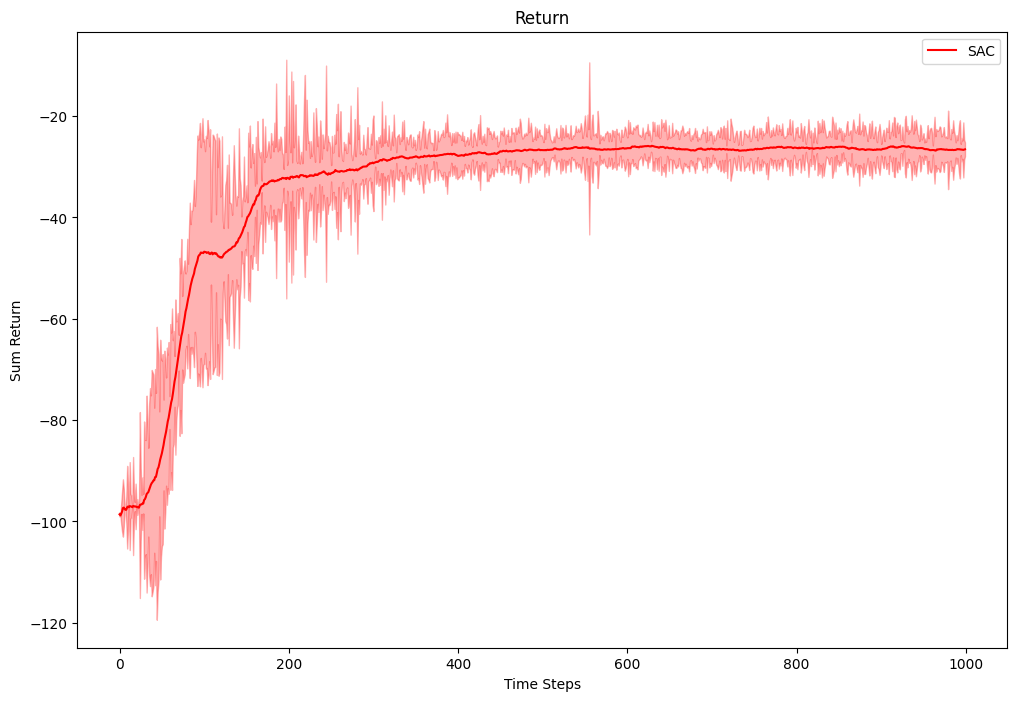

In [109]:
# plot ema returns
EMA_returns = np.array(EMA_returns)
plot_curves([EMA_returns], ['SAC'], ['r'], 'Sum Return', 'Return', smoothing = True)

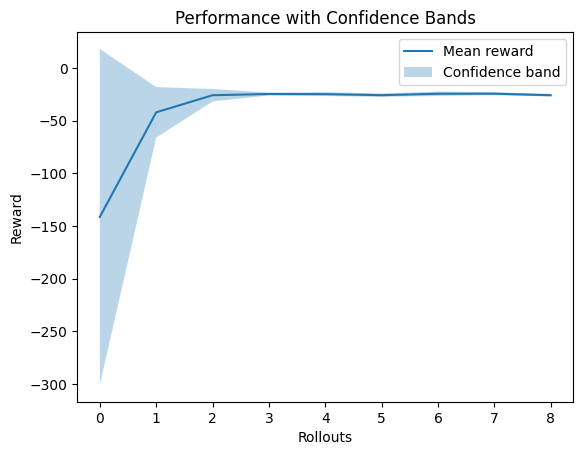

In [117]:
#plot ema eval returns
EMA_eval_returns = np.array(EMA_eval_returns)
#EMA_eval_returns = EMA_eval_returns[:, 1:-1, :]
import numpy as np
import matplotlib.pyplot as plt

# assuming `arr` is your (5, 9, 5) array

# average across episodes for each trial and rollout
mean_values = np.mean(EMA_eval_returns, axis=2)  # shape: (5, 9)
std_values = np.std(EMA_eval_returns, axis=2)    # shape: (5, 9)

# average across trials
mean_across_trials = np.mean(mean_values, axis=0)  # shape: (9,)
std_across_trials = np.std(mean_values, axis=0)    # shape: (9,)

# plot
x = np.arange(mean_across_trials.shape[0])  # rollouts

plt.plot(x, mean_across_trials, label="Mean reward")
plt.fill_between(x, mean_across_trials - std_across_trials,
                 mean_across_trials + std_across_trials, alpha=0.3, label="Confidence band")
plt.xlabel("Rollouts")
plt.ylabel("Reward")
plt.legend()
plt.title("Performance with Confidence Bands")
plt.show()



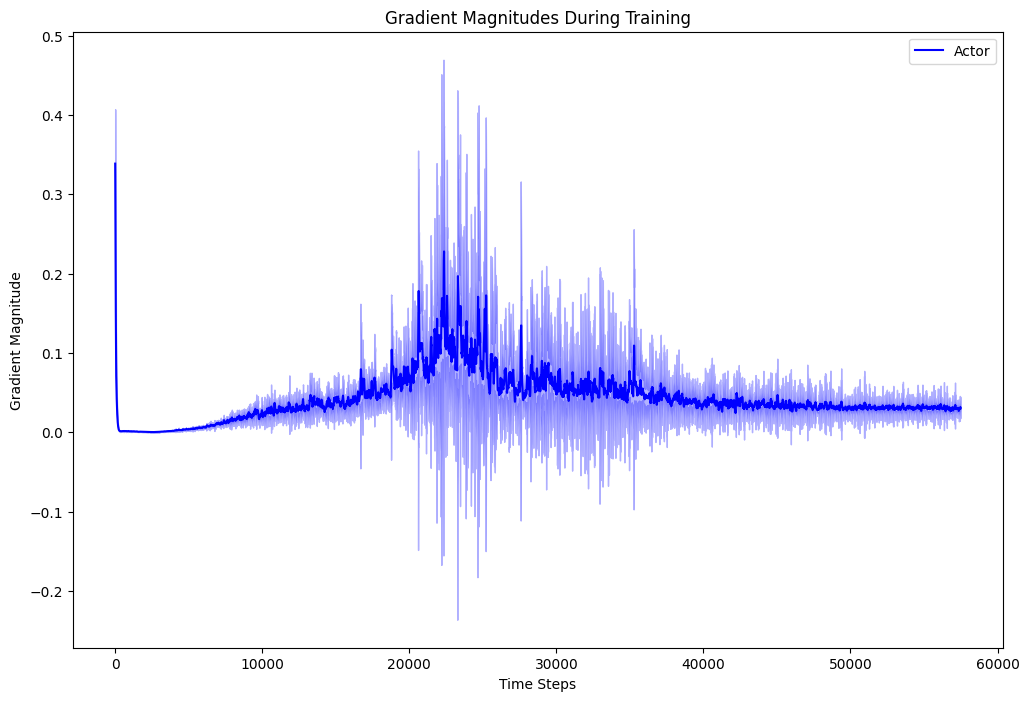

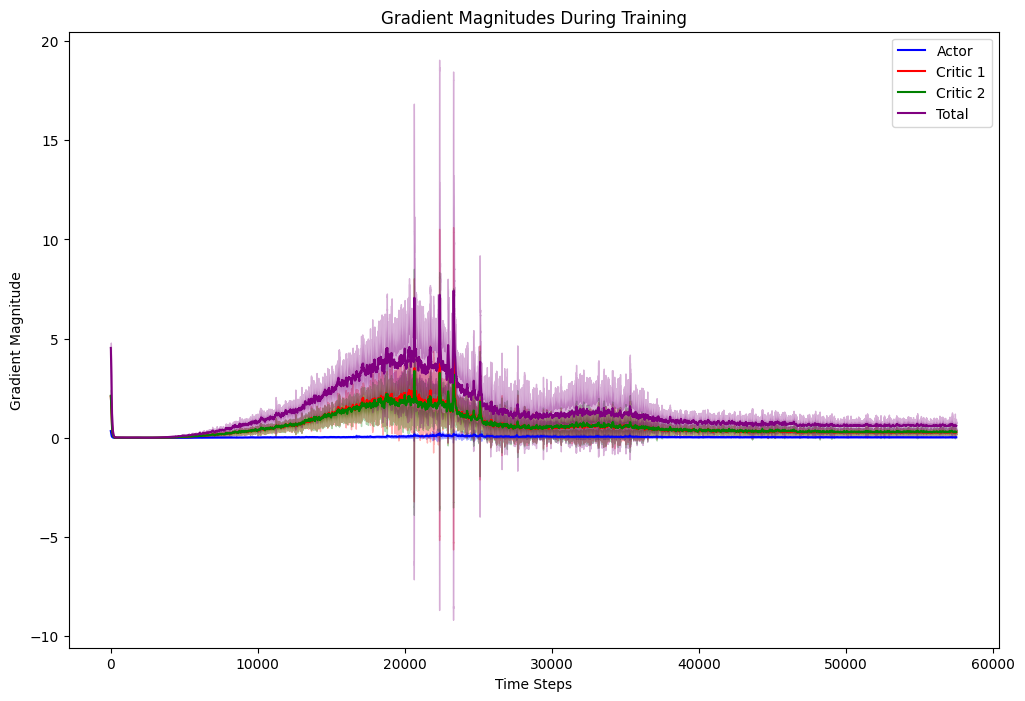

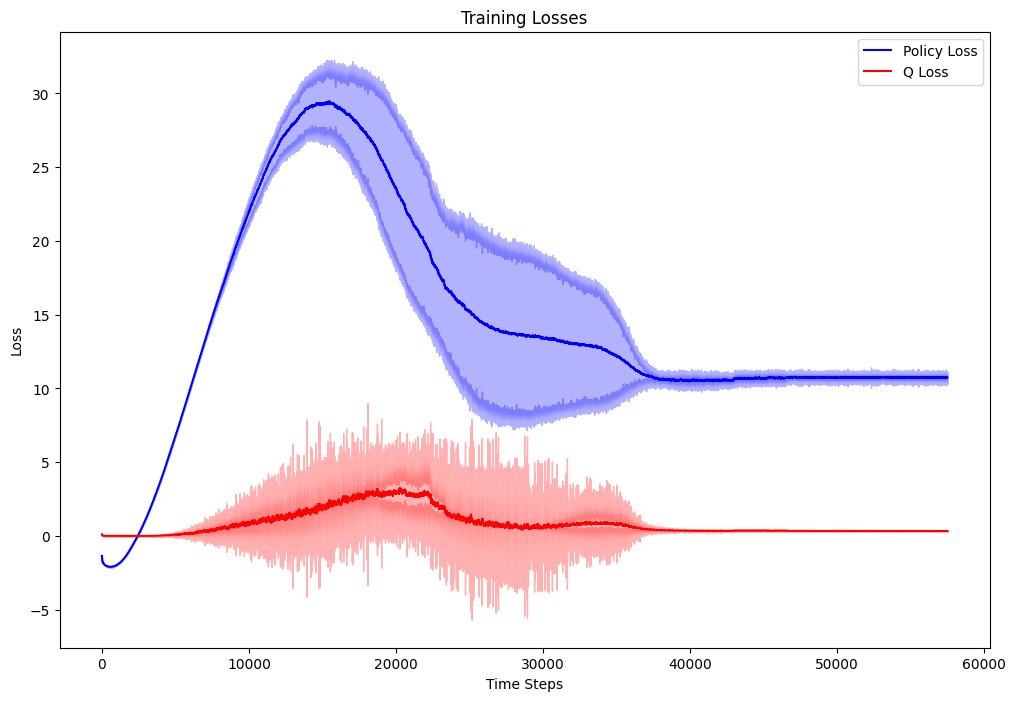

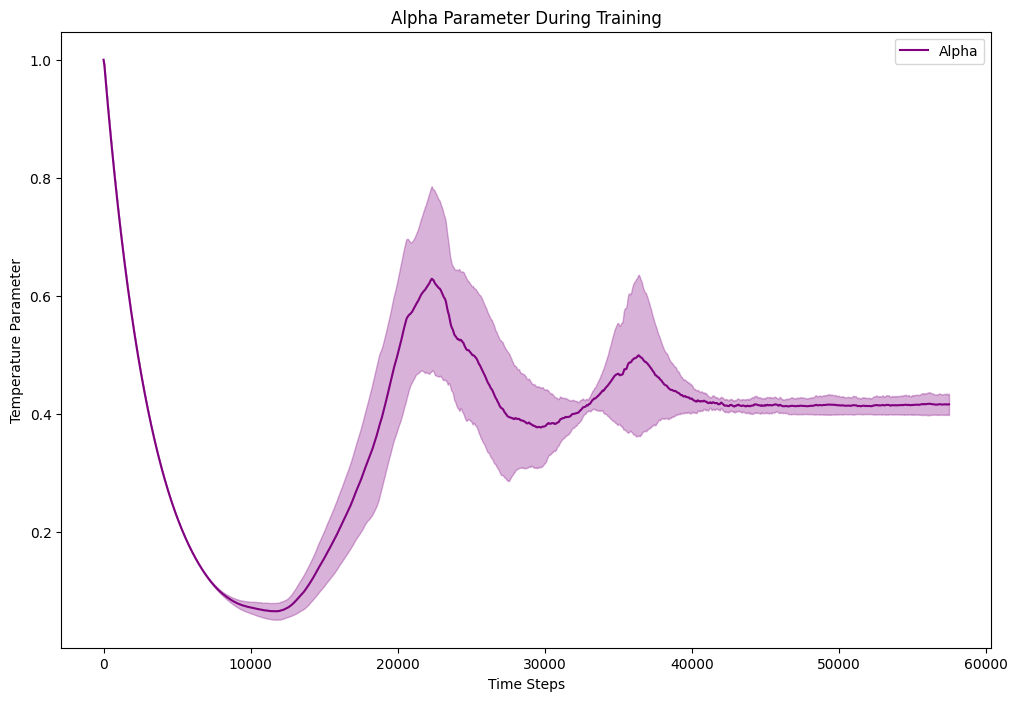

In [152]:
plot_training_metrics(EMA_grad_metrics, EMA_losses)

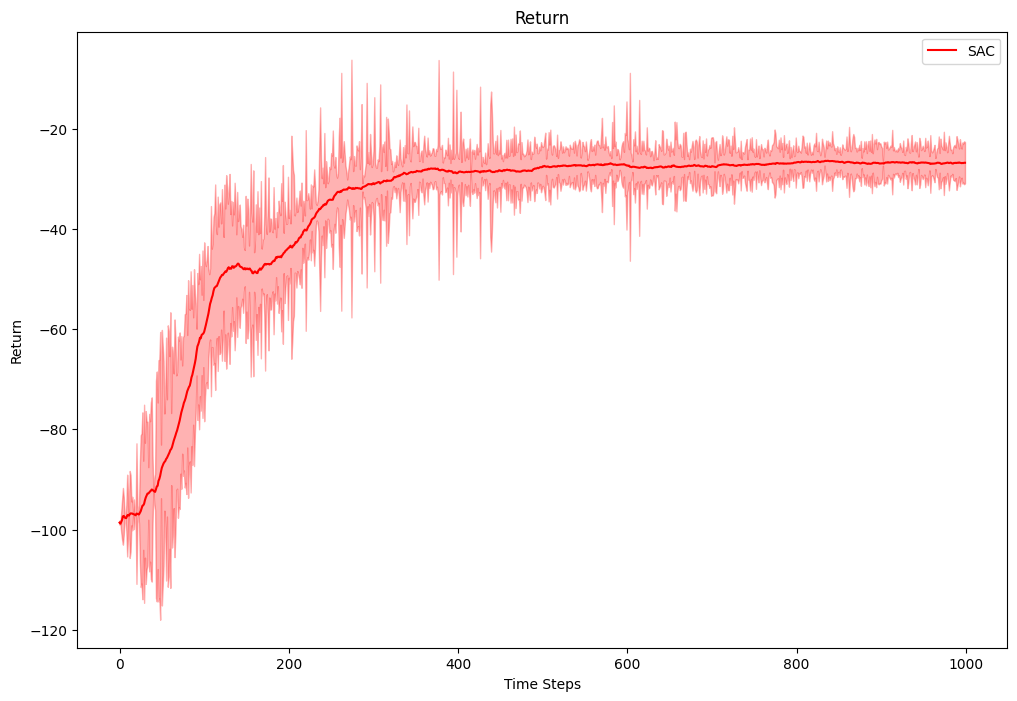

In [ ]:
# plotting
plot_curves([np.array(returns)], ['SAC'], ['r'], 'Return', 'Return', smoothing = True)

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import random
from collections import deque
from tqdm import tqdm
import gymnasium as gym
import os
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

# ----------------------------- Replay Buffer ----------------------------- #

class ReplayBuffer:
    def __init__(self, capacity, batch_size, state_dim, device):
        self.capacity = capacity
        self.batch_size = batch_size
        self.device = device
        self.ptr = 0
        self.size = 0

        # Preallocate tensors for efficiency
        self.states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.actions = torch.zeros((capacity, 1), dtype=torch.long, device=device)
        self.rewards = torch.zeros((capacity, 1), dtype=torch.float32, device=device)
        self.next_states = torch.zeros((capacity, state_dim), dtype=torch.float32, device=device)
        self.dones = torch.zeros((capacity, 1), dtype=torch.float32, device=device)

    def add(self, state, action, reward, next_state, done):
        self.states[self.ptr] = torch.from_numpy(state).float()
        self.actions[self.ptr] = torch.tensor([action], dtype=torch.long)
        self.rewards[self.ptr] = torch.tensor([reward], dtype=torch.float32)
        self.next_states[self.ptr] = torch.from_numpy(next_state).float()
        self.dones[self.ptr] = torch.tensor([done], dtype=torch.float32)

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self):
        indices = torch.randint(0, self.size, (self.batch_size,), device=self.device)
        return (
            self.states[indices],
            self.actions[indices],
            self.rewards[indices],
            self.next_states[indices],
            self.dones[indices]
        )

    def __len__(self):
        return self.size

# ----------------------------- Networks ----------------------------- #

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)
        
    def get_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(next(self.parameters()).device)
        probs = self.forward(state)
        dist = Categorical(probs)
        if evaluate:
            action = torch.argmax(probs, dim=-1)
        else:  
            action = dist.sample()
        return action.item()

class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class SACAgentLunarEMA:
    def __init__(self, state_dim, action_dim, hidden_dim=256, lr=3e-4, gamma=0.99, tau=0.005, device="cpu", initial_alpha=0.2):
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.action_dim = action_dim
        
        # Initialize networks
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.critic1 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2 = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic1_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic2_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        
        # Copy parameters to targets
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        
        # Initialize optimizers with proper hyperparameters
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr, eps=1e-4)
        self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=lr, eps=1e-4)
        self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=lr, eps=1e-4)
        
        # Initialize temperature parameter with alpha=0.2
        self.target_entropy = 0.6 * (-np.log(1 / action_dim))  # Target entropy
        self.log_alpha = torch.tensor(np.log(initial_alpha), dtype=torch.float32, requires_grad=True, device=device)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=lr, eps=1e-4)
        self.alpha = self.log_alpha.exp().item()
        self.H_mean = 0  # Track entropy
        
    @property
    def alpha_value(self):
        return self.log_alpha.exp().item()
    
    def get_action(self, state, evaluate=False):
        return self.actor.get_action(state, evaluate)
    
    def update(self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, actor_grads, critic_1_grads, critic_2_grads):
        with torch.no_grad():
            next_probs = self.actor(next_state_batch)
            next_log_probs = torch.log(next_probs + 1e-8)
            q1_next = self.critic1_target(next_state_batch)
            q2_next = self.critic2_target(next_state_batch)
            min_q_next = torch.min(q1_next, q2_next)
            target_q = (next_probs * (min_q_next - self.alpha * next_log_probs)).sum(dim=1, keepdim=True)
            target_q = reward_batch + (1 - done_batch) * self.gamma * target_q
    
        current_q1 = self.critic1(state_batch).gather(1, action_batch)
        current_q2 = self.critic2(state_batch).gather(1, action_batch)
        
        critic1_loss = F.mse_loss(current_q1, target_q)
        critic2_loss = F.mse_loss(current_q2, target_q)
        
        # Apply EMA to gradients
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        critic_1_grads = gradfilter_ema(self.critic1, critic_1_grads, alpha=0.98, lamb=2.0)
        self.critic1_optimizer.step()
        
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        critic_2_grads = gradfilter_ema(self.critic2, critic_2_grads, alpha=0.98, lamb=2.0)
        self.critic2_optimizer.step()
        
        # Actor update with EMA gradients
        probs = self.actor(state_batch)
        log_probs = torch.log(probs + 1e-8)
        q1 = self.critic1(state_batch).detach()  # [batch, action_dim]
        q2 = self.critic2(state_batch).detach()  # [batch, action_dim]
        min_q = torch.min(q1, q2)
        actor_loss = (probs * (self.alpha * log_probs - min_q)).sum(dim=1).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_grads = gradfilter_ema(self.actor, actor_grads, alpha=0.98, lamb=2.0)
        self.actor_optimizer.step()
        
        # Track EMA gradients
        grad_stats = track_ema_grad_stats(actor_grads, critic_1_grads, critic_2_grads)

        with torch.no_grad():
            self.H_mean = -(probs * log_probs).sum(dim=1).mean()
        alpha_loss = self.log_alpha * (self.H_mean - self.target_entropy)
        
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        # Update alpha value
        self.alpha = self.alpha_value

        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)
        
        return actor_grads, critic_1_grads, critic_2_grads, grad_stats, {
            'critic1_loss': critic1_loss.item(),
            'critic2_loss': critic2_loss.item(),
            'actor_loss': actor_loss.item(),
            'alpha': self.alpha
        }
    
    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
    
    def save(self, timestep, EnvName):
        os.makedirs("models", exist_ok=True)
        torch.save(self.actor.state_dict(), f"./models/sacd_actor_EMA_{timestep}_{EnvName}.pth")
        torch.save(self.critic1.state_dict(), f"./models/sacd_critic1_EMA_{timestep}_{EnvName}.pth")
        torch.save(self.critic2.state_dict(), f"./models/sacd_critic2_EMA_{timestep}_{EnvName}.pth")
    
    def load(self, timestep, EnvName):
        self.actor.load_state_dict(torch.load(f"./models/sacd_actor_EMA_{timestep}_{EnvName}.pth", map_location=self.device))
        self.critic1.load_state_dict(torch.load(f"./models/sacd_critic1_EMA_{timestep}_{EnvName}.pth", map_location=self.device))
        self.critic2.load_state_dict(torch.load(f"./models/sacd_critic2_EMA_{timestep}_{EnvName}.pth", map_location=self.device))

# ----------------------------- Training and Evaluation ----------------------------- #

def compute_discounted_return(rewards, gamma):
    """Compute the discounted return by iterating backwards through the rewards."""
    discounted_return = 0.0
    for r in reversed(rewards):
        discounted_return = r + gamma * discounted_return
    return discounted_return

def evaluate_agent(env, agent, num_episodes=5, gamma=0.99):
    """Evaluate agent with both sum of rewards and discounted returns."""
    agent.actor.eval()
    sum_returns = []
    discounted_returns = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0.0
        episode_rewards = []
        while not done:
            action = agent.get_action(state, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            episode_rewards.append(reward)
            state = next_state
        sum_returns.append(total_reward)
        discounted_returns.append(compute_discounted_return(episode_rewards, gamma))
    agent.actor.train()
    return np.mean(sum_returns), np.mean(discounted_returns)

def set_seed(seed, env):
    """Set seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.reset(seed=seed)

def train_sac_lunar_ema(num_trials=5, num_steps=400_000, buffer_capacity=1_000_000, batch_size=256,
                     prepopulate_steps=10_000, eval_interval=10, num_eval_episodes=5, gamma=0.99, steps_per_update=50, updates_per_step=50):
    """Run multiple trials for Lunar Lander with SAC and EMA gradient tracking"""
    all_returns = []
    all_disc_returns = []
    all_eval_returns = []
    all_eval_disc = []
    all_losses = []
    all_grad_metrics = []
    
    for trial in range(num_trials):
        print(f"\nTrial {trial + 1}/{num_trials}")
        
        # Set seeds
        seed = trial
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        
        env = gym.make("LunarLander-v2")
        eval_env = gym.make("LunarLander-v2")
        env.reset(seed=seed)
        eval_env.reset(seed=seed+1000)
        
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        agent = SACAgentLunarEMA(state_dim, action_dim, hidden_dim=200, lr=3e-4,
                           gamma=gamma, tau=0.005, device=device, initial_alpha=0.2)
        buffer = ReplayBuffer(buffer_capacity, batch_size, state_dim, device)
        
        returns = deque(maxlen=100)
        returns_over_steps = []
        discounted_returns = []
        eval_returns_sum = []
        eval_returns_discounted = []
        policy_losses = []
        q_losses = []
        alphas = []
        actor_grads = None
        critic_1_grads = None
        critic_2_grads = None
        grad_metrics = {
            'actor_grad_mag': [],
            'critic1_grad_mag': [],
            'critic2_grad_mag': [],
            'total_grad_mag': []
        }

        best_eval_return = float('-inf')
        
        # Prepopulate buffer
        state, _ = env.reset()
        pbar = tqdm(range(prepopulate_steps), desc="Prepopulating buffer")
        for _ in pbar:
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if reward <= -100:
                reward = -10.0
            
            buffer.add(state, action, reward, next_state, done)
            
            if done:
                state, _ = env.reset()
            else:
                state = next_state
        
        # Training loop
        total_steps = 0
        episode = 0
        state, _ = env.reset()
        episode_rewards = []
        
        pbar = tqdm(range(num_steps), desc=f"Training Trial {trial+1}")
        for step in pbar:
            total_steps += 1
            
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_rewards.append(reward)
            
            if reward <= -100:
                reward = -10.0
            
            buffer.add(state, action, reward, next_state, done)
            
            if len(buffer) >= batch_size and total_steps % steps_per_update == 0:
                for _ in range(updates_per_step):
                    actor_grads, critic_1_grads, critic_2_grads, grad_stats, loss_dict = agent.update(
                        *buffer.sample(), actor_grads, critic_1_grads, critic_2_grads)
                    
                    for key, value in grad_stats.items():
                        grad_metrics[key].append(value)
                    
                    policy_losses.append(loss_dict['actor_loss'])
                    q_losses.append((loss_dict['critic1_loss'] + loss_dict['critic2_loss']) / 2)
                    alphas.append(loss_dict['alpha'])
            
            if done:
                sum_return = sum(episode_rewards)
                discounted_return = compute_discounted_return(episode_rewards, gamma)
                
                returns.append(sum_return)
                returns_over_steps.append(sum_return)
                discounted_returns.append(discounted_return)
                episode_rewards = []
                state, _ = env.reset()
                episode += 1
                
                if episode % eval_interval == 0:
                    eval_return_sum, eval_return_disc = evaluate_agent(eval_env, agent, num_eval_episodes, gamma)
                    eval_returns_sum.append(eval_return_sum)
                    eval_returns_discounted.append(eval_return_disc)
                    print(f"\nStep {total_steps}, Episode {episode}, Eval Return Sum: {eval_return_sum:.1f}, Eval Return Discounted: {eval_return_disc:.1f}")
                    # Save best model
                    if eval_return_sum > best_eval_return:
                        best_eval_return = eval_return_sum
                        agent.save(total_steps, "LunarLander")
                        print(f"New best model saved with Eval Return Sum: {eval_return_sum:.1f}")
                

                
                mean_return = np.mean(list(returns))
                # Add EMA gradient magnitudes to description
                recent_grads = {k: np.mean(v[-100:]) for k, v in grad_metrics.items() if v}
                desc = (f"Trial: {trial+1} | Step: {step} | Episode: {episode} | Return: {sum_return:.1f} | "
                       f"Discounted: {discounted_return:.1f} | Avg100: {mean_return:.1f} | "
                       f"EMA Actor Grad: {recent_grads.get('actor_grad_mag', 0):.3f} | "
                       f"EMA Critic Grads: {recent_grads.get('critic1_grad_mag', 0):.3f}, "
                       f"{recent_grads.get('critic2_grad_mag', 0):.3f}")
                pbar.set_description(desc)
            else:
                state = next_state
        
        # Store trial results
        all_returns.append(returns_over_steps)
        all_disc_returns.append(discounted_returns)
        all_eval_returns.append(eval_returns_sum)
        all_eval_disc.append(eval_returns_discounted)
        all_grad_metrics.append(grad_metrics)
        all_losses.append({
            'policy_loss': policy_losses,
            'q_loss': q_losses,
            'alpha': alphas
        })
        
        env.close()
        eval_env.close()
    
    return agent, all_returns, all_disc_returns, all_eval_returns, all_eval_disc, all_losses, all_grad_metrics

In [104]:
# Define parameters directly
env_name = 'LunarLander-v2'
prepopulate_steps = 10_000
batch_size = 256
buffer_capacity = 100_000
num_train_steps = 500_000
eval_interval = 10
num_eval_episodes = 5
gamma = 0.99
    
# Create environment
env = gym.make(env_name)
    
# Train SAC Agent
lunarSACAgent_ema, returns_over_steps_ema, discounted_returns_ema, eval_returns_sum_ema, eval_returns_discount_ema, losses_ema, grad_metrics_ema = train_sac_lunar_ema(
        num_trials=1,
        num_steps=num_train_steps,
        buffer_capacity=buffer_capacity,
        batch_size=batch_size,
        prepopulate_steps=prepopulate_steps,
        eval_interval=eval_interval,
        num_eval_episodes=num_eval_episodes,
        gamma=gamma)


Trial 1/1


Prepopulating buffer: 100%|██████████| 10000/10000 [00:00<00:00, 10141.92it/s]
Trial: 1 | Step: 1921 | Episode: 10 | Return: -136.1 | Discounted: -25.3 | Avg100: -573.5 | EMA Actor Grad: 0.103 | EMA Critic Grads: 5.554, 5.381:   0%|          | 1926/500000 [00:14<5:57:18, 23.23it/s]


Step 1922, Episode 10, Eval Return Sum: -100.6, Eval Return Discounted: 9.7
New best model saved with Eval Return Sum: -100.6


Trial: 1 | Step: 7240 | Episode: 20 | Return: -10.5 | Discounted: 4.8 | Avg100: -298.8 | EMA Actor Grad: 0.099 | EMA Critic Grads: 12.674, 12.229:   1%|▏         | 7241/500000 [00:44<4:46:16, 28.69it/s]  


Step 7241, Episode 20, Eval Return Sum: 31.2, Eval Return Discounted: 26.8
New best model saved with Eval Return Sum: 31.2


Trial: 1 | Step: 12236 | Episode: 30 | Return: 144.9 | Discounted: 32.2 | Avg100: -177.5 | EMA Actor Grad: 0.079 | EMA Critic Grads: 13.325, 12.870:   2%|▏         | 12237/500000 [01:09<2:01:01, 67.17it/s]


Step 12237, Episode 30, Eval Return Sum: 143.6, Eval Return Discounted: 26.0
New best model saved with Eval Return Sum: 143.6


Trial: 1 | Step: 19759 | Episode: 40 | Return: 113.4 | Discounted: 46.4 | Avg100: -105.8 | EMA Actor Grad: 0.072 | EMA Critic Grads: 13.203, 12.324:   4%|▍         | 19800/500000 [01:50<3:42:26, 35.98it/s]  


Step 19760, Episode 40, Eval Return Sum: 42.0, Eval Return Discounted: 15.7


Trial: 1 | Step: 28243 | Episode: 50 | Return: 30.8 | Discounted: 17.0 | Avg100: -71.2 | EMA Actor Grad: 0.073 | EMA Critic Grads: 12.406, 11.815:   6%|▌         | 28244/500000 [02:34<3:18:41, 39.57it/s]   


Step 28244, Episode 50, Eval Return Sum: 51.2, Eval Return Discounted: 32.6


Trial: 1 | Step: 37485 | Episode: 60 | Return: 111.7 | Discounted: 63.0 | Avg100: -44.7 | EMA Actor Grad: 0.128 | EMA Critic Grads: 12.436, 11.561:   8%|▊         | 37501/500000 [03:24<2:43:05, 47.26it/s]


Step 37486, Episode 60, Eval Return Sum: -8.1, Eval Return Discounted: 28.1


Trial: 1 | Step: 46986 | Episode: 70 | Return: 124.8 | Discounted: 42.1 | Avg100: -22.8 | EMA Actor Grad: 0.108 | EMA Critic Grads: 18.096, 17.604:   9%|▉         | 46987/500000 [04:11<1:46:39, 70.79it/s] 


Step 46987, Episode 70, Eval Return Sum: 212.6, Eval Return Discounted: 46.0
New best model saved with Eval Return Sum: 212.6


Trial: 1 | Step: 55670 | Episode: 80 | Return: 156.1 | Discounted: 45.8 | Avg100: -4.2 | EMA Actor Grad: 0.118 | EMA Critic Grads: 12.159, 10.451:  11%|█         | 55671/500000 [04:58<1:48:06, 68.50it/s]  


Step 55671, Episode 80, Eval Return Sum: 238.6, Eval Return Discounted: 48.8
New best model saved with Eval Return Sum: 238.6


Trial: 1 | Step: 63980 | Episode: 90 | Return: 151.9 | Discounted: 71.7 | Avg100: 7.5 | EMA Actor Grad: 0.097 | EMA Critic Grads: 17.517, 17.962:  13%|█▎        | 63981/500000 [05:46<3:01:21, 40.07it/s]  


Step 63981, Episode 90, Eval Return Sum: 196.1, Eval Return Discounted: 42.0


Trial: 1 | Step: 73168 | Episode: 100 | Return: 149.7 | Discounted: 45.5 | Avg100: 19.8 | EMA Actor Grad: 0.101 | EMA Critic Grads: 17.243, 14.330:  15%|█▍        | 73171/500000 [06:32<1:42:10, 69.62it/s]


Step 73169, Episode 100, Eval Return Sum: 226.4, Eval Return Discounted: 35.9


Trial: 1 | Step: 81514 | Episode: 110 | Return: 129.7 | Discounted: 37.3 | Avg100: 86.1 | EMA Actor Grad: 0.090 | EMA Critic Grads: 18.143, 16.047:  16%|█▋        | 81522/500000 [07:15<3:05:59, 37.50it/s] 


Step 81515, Episode 110, Eval Return Sum: 68.0, Eval Return Discounted: 16.8


Trial: 1 | Step: 88946 | Episode: 120 | Return: 129.0 | Discounted: 57.9 | Avg100: 96.8 | EMA Actor Grad: 0.081 | EMA Critic Grads: 13.632, 12.531:  18%|█▊        | 88964/500000 [07:54<55:35, 123.25it/s]  


Step 88947, Episode 120, Eval Return Sum: 93.7, Eval Return Discounted: 15.2


Trial: 1 | Step: 95763 | Episode: 130 | Return: 141.1 | Discounted: 66.4 | Avg100: 94.3 | EMA Actor Grad: 0.094 | EMA Critic Grads: 22.059, 15.791:  19%|█▉        | 95772/500000 [08:27<1:38:39, 68.29it/s] 


Step 95764, Episode 130, Eval Return Sum: 185.1, Eval Return Discounted: 43.1


Trial: 1 | Step: 103607 | Episode: 140 | Return: 155.8 | Discounted: 55.1 | Avg100: 95.2 | EMA Actor Grad: 0.065 | EMA Critic Grads: 5.589, 6.065:  21%|██        | 103621/500000 [09:05<1:45:02, 62.89it/s]


Step 103608, Episode 140, Eval Return Sum: 134.6, Eval Return Discounted: 40.2


Trial: 1 | Step: 112972 | Episode: 150 | Return: 169.9 | Discounted: 48.8 | Avg100: 100.6 | EMA Actor Grad: 0.055 | EMA Critic Grads: 4.701, 4.352:  23%|██▎       | 112973/500000 [09:49<54:53, 117.53it/s]


Step 112973, Episode 150, Eval Return Sum: 250.0, Eval Return Discounted: 47.5
New best model saved with Eval Return Sum: 250.0


Trial: 1 | Step: 122027 | Episode: 160 | Return: 144.0 | Discounted: 55.7 | Avg100: 108.3 | EMA Actor Grad: 0.059 | EMA Critic Grads: 4.799, 4.384:  24%|██▍       | 122028/500000 [10:32<50:11, 125.53it/s]


Step 122028, Episode 160, Eval Return Sum: 252.7, Eval Return Discounted: 54.2
New best model saved with Eval Return Sum: 252.7


Trial: 1 | Step: 131285 | Episode: 170 | Return: 149.7 | Discounted: 69.1 | Avg100: 110.8 | EMA Actor Grad: 0.060 | EMA Critic Grads: 5.874, 4.762:  26%|██▋       | 131303/500000 [11:16<45:46, 134.25it/s]


Step 131286, Episode 170, Eval Return Sum: 245.6, Eval Return Discounted: 53.8


Trial: 1 | Step: 139755 | Episode: 180 | Return: 166.4 | Discounted: 49.4 | Avg100: 117.7 | EMA Actor Grad: 0.053 | EMA Critic Grads: 3.629, 3.545:  28%|██▊       | 139771/500000 [11:57<39:55, 150.36it/s]


Step 139756, Episode 180, Eval Return Sum: 265.0, Eval Return Discounted: 64.1
New best model saved with Eval Return Sum: 265.0


Trial: 1 | Step: 149755 | Episode: 190 | Return: 185.7 | Discounted: 69.1 | Avg100: 124.4 | EMA Actor Grad: 0.052 | EMA Critic Grads: 2.932, 2.932:  30%|██▉       | 149772/500000 [12:45<40:45, 143.20it/s]


Step 149756, Episode 190, Eval Return Sum: 263.3, Eval Return Discounted: 61.2


Trial: 1 | Step: 158157 | Episode: 200 | Return: 149.2 | Discounted: 53.9 | Avg100: 127.5 | EMA Actor Grad: 0.049 | EMA Critic Grads: 3.199, 2.984:  32%|███▏      | 158170/500000 [13:26<38:32, 147.82it/s]


Step 158158, Episode 200, Eval Return Sum: 229.9, Eval Return Discounted: 63.5


Trial: 1 | Step: 165635 | Episode: 210 | Return: 185.7 | Discounted: 56.6 | Avg100: 131.8 | EMA Actor Grad: 0.042 | EMA Critic Grads: 2.882, 2.255:  33%|███▎      | 165636/500000 [14:00<31:00, 179.71it/s]


Step 165636, Episode 210, Eval Return Sum: 268.7, Eval Return Discounted: 64.6
New best model saved with Eval Return Sum: 268.7


Trial: 1 | Step: 174283 | Episode: 220 | Return: 146.9 | Discounted: 45.6 | Avg100: 139.4 | EMA Actor Grad: 0.052 | EMA Critic Grads: 3.332, 2.637:  35%|███▍      | 174284/500000 [14:40<35:39, 152.22it/s]


Step 174284, Episode 220, Eval Return Sum: 268.6, Eval Return Discounted: 73.5


Trial: 1 | Step: 183457 | Episode: 230 | Return: -255.1 | Discounted: -37.3 | Avg100: 146.0 | EMA Actor Grad: 0.056 | EMA Critic Grads: 2.690, 2.864:  37%|███▋      | 183473/500000 [15:27<30:50, 171.08it/s]


Step 183458, Episode 230, Eval Return Sum: 261.6, Eval Return Discounted: 65.7


Trial: 1 | Step: 193457 | Episode: 240 | Return: 132.2 | Discounted: 48.3 | Avg100: 149.6 | EMA Actor Grad: 0.049 | EMA Critic Grads: 3.222, 2.681:  39%|███▊      | 193500/500000 [16:14<52:15, 97.74it/s]   


Step 193458, Episode 240, Eval Return Sum: 83.6, Eval Return Discounted: 53.1


Trial: 1 | Step: 201504 | Episode: 250 | Return: 162.9 | Discounted: 53.9 | Avg100: 154.3 | EMA Actor Grad: 0.042 | EMA Critic Grads: 2.078, 2.080:  40%|████      | 201550/500000 [16:52<37:01, 134.32it/s]


Step 201505, Episode 250, Eval Return Sum: 268.5, Eval Return Discounted: 67.4


Trial: 1 | Step: 210935 | Episode: 260 | Return: 136.4 | Discounted: 48.8 | Avg100: 154.4 | EMA Actor Grad: 0.061 | EMA Critic Grads: 2.869, 2.578:  42%|████▏     | 210953/500000 [17:37<1:05:19, 73.74it/s]


Step 210936, Episode 260, Eval Return Sum: 278.3, Eval Return Discounted: 78.2
New best model saved with Eval Return Sum: 278.3


Trial: 1 | Step: 220935 | Episode: 270 | Return: 142.8 | Discounted: 48.2 | Avg100: 157.3 | EMA Actor Grad: 0.044 | EMA Critic Grads: 2.925, 2.606:  44%|████▍     | 220936/500000 [18:25<52:13, 89.05it/s]  


Step 220936, Episode 270, Eval Return Sum: 202.5, Eval Return Discounted: 59.8


Trial: 1 | Step: 230214 | Episode: 280 | Return: 167.4 | Discounted: 54.8 | Avg100: 156.0 | EMA Actor Grad: 0.037 | EMA Critic Grads: 2.114, 1.956:  46%|████▌     | 230250/500000 [19:09<27:23, 164.17it/s]


Step 230215, Episode 280, Eval Return Sum: 271.9, Eval Return Discounted: 78.4


Trial: 1 | Step: 239454 | Episode: 290 | Return: 285.8 | Discounted: 94.1 | Avg100: 156.3 | EMA Actor Grad: 0.036 | EMA Critic Grads: 1.696, 1.610:  48%|████▊     | 239473/500000 [19:51<23:10, 187.31it/s]


Step 239455, Episode 290, Eval Return Sum: 267.3, Eval Return Discounted: 78.1


Trial: 1 | Step: 248900 | Episode: 300 | Return: 185.8 | Discounted: 74.5 | Avg100: 157.8 | EMA Actor Grad: 0.056 | EMA Critic Grads: 1.858, 1.607:  50%|████▉     | 248921/500000 [20:36<42:01, 99.59it/s] 


Step 248901, Episode 300, Eval Return Sum: 230.1, Eval Return Discounted: 76.7


Trial: 1 | Step: 257870 | Episode: 310 | Return: 262.1 | Discounted: 68.4 | Avg100: 162.9 | EMA Actor Grad: 0.043 | EMA Critic Grads: 1.750, 1.873:  52%|█████▏    | 257872/500000 [21:19<58:48, 68.62it/s] 


Step 257871, Episode 310, Eval Return Sum: 222.2, Eval Return Discounted: 67.6


Trial: 1 | Step: 267229 | Episode: 320 | Return: 161.0 | Discounted: 82.0 | Avg100: 163.9 | EMA Actor Grad: 0.043 | EMA Critic Grads: 2.643, 2.351:  53%|█████▎    | 267250/500000 [22:03<25:12, 153.85it/s]


Step 267230, Episode 320, Eval Return Sum: 255.1, Eval Return Discounted: 69.9


Trial: 1 | Step: 275083 | Episode: 330 | Return: 263.7 | Discounted: 57.5 | Avg100: 173.3 | EMA Actor Grad: 0.112 | EMA Critic Grads: 3.112, 2.587:  55%|█████▌    | 275084/500000 [22:43<1:49:49, 34.13it/s]


Step 275084, Episode 330, Eval Return Sum: 116.0, Eval Return Discounted: 63.9


Trial: 1 | Step: 282931 | Episode: 340 | Return: 273.8 | Discounted: 61.4 | Avg100: 177.7 | EMA Actor Grad: 0.069 | EMA Critic Grads: 2.291, 2.337:  57%|█████▋    | 282952/500000 [23:20<21:34, 167.72it/s] 


Step 282932, Episode 340, Eval Return Sum: 267.5, Eval Return Discounted: 68.0


Trial: 1 | Step: 291280 | Episode: 350 | Return: 271.0 | Discounted: 90.2 | Avg100: 176.3 | EMA Actor Grad: 0.041 | EMA Critic Grads: 3.115, 3.169:  58%|█████▊    | 291281/500000 [24:01<20:44, 167.76it/s]


Step 291281, Episode 350, Eval Return Sum: 271.7, Eval Return Discounted: 67.7


Trial: 1 | Step: 299103 | Episode: 360 | Return: 161.7 | Discounted: 60.9 | Avg100: 179.3 | EMA Actor Grad: 0.042 | EMA Critic Grads: 2.803, 2.720:  60%|█████▉    | 299122/500000 [24:37<18:24, 181.85it/s]


Step 299104, Episode 360, Eval Return Sum: 264.4, Eval Return Discounted: 73.7


Trial: 1 | Step: 306662 | Episode: 370 | Return: 157.8 | Discounted: 63.9 | Avg100: 183.8 | EMA Actor Grad: 0.028 | EMA Critic Grads: 1.777, 1.551:  61%|██████▏   | 306700/500000 [25:12<28:10, 114.36it/s] 


Step 306663, Episode 370, Eval Return Sum: 214.3, Eval Return Discounted: 67.2


Trial: 1 | Step: 311374 | Episode: 380 | Return: 244.8 | Discounted: 55.5 | Avg100: 189.0 | EMA Actor Grad: 0.034 | EMA Critic Grads: 2.760, 2.561:  62%|██████▏   | 311375/500000 [25:34<30:56, 101.61it/s]


Step 311375, Episode 380, Eval Return Sum: 260.6, Eval Return Discounted: 79.2


Trial: 1 | Step: 317940 | Episode: 390 | Return: 178.5 | Discounted: 57.7 | Avg100: 193.9 | EMA Actor Grad: 0.039 | EMA Critic Grads: 3.248, 2.900:  64%|██████▎   | 317941/500000 [26:03<16:14, 186.84it/s]


Step 317941, Episode 390, Eval Return Sum: 275.5, Eval Return Discounted: 75.1


Trial: 1 | Step: 323481 | Episode: 400 | Return: 280.9 | Discounted: 68.9 | Avg100: 199.5 | EMA Actor Grad: 0.043 | EMA Critic Grads: 2.979, 3.063:  65%|██████▍   | 323502/500000 [26:29<18:02, 162.98it/s] 


Step 323482, Episode 400, Eval Return Sum: 271.3, Eval Return Discounted: 65.8


Trial: 1 | Step: 331144 | Episode: 410 | Return: 154.1 | Discounted: 49.4 | Avg100: 200.8 | EMA Actor Grad: 0.048 | EMA Critic Grads: 3.556, 3.243:  66%|██████▌   | 331145/500000 [27:05<19:21, 145.35it/s]


Step 331145, Episode 410, Eval Return Sum: 270.5, Eval Return Discounted: 81.0


Trial: 1 | Step: 339514 | Episode: 420 | Return: 266.9 | Discounted: 83.1 | Avg100: 200.9 | EMA Actor Grad: 0.046 | EMA Critic Grads: 2.860, 2.629:  68%|██████▊   | 339521/500000 [27:47<16:43, 159.85it/s]


Step 339515, Episode 420, Eval Return Sum: 284.4, Eval Return Discounted: 87.7
New best model saved with Eval Return Sum: 284.4


Trial: 1 | Step: 346357 | Episode: 430 | Return: 301.5 | Discounted: 64.4 | Avg100: 202.6 | EMA Actor Grad: 0.043 | EMA Critic Grads: 3.764, 3.146:  69%|██████▉   | 346370/500000 [28:23<34:55, 73.31it/s] 


Step 346358, Episode 430, Eval Return Sum: 251.1, Eval Return Discounted: 65.9


Trial: 1 | Step: 351645 | Episode: 440 | Return: 271.0 | Discounted: 78.3 | Avg100: 205.4 | EMA Actor Grad: 0.054 | EMA Critic Grads: 4.926, 3.961:  70%|███████   | 351646/500000 [28:50<25:19, 97.66it/s] 


Step 351646, Episode 440, Eval Return Sum: 255.0, Eval Return Discounted: 64.4


Trial: 1 | Step: 358580 | Episode: 450 | Return: 293.0 | Discounted: 96.1 | Avg100: 210.6 | EMA Actor Grad: 0.055 | EMA Critic Grads: 3.887, 3.503:  72%|███████▏  | 358581/500000 [29:29<22:30, 104.72it/s]


Step 358581, Episode 450, Eval Return Sum: 233.5, Eval Return Discounted: 72.4


Trial: 1 | Step: 364516 | Episode: 460 | Return: 272.4 | Discounted: 71.3 | Avg100: 210.2 | EMA Actor Grad: 0.087 | EMA Critic Grads: 5.333, 4.519:  73%|███████▎  | 364522/500000 [30:00<18:08, 124.47it/s]


Step 364517, Episode 460, Eval Return Sum: 261.6, Eval Return Discounted: 72.9


Trial: 1 | Step: 373650 | Episode: 470 | Return: 160.6 | Discounted: 80.4 | Avg100: 203.1 | EMA Actor Grad: 0.054 | EMA Critic Grads: 5.155, 4.318:  75%|███████▍  | 373670/500000 [30:46<30:31, 68.96it/s] 


Step 373651, Episode 470, Eval Return Sum: 220.0, Eval Return Discounted: 58.2


Trial: 1 | Step: 381828 | Episode: 480 | Return: 168.7 | Discounted: 54.7 | Avg100: 195.6 | EMA Actor Grad: 0.057 | EMA Critic Grads: 4.311, 3.455:  76%|███████▋  | 381829/500000 [31:26<20:28, 96.17it/s] 


Step 381829, Episode 480, Eval Return Sum: 251.5, Eval Return Discounted: 81.3


Trial: 1 | Step: 388439 | Episode: 490 | Return: 171.4 | Discounted: 60.3 | Avg100: 188.1 | EMA Actor Grad: 0.051 | EMA Critic Grads: 4.684, 3.927:  78%|███████▊  | 388459/500000 [31:58<11:18, 164.31it/s]  


Step 388440, Episode 490, Eval Return Sum: 272.3, Eval Return Discounted: 79.6


Trial: 1 | Step: 394743 | Episode: 500 | Return: 253.0 | Discounted: 67.5 | Avg100: 186.6 | EMA Actor Grad: 0.051 | EMA Critic Grads: 4.617, 4.145:  79%|███████▉  | 394744/500000 [32:28<13:01, 134.75it/s]


Step 394744, Episode 500, Eval Return Sum: 183.4, Eval Return Discounted: 63.0


Trial: 1 | Step: 401283 | Episode: 510 | Return: 255.7 | Discounted: 75.2 | Avg100: 187.5 | EMA Actor Grad: 0.048 | EMA Critic Grads: 5.358, 4.814:  80%|████████  | 401284/500000 [32:59<08:34, 191.89it/s]


Step 401284, Episode 510, Eval Return Sum: 266.3, Eval Return Discounted: 65.9


Trial: 1 | Step: 407274 | Episode: 520 | Return: 158.8 | Discounted: 63.5 | Avg100: 192.0 | EMA Actor Grad: 0.047 | EMA Critic Grads: 5.714, 4.143:  81%|████████▏ | 407275/500000 [33:30<09:31, 162.26it/s] 


Step 407275, Episode 520, Eval Return Sum: 282.3, Eval Return Discounted: 67.0


Trial: 1 | Step: 414182 | Episode: 530 | Return: 167.3 | Discounted: 84.0 | Avg100: 190.4 | EMA Actor Grad: 0.050 | EMA Critic Grads: 3.683, 3.291:  83%|████████▎ | 414183/500000 [34:03<08:35, 166.53it/s]


Step 414183, Episode 530, Eval Return Sum: 272.0, Eval Return Discounted: 77.5


Trial: 1 | Step: 420104 | Episode: 540 | Return: 165.2 | Discounted: 81.8 | Avg100: 191.0 | EMA Actor Grad: 0.053 | EMA Critic Grads: 4.615, 4.362:  84%|████████▍ | 420121/500000 [34:31<08:21, 159.30it/s]


Step 420105, Episode 540, Eval Return Sum: 271.9, Eval Return Discounted: 70.2


Trial: 1 | Step: 428431 | Episode: 550 | Return: 278.5 | Discounted: 99.3 | Avg100: 188.4 | EMA Actor Grad: 0.057 | EMA Critic Grads: 5.616, 4.379:  86%|████████▌ | 428451/500000 [35:11<07:22, 161.61it/s] 


Step 428432, Episode 550, Eval Return Sum: 274.9, Eval Return Discounted: 71.8


Trial: 1 | Step: 434404 | Episode: 560 | Return: 164.2 | Discounted: 57.9 | Avg100: 191.7 | EMA Actor Grad: 0.064 | EMA Critic Grads: 4.516, 3.825:  87%|████████▋ | 434421/500000 [35:41<09:15, 118.04it/s] 


Step 434405, Episode 560, Eval Return Sum: 229.9, Eval Return Discounted: 63.3


Trial: 1 | Step: 439926 | Episode: 570 | Return: 248.2 | Discounted: 68.3 | Avg100: 200.5 | EMA Actor Grad: 0.037 | EMA Critic Grads: 4.080, 4.038:  88%|████████▊ | 439927/500000 [36:08<08:41, 115.28it/s]


Step 439927, Episode 570, Eval Return Sum: 246.0, Eval Return Discounted: 65.2


Trial: 1 | Step: 446817 | Episode: 580 | Return: 272.5 | Discounted: 71.2 | Avg100: 204.3 | EMA Actor Grad: 0.045 | EMA Critic Grads: 5.231, 4.685:  89%|████████▉ | 446850/500000 [36:41<05:14, 169.21it/s] 


Step 446818, Episode 580, Eval Return Sum: 283.9, Eval Return Discounted: 79.2


Trial: 1 | Step: 451708 | Episode: 590 | Return: 272.8 | Discounted: 74.7 | Avg100: 214.1 | EMA Actor Grad: 0.060 | EMA Critic Grads: 5.450, 4.222:  90%|█████████ | 451723/500000 [37:04<04:24, 182.56it/s]


Step 451709, Episode 590, Eval Return Sum: 271.1, Eval Return Discounted: 76.6


Trial: 1 | Step: 455324 | Episode: 600 | Return: 271.3 | Discounted: 71.3 | Avg100: 218.2 | EMA Actor Grad: 0.040 | EMA Critic Grads: 4.697, 3.814:  91%|█████████ | 455325/500000 [37:21<04:35, 162.30it/s] 


Step 455325, Episode 600, Eval Return Sum: 275.0, Eval Return Discounted: 75.5


Trial: 1 | Step: 462934 | Episode: 610 | Return: 292.3 | Discounted: 97.9 | Avg100: 217.8 | EMA Actor Grad: 0.045 | EMA Critic Grads: 5.158, 4.315:  93%|█████████▎| 462935/500000 [37:59<03:45, 164.46it/s]


Step 462935, Episode 610, Eval Return Sum: 277.9, Eval Return Discounted: 79.5


Trial: 1 | Step: 469269 | Episode: 620 | Return: 173.4 | Discounted: 71.2 | Avg100: 216.6 | EMA Actor Grad: 0.050 | EMA Critic Grads: 4.730, 4.085:  94%|█████████▍| 469300/500000 [38:30<03:18, 154.81it/s] 


Step 469270, Episode 620, Eval Return Sum: 276.6, Eval Return Discounted: 74.4


Trial: 1 | Step: 475208 | Episode: 630 | Return: 125.7 | Discounted: 43.9 | Avg100: 218.7 | EMA Actor Grad: 0.055 | EMA Critic Grads: 5.988, 4.634:  95%|█████████▌| 475221/500000 [39:00<02:55, 141.53it/s] 


Step 475209, Episode 630, Eval Return Sum: 272.3, Eval Return Discounted: 69.1


Trial: 1 | Step: 482533 | Episode: 640 | Return: 139.4 | Discounted: 54.0 | Avg100: 215.8 | EMA Actor Grad: 0.057 | EMA Critic Grads: 6.112, 5.389:  97%|█████████▋| 482534/500000 [39:37<01:47, 162.29it/s]


Step 482534, Episode 640, Eval Return Sum: 281.7, Eval Return Discounted: 71.9


Trial: 1 | Step: 487726 | Episode: 650 | Return: 257.9 | Discounted: 72.3 | Avg100: 220.3 | EMA Actor Grad: 0.053 | EMA Critic Grads: 4.700, 3.847:  98%|█████████▊| 487750/500000 [40:02<01:12, 169.19it/s]


Step 487727, Episode 650, Eval Return Sum: 284.4, Eval Return Discounted: 82.7


Trial: 1 | Step: 491315 | Episode: 660 | Return: 240.8 | Discounted: 70.8 | Avg100: 220.1 | EMA Actor Grad: 0.053 | EMA Critic Grads: 3.601, 3.074:  98%|█████████▊| 491324/500000 [40:19<01:24, 102.95it/s] 


Step 491316, Episode 660, Eval Return Sum: 242.8, Eval Return Discounted: 68.7


Trial: 1 | Step: 496670 | Episode: 670 | Return: 260.8 | Discounted: 68.1 | Avg100: 219.8 | EMA Actor Grad: 0.044 | EMA Critic Grads: 4.864, 4.505:  99%|█████████▉| 496674/500000 [40:47<01:08, 48.66it/s] 


Step 496671, Episode 670, Eval Return Sum: 207.6, Eval Return Discounted: 70.1


Trial: 1 | Step: 499657 | Episode: 677 | Return: 267.1 | Discounted: 76.8 | Avg100: 223.0 | EMA Actor Grad: 0.063 | EMA Critic Grads: 5.388, 4.619: 100%|██████████| 500000/500000 [41:02<00:00, 203.02it/s]


In [105]:

if np.array(returns_over_steps_ema).ndim == 1:
    returns_over_steps_ema = np.expand_dims(returns_over_steps, axis=0)

if np.array(discounted_returns_ema).ndim == 1:
    discounted_returns_ema = np.expand_dims(discounted_returns, axis=0)

if np.array(eval_returns_sum_ema).ndim == 1:
    eval_returns_sum_ema = np.expand_dims(eval_returns_sum, axis=0)
if np.array(eval_returns_discount_ema).ndim == 1:
    eval_returns_discount_ema = np.expand_dims(eval_returns_discount, axis=0)

In [106]:
evaluate_agent

<function __main__.evaluate_agent(env, agent, num_episodes=5, gamma=0.99)>

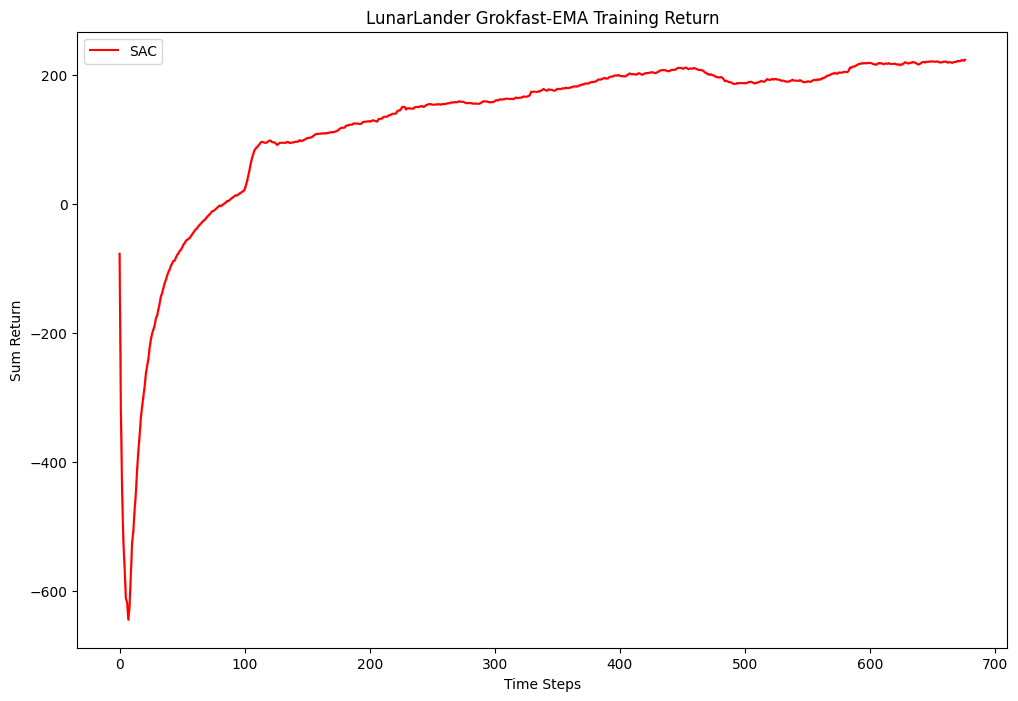

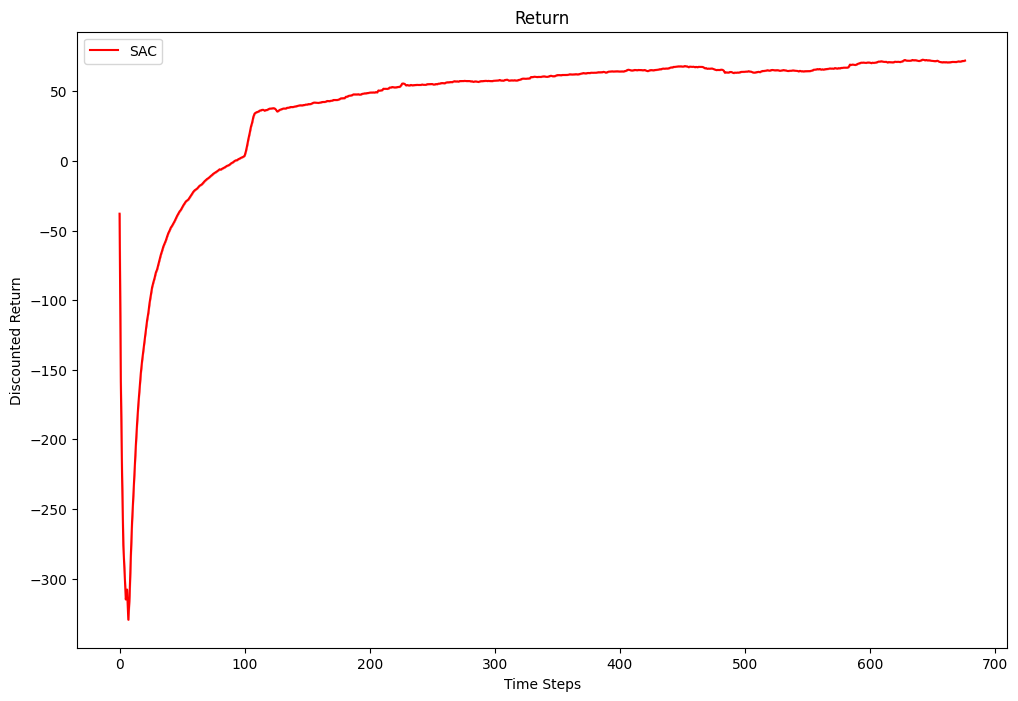

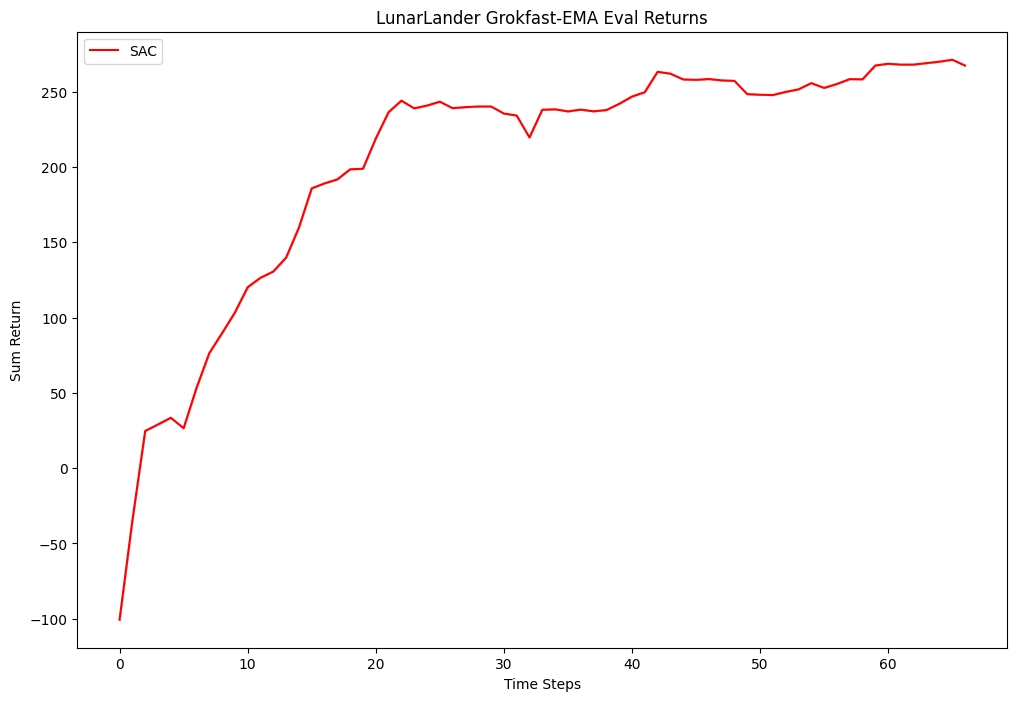

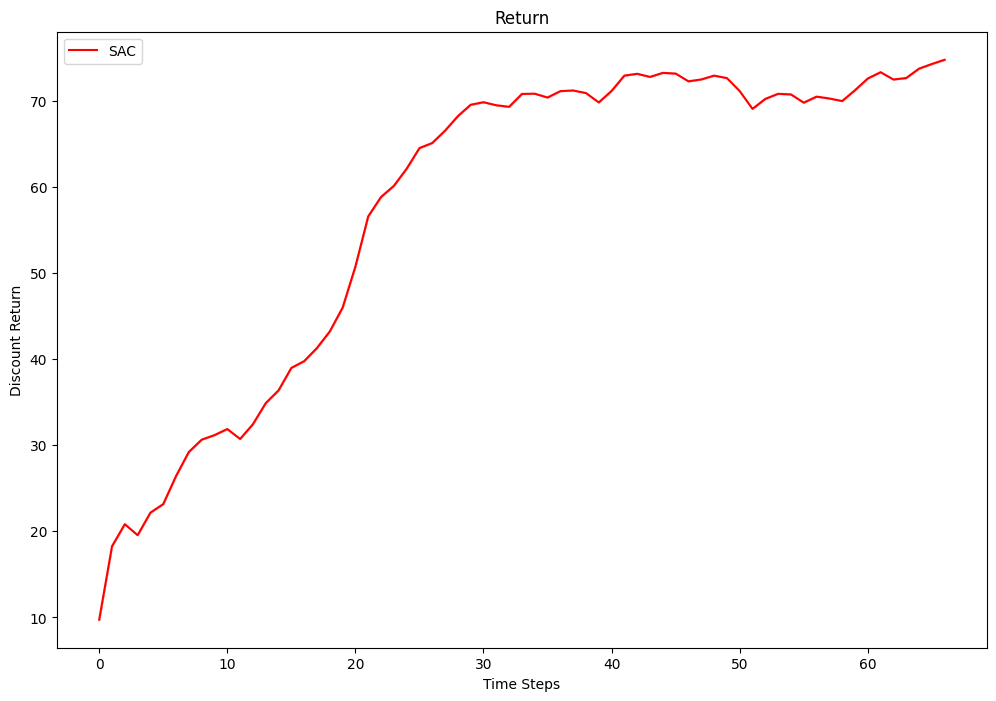

In [177]:
plot_curves([np.array(returns_over_steps_ema)], ['SAC'], ['r'], 'Sum Return', 'LunarLander Grokfast-EMA Training Return', smoothing = True, window=100)
plot_curves([np.array(discounted_returns_ema)], ['SAC'], ['r'], 'Discounted Return', 'Return', smoothing = True, window=100)
plot_curves([np.array(eval_returns_sum_ema)], ['SAC'], ['r'], 'Sum Return', 'LunarLander Grokfast-EMA Eval Returns', smoothing = True, window=10)
plot_curves([np.array(eval_returns_discount_ema)], ['SAC'], ['r'], 'Discount Return', 'Return', smoothing = True, window=10)

In [161]:
env = gym.make('LunarLander-v2')
returns, disc_returns = evaluate_agent(env, lunarSACAgent_ema, num_episodes=100, gamma=0.99)
print(f"Average Return: {returns:.2f}, Average Discounted Return: {disc_returns:.2f}")
# in lunar lander, if the average return is above 200 for 100 episodes, it is considered solved


Average Return: 273.35, Average Discounted Return: 76.39


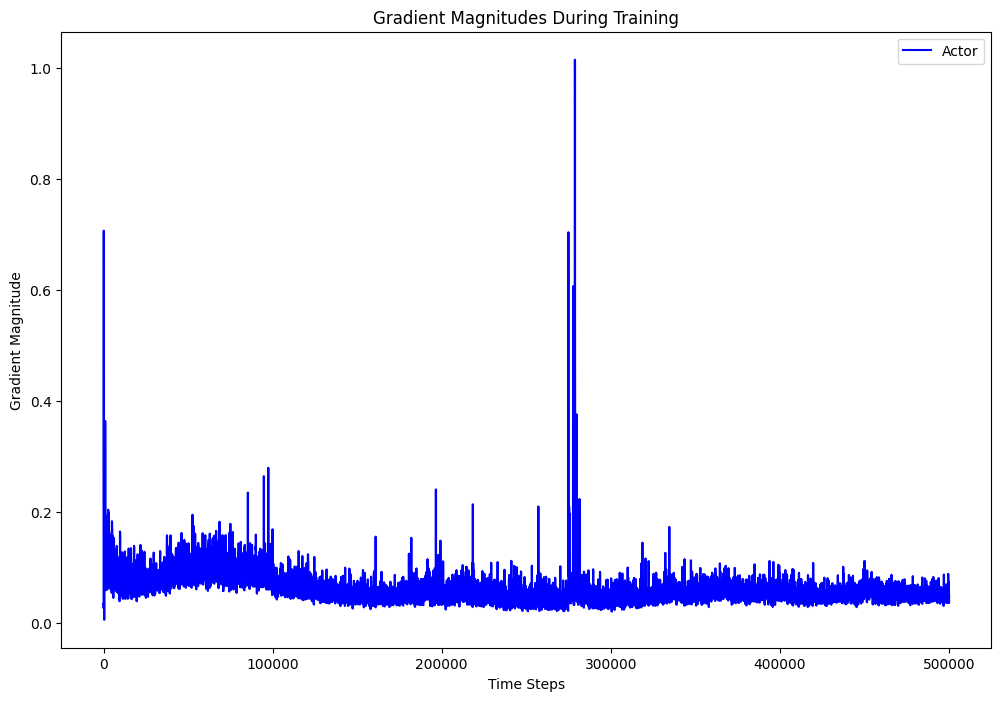

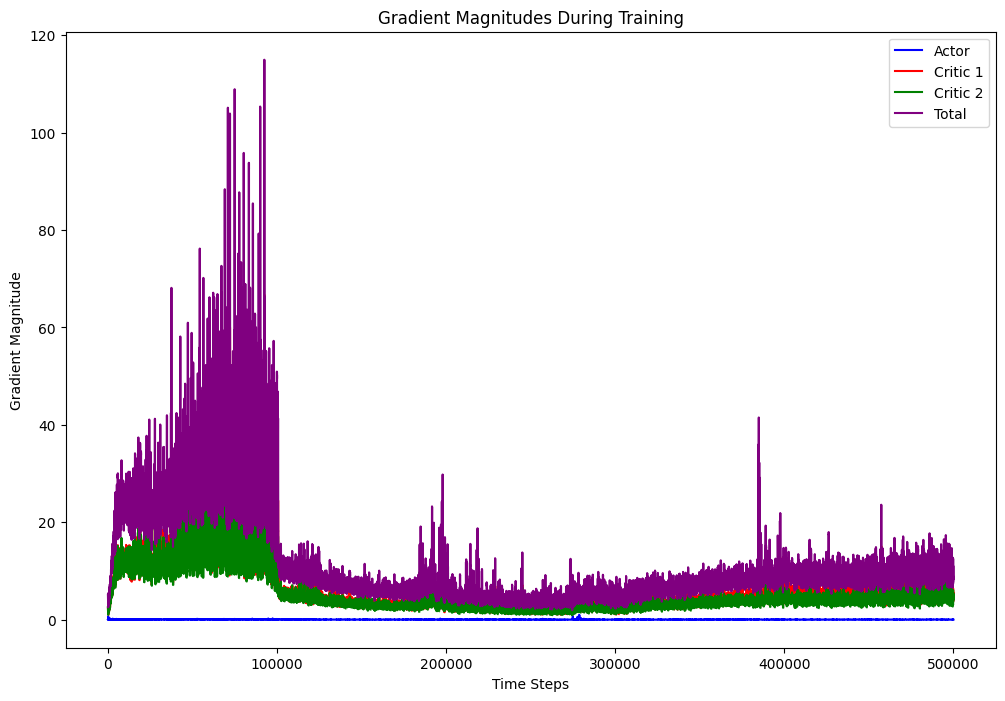

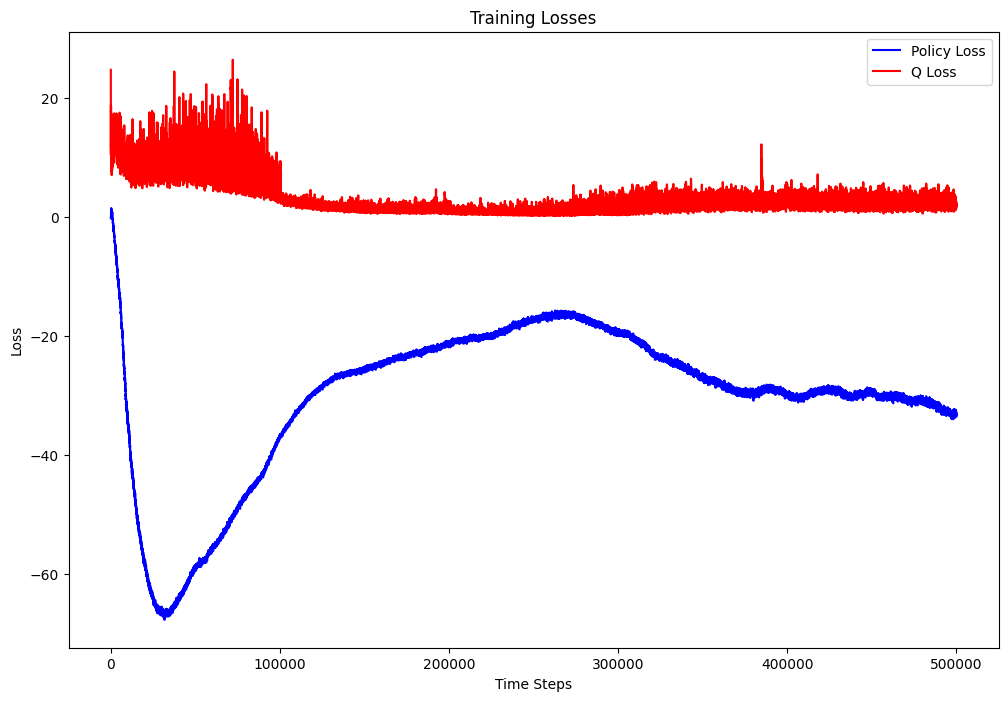

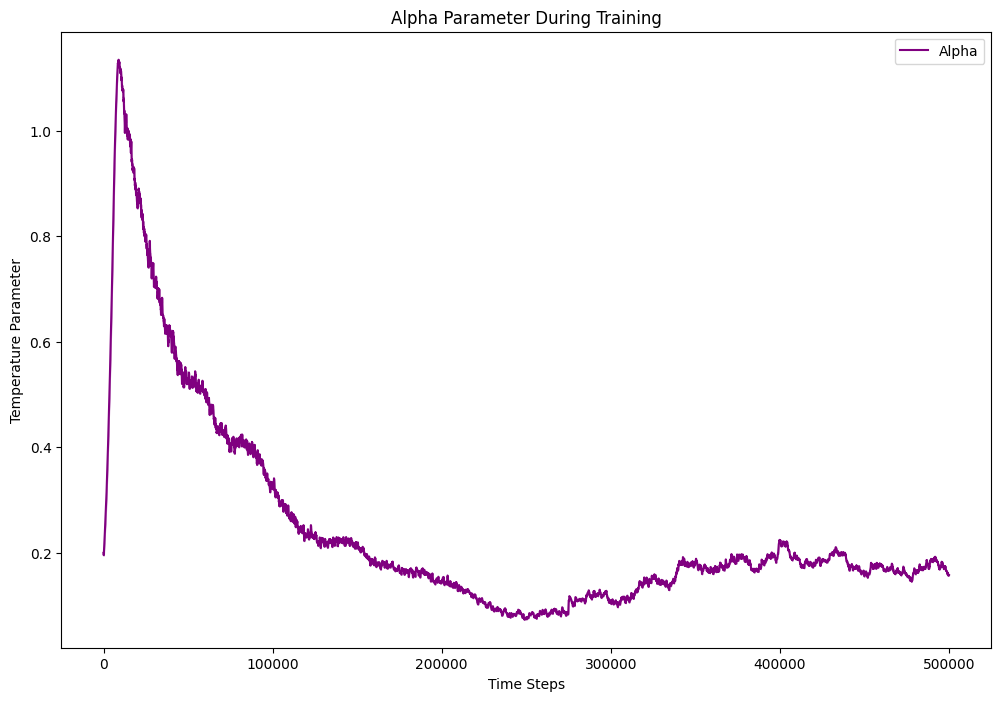

In [162]:
plot_training_metrics(grad_metrics_ema, losses_ema)